In [9]:
import numpy as np
import networkx as nx
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import geopandas as gpd
from shapely.geometry import Point
import time

In [2]:
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

G = nx.DiGraph()

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
    
N = l

W = [0 for u in range(N)]

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']
    
G_ = G.reverse()

In [1]:
def get_size(G, V_, N, u):
    
    if V_[u] == 1:
        return 0
    
    V = V_.copy()
    
    ans = 1;  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                ans += 1; V[v] = 1
                Q.append(v)
    
    return ans

def visit(G, V, u):
    
    if V[u] == 1:
        return V, 0
    
    V[u] = 1; ans = 0
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft(); ans += 1
        for v in G.predecessors(u):
            if not V[v]:
                V[v] = 1
                Q.append(v)
    
    return V, ans

In [2]:
def get_size_weight(G, V_, N, u):
    
    if V_[u] == 1:
        return 0, 0
    
    V = V_.copy()
    
    s = 1; w = W[u];  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s += 1; w += W[v]; V[v] = 1
                Q.append(v)
    
    return s, w

def greedyAppW(G, V_, N, K, limit, wlim):
    
    V = V_.copy()
    
    E = []
    for u in range(N):
        if not V[u]:
            E.append((get_size(G, V, N, u), u))

    S = set()
    for e in E:
        if e[0] > 0 and e[0] <= limit:
            S.add(e[1])

    ans = []
    count = 0
    while count < K:
        maxv = 0; u = -1
        for v in S:
            s, w = get_size_weight(G, V, N, v)
            if s > maxv and w <= wlim:
                u = v
                maxv = s
        if u == -1:
            break

        V, _ = visit(G, V, u)
        ans.append(u)
        S.remove(u)
        count += 1

    return ans

In [3]:
def add_visit(G, N, V, u):
    
    V_ = [0 for u in range(N)]
    
    V[u] += 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V_[v]:
                V[v] += 1
                V_[v] = 1
                Q.append(v)
                
def deactivate(G, V, u):
    V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                V[v] = 1
                Q.append(v)

In [4]:
def get_weighted_size_weight(G, V_, R, N, u):
    
    if V_[u] == 1:
        return 0, 0
    
    V = V_.copy()
    
    s = R[u]; w = W[u];  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s += R[v]; w += W[v]; V[v] = 1
                Q.append(v)
    
    return s, w

def firstSample(G, R, N, K, limit, wlim):
    
    V = [0 for u in range(N)]
    
    E = []
    for u in range(N):
        if not V[u]:
            E.append((get_size(G, V, N, u), u))

    S = set()
    for e in E:
        if e[0] > 0 and e[0] <= limit:
            S.add(e[1])

    ans = []
    count = 0
    while count < K:
        maxv = 0; u = -1
        for v in S:
            s, w = get_weighted_size_weight(G, V, R, N, v)
            if s > maxv and w <= wlim:
                u = v
                maxv = s
        if u == -1:
            break

        V, _ = visit(G, V, u)
        ans.append(u)
        S.remove(u)
        count += 1

    return ans

In [7]:
R = [1 for u in range(N)]

print("Initial Election:", greedyAppW(G, [0 for u in range(N)], N, 10, N / 2, 5000))

T = [0 for u in range(N)]
for _ in range(10):
    lr = firstSample(G, R, N, 10, N, 10000)
    
    V = [0 for u in range(N)]
    for u in lr:
        V, _ = visit(G, V, u)
        
    T = [T[u] or V[u] for u in range(N)]
        
    R = [1 if V[u] else 10 * R[u] for u in range(N)]
    
    print(lr, sum([1 - T[u] for u in range(N)]))
    print("max R:", max(R))

Initial Election: [2995, 3309, 803, 3308, 1210, 161, 942, 1033, 144, 4271]
[803, 3309, 2140, 2165, 2319, 3308, 4191, 275, 1027, 2148] 773
max R: 10
[422, 816, 1433, 803, 1430, 3309, 2140, 2165, 2319, 3308] 11
max R: 100
[1037, 1210, 942, 4201, 1033, 3338, 936, 1905, 2154, 2162] 11
max R: 1000
[2165, 2319, 422, 816, 1433, 803, 1430, 3309, 2140, 3308] 11
max R: 10000
[1037, 1210, 942, 4201, 1033, 3338, 936, 1905, 2154, 2162] 11
max R: 100000
[2165, 2319, 422, 816, 1433, 803, 1430, 3309, 2140, 3308] 11
max R: 1000000
[1037, 1210, 942, 4201, 1033, 3338, 936, 1905, 2154, 2162] 11
max R: 10000000
[2165, 2319, 422, 816, 1433, 803, 1430, 3309, 2140, 3308] 11
max R: 100000000
[1037, 1210, 942, 4201, 1033, 3338, 936, 1905, 2154, 2162] 11
max R: 1000000000
[2165, 2319, 422, 816, 1433, 803, 1430, 3309, 2140, 3308] 11
max R: 10000000000


In [5]:
def get_size_weight_precalc(G, V_, S, N, u):
    
    if V_[u] == 1:
        return 0
    
    if S[u] <= 200:
        return 1
    
    V = V_.copy()
    
    s = 1; V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s += 1; V[v] = 1
                if S[v] > 200:
                    Q.append(v)
    
    return s

def greedyAppWeightReduce(G, V_, N, K, limit, wlim):
    
    V = V_.copy()
    
    E = []
    for u in range(N):
        if not V[u]:
            E.append((get_size(G, V, N, u), u))

    limit_set = set()
    for e in E:
        if e[0] > 0 and e[0] <= limit:
            limit_set.add(e[1])

    ans = []
    count = 0; tot = 0
    while count < K:
        
        S = [0 for u in range(N)]
        for v in limit_set:
            _, S[v] = get_size_weight(G, V, N, v)
        
        maxv = 0; u = -1
        for v in limit_set:
            s = get_size_weight_precalc(G, V, S, N, v)
            if s > maxv and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            break

        V, aux = visit(G, V, u)
        ans.append(u); tot += aux
        limit_set.remove(u)
        count += 1

    return ans, tot

In [7]:
path = 'data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
geometry['color'] = 10
for u in range(N):
    geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = 0
f, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Resultados de testeo", fontsize=25)
ax = geometry.plot(ax = ax, column = 'color',
            figsize=(15, 15),
            cmap = 'nipy_spectral',)

plt.show()

NameError: name 'N' is not defined

In [6]:
def get_ideal(G, V_, u):
    V = V_.copy()
    s = [u];  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s.append(v)
                V[v] = 1; Q.append(v)
    
    return s

def plot_sample(G, V, N, sample, geom):
    
    geometry = geom.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
    
    for i in range(len(I)):
        for u in I[i]:
            if C[u] == 0:
                C[u] = i + 2
            elif C[u] != 1:
                C[u] = 1

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        if C[u] != -1:
            geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                figsize=(15, 15),
                legend = True,
                legend_kwds={'label': "-1: No considerado \n 0: No cubierto \n 1: Intersección ", 'orientation': "horizontal"},
                cmap = 'nipy_spectral',)
    plt.show()  


In [24]:
V = [0 for u in range(N)]
S = [0 for u in range(N)]
for v in range(N):
    _, S[v] = get_size_weight(G, V, N, v)

maxv = 0; u = -1
for v in range(N):
    s = get_size_weight_precalc(G, V, S, N, v)
    if s > maxv:
        u = v
        maxv = s
print(u, maxv)

ss = set(get_ideal(G, [0 for v in range(N)], u))

for v in range(N):
    if v not in ss:
        print(_id[v], end=", ")
    

744 2564


In [41]:
T = []

S = [u for u in range(N)]

for r in S:
    CV = [0 for u in range(N)]

    CV[r] = 1
    Q = deque([]); Q.append(r)
    while Q:
        u = Q.popleft()
        for v in G.successors(u):
            if not CV[v]:
                CV[v] = 1
                Q.append(v)
    V = [0 for u in range(N)]

    R = N
    for t in range(100):
        P = []
        if t == 0:
            P, _ = greedyAppWeightReduce(G, V, N, 8, 1200, 100000000)
        else:
            P, sP = greedyAppWeightReduce(G, V, N, 2, R / 2, 100000000)
        
        if sum([CV[p] for p in P]) > 0:
            V = [0 if not V[u] else -1 for u in range(N)]
            for p in P:
                if CV[p]:
                    add_visit(G, N, V, p)
            for u in range(N):
                if V[u] == sum([CV[p] for p in P]):
                    V[u] = 0
                else:
                    V[u] = 1
        for p in P:
            if not V[p] and not CV[p]:
                deactivate(G, V, p)

        sizes = [0 for u in range(N)]; weights = [0 for u in range(N)]
        for v in range(N):
            sizes[v], weights[v] = get_size_weight(G, V, N, v)
                
        R = sum([1 - V[u] for u in range(N)])
        
        if R == 1 or (max(sizes) == R and max(weights) <= 200):
            T.append(t + 1)
            print(f"Result {r}: {T[-1]}    acc: {sum(T) / (r + 1)}")
            break
        if t == 99:
            T.append(100)
            print(f"Result {r}: {T[-1]}    acc: {sum(T) / (r + 1)}")
            
print(sum(T) / len(T), max(T))


Result 0: 5    acc: 5.0
Result 1: 7    acc: 6.0
Result 2: 5    acc: 5.666666666666667
Result 3: 6    acc: 5.75
Result 4: 6    acc: 5.8
Result 5: 7    acc: 6.0
Result 6: 5    acc: 5.857142857142857
Result 7: 5    acc: 5.75
Result 8: 5    acc: 5.666666666666667
Result 9: 5    acc: 5.6
Result 10: 5    acc: 5.545454545454546
Result 11: 6    acc: 5.583333333333333
Result 12: 6    acc: 5.615384615384615
Result 13: 6    acc: 5.642857142857143
Result 14: 4    acc: 5.533333333333333
Result 15: 4    acc: 5.4375
Result 16: 3    acc: 5.294117647058823
Result 17: 3    acc: 5.166666666666667
Result 18: 4    acc: 5.105263157894737
Result 19: 4    acc: 5.05
Result 20: 4    acc: 5.0
Result 21: 4    acc: 4.954545454545454
Result 22: 5    acc: 4.956521739130435
Result 23: 5    acc: 4.958333333333333
Result 24: 3    acc: 4.88
Result 25: 3    acc: 4.8076923076923075
Result 26: 7    acc: 4.888888888888889
Result 27: 5    acc: 4.892857142857143
Result 28: 4    acc: 4.862068965517241
Result 29: 8    acc: 4.96

Result 217: 8    acc: 5.876146788990826
Result 218: 9    acc: 5.890410958904109
Result 219: 9    acc: 5.904545454545454
Result 220: 7    acc: 5.909502262443439
Result 221: 5    acc: 5.905405405405405
Result 222: 5    acc: 5.901345291479821
Result 223: 5    acc: 5.897321428571429
Result 224: 6    acc: 5.897777777777778
Result 225: 6    acc: 5.898230088495575
Result 226: 6    acc: 5.898678414096916
Result 227: 6    acc: 5.899122807017544
Result 228: 5    acc: 5.895196506550218
Result 229: 5    acc: 5.891304347826087
Result 230: 6    acc: 5.891774891774892
Result 231: 6    acc: 5.892241379310345
Result 232: 6    acc: 5.8927038626609445
Result 233: 5    acc: 5.888888888888889
Result 234: 7    acc: 5.8936170212765955
Result 235: 6    acc: 5.8940677966101696
Result 236: 5    acc: 5.890295358649789
Result 237: 7    acc: 5.894957983193278
Result 238: 4    acc: 5.887029288702929
Result 239: 5    acc: 5.883333333333334
Result 240: 6    acc: 5.8838174273858925
Result 241: 6    acc: 5.884297520661

Result 425: 7    acc: 6.131455399061033
Result 426: 6    acc: 6.131147540983607
Result 427: 6    acc: 6.130841121495327
Result 428: 5    acc: 6.128205128205129
Result 429: 7    acc: 6.130232558139535
Result 430: 7    acc: 6.132250580046404
Result 431: 7    acc: 6.1342592592592595
Result 432: 5    acc: 6.131639722863741
Result 433: 5    acc: 6.129032258064516
Result 434: 6    acc: 6.128735632183908
Result 435: 6    acc: 6.128440366972477
Result 436: 9    acc: 6.135011441647597
Result 437: 9    acc: 6.141552511415525
Result 438: 8    acc: 6.145785876993166
Result 439: 8    acc: 6.15
Result 440: 7    acc: 6.1519274376417235
Result 441: 7    acc: 6.153846153846154
Result 442: 7    acc: 6.155756207674943
Result 443: 9    acc: 6.162162162162162
Result 444: 7    acc: 6.164044943820224
Result 445: 7    acc: 6.165919282511211
Result 446: 7    acc: 6.167785234899329
Result 447: 7    acc: 6.169642857142857
Result 448: 7    acc: 6.171492204899777
Result 449: 7    acc: 6.173333333333333
Result 450:

Result 633: 7    acc: 6.157728706624606
Result 634: 7    acc: 6.159055118110237
Result 635: 7    acc: 6.160377358490566
Result 636: 6    acc: 6.160125588697017
Result 637: 7    acc: 6.161442006269592
Result 638: 7    acc: 6.162754303599374
Result 639: 5    acc: 6.1609375
Result 640: 5    acc: 6.159126365054602
Result 641: 5    acc: 6.157320872274143
Result 642: 5    acc: 6.155520995334371
Result 643: 6    acc: 6.15527950310559
Result 644: 5    acc: 6.153488372093023
Result 645: 6    acc: 6.1532507739938085
Result 646: 6    acc: 6.153013910355487
Result 647: 7    acc: 6.154320987654321
Result 648: 6    acc: 6.154083204930663
Result 649: 6    acc: 6.153846153846154
Result 650: 6    acc: 6.153609831029186
Result 651: 6    acc: 6.153374233128834
Result 652: 8    acc: 6.1562021439509955
Result 653: 7    acc: 6.157492354740061
Result 654: 8    acc: 6.1603053435114505
Result 655: 6    acc: 6.160060975609756
Result 656: 7    acc: 6.161339421613394
Result 657: 6    acc: 6.161094224924012
Result

Result 839: 6    acc: 6.2214285714285715
Result 840: 6    acc: 6.2211652794292505
Result 841: 6    acc: 6.220902612826603
Result 842: 6    acc: 6.220640569395018
Result 843: 6    acc: 6.220379146919432
Result 844: 6    acc: 6.220118343195266
Result 845: 6    acc: 6.219858156028369
Result 846: 5    acc: 6.218417945690673
Result 847: 6    acc: 6.21816037735849
Result 848: 6    acc: 6.217903415783274
Result 849: 6    acc: 6.2176470588235295
Result 850: 6    acc: 6.217391304347826
Result 851: 6    acc: 6.217136150234742
Result 852: 7    acc: 6.218053927315357
Result 853: 6    acc: 6.217798594847775
Result 854: 7    acc: 6.218713450292397
Result 855: 6    acc: 6.218457943925234
Result 856: 7    acc: 6.219369894982497
Result 857: 7    acc: 6.22027972027972
Result 858: 5    acc: 6.218859138533178
Result 859: 5    acc: 6.217441860465116
Result 860: 6    acc: 6.21718931475029
Result 861: 6    acc: 6.216937354988399
Result 862: 6    acc: 6.216685979142526
Result 863: 6    acc: 6.216435185185185


Result 1043: 7    acc: 6.2701149425287355
Result 1044: 5    acc: 6.2688995215311
Result 1045: 7    acc: 6.269598470363289
Result 1046: 6    acc: 6.269340974212034
Result 1047: 7    acc: 6.270038167938932
Result 1048: 7    acc: 6.270734032411821
Result 1049: 7    acc: 6.271428571428571
Result 1050: 7    acc: 6.272121788772598
Result 1051: 7    acc: 6.272813688212928
Result 1052: 7    acc: 6.273504273504273
Result 1053: 7    acc: 6.274193548387097
Result 1054: 7    acc: 6.274881516587678
Result 1055: 8    acc: 6.276515151515151
Result 1056: 5    acc: 6.275307473982971
Result 1057: 6    acc: 6.275047258979206
Result 1058: 6    acc: 6.2747875354107645
Result 1059: 5    acc: 6.273584905660377
Result 1060: 7    acc: 6.274269557021678
Result 1061: 8    acc: 6.275894538606403
Result 1062: 7    acc: 6.276575729068673
Result 1063: 8    acc: 6.2781954887218046
Result 1064: 7    acc: 6.27887323943662
Result 1065: 5    acc: 6.277673545966229
Result 1066: 6    acc: 6.277413308341143
Result 1067: 7  

Result 1244: 7    acc: 6.186345381526104
Result 1245: 6    acc: 6.186195826645265
Result 1246: 6    acc: 6.186046511627907
Result 1247: 6    acc: 6.185897435897436
Result 1248: 7    acc: 6.186549239391513
Result 1249: 7    acc: 6.1872
Result 1250: 7    acc: 6.187849720223821
Result 1251: 7    acc: 6.18849840255591
Result 1252: 6    acc: 6.188347964884278
Result 1253: 6    acc: 6.188197767145136
Result 1254: 6    acc: 6.18804780876494
Result 1255: 6    acc: 6.187898089171974
Result 1256: 6    acc: 6.18774860779634
Result 1257: 6    acc: 6.1875993640699525
Result 1258: 7    acc: 6.1882446386020655
Result 1259: 7    acc: 6.188888888888889
Result 1260: 7    acc: 6.189532117367169
Result 1261: 7    acc: 6.190174326465927
Result 1262: 7    acc: 6.190815518606493
Result 1263: 7    acc: 6.1914556962025316
Result 1264: 7    acc: 6.192094861660079
Result 1265: 7    acc: 6.192733017377567
Result 1266: 7    acc: 6.193370165745856
Result 1267: 7    acc: 6.194006309148265
Result 1268: 6    acc: 6.19

Result 1445: 6    acc: 6.2254495159059475
Result 1446: 7    acc: 6.225984796129924
Result 1447: 7    acc: 6.226519337016574
Result 1448: 5    acc: 6.225672877846791
Result 1449: 3    acc: 6.223448275862069
Result 1450: 3    acc: 6.221226740179187
Result 1451: 3    acc: 6.2190082644628095
Result 1452: 4    acc: 6.2174810736407435
Result 1453: 4    acc: 6.21595598349381
Result 1454: 4    acc: 6.214432989690722
Result 1455: 4    acc: 6.212912087912088
Result 1456: 4    acc: 6.211393273850377
Result 1457: 4    acc: 6.209876543209877
Result 1458: 4    acc: 6.208361891706648
Result 1459: 4    acc: 6.206849315068493
Result 1460: 4    acc: 6.205338809034908
Result 1461: 4    acc: 6.203830369357045
Result 1462: 5    acc: 6.203007518796992
Result 1463: 5    acc: 6.202185792349726
Result 1464: 5    acc: 6.201365187713311
Result 1465: 5    acc: 6.200545702592088
Result 1466: 5    acc: 6.19972733469666
Result 1467: 5    acc: 6.198910081743869
Result 1468: 5    acc: 6.198093941456773
Result 1469: 5 

Result 1646: 6    acc: 6.159684274438373
Result 1647: 5    acc: 6.158980582524272
Result 1648: 5    acc: 6.158277744087326
Result 1649: 6    acc: 6.158181818181818
Result 1650: 5    acc: 6.15748031496063
Result 1651: 6    acc: 6.157384987893463
Result 1652: 6    acc: 6.157289776164549
Result 1653: 6    acc: 6.157194679564691
Result 1654: 6    acc: 6.157099697885196
Result 1655: 5    acc: 6.156400966183575
Result 1656: 6    acc: 6.156306578153289
Result 1657: 6    acc: 6.156212303980699
Result 1658: 5    acc: 6.155515370705244
Result 1659: 5    acc: 6.154819277108434
Result 1660: 5    acc: 6.154124021673691
Result 1661: 5    acc: 6.153429602888087
Result 1662: 6    acc: 6.153337342152736
Result 1663: 6    acc: 6.1532451923076925
Result 1664: 5    acc: 6.152552552552552
Result 1665: 5    acc: 6.151860744297719
Result 1666: 6    acc: 6.151769646070786
Result 1667: 5    acc: 6.151079136690647
Result 1668: 5    acc: 6.1503894547633315
Result 1669: 5    acc: 6.149700598802395
Result 1670: 5 

Result 1847: 5    acc: 6.159090909090909
Result 1848: 8    acc: 6.1600865332612225
Result 1849: 6    acc: 6.16
Result 1850: 8    acc: 6.160994057266342
Result 1851: 6    acc: 6.160907127429805
Result 1852: 5    acc: 6.160280626011873
Result 1853: 6    acc: 6.160194174757281
Result 1854: 6    acc: 6.16010781671159
Result 1855: 9    acc: 6.161637931034483
Result 1856: 7    acc: 6.162089391491653
Result 1857: 7    acc: 6.16254036598493
Result 1858: 5    acc: 6.1619150080688545
Result 1859: 8    acc: 6.162903225806452
Result 1860: 5    acc: 6.162278344975819
Result 1861: 8    acc: 6.163265306122449
Result 1862: 8    acc: 6.164251207729468
Result 1863: 9    acc: 6.165772532188841
Result 1864: 9    acc: 6.167292225201073
Result 1865: 6    acc: 6.167202572347267
Result 1866: 8    acc: 6.168184252811998
Result 1867: 7    acc: 6.168629550321199
Result 1868: 5    acc: 6.168004280363831
Result 1869: 7    acc: 6.168449197860962
Result 1870: 4    acc: 6.167290219134153
Result 1871: 4    acc: 6.1661

Result 2048: 7    acc: 6.13958028306491
Result 2049: 7    acc: 6.14
Result 2050: 5    acc: 6.1394441735738665
Result 2051: 5    acc: 6.138888888888889
Result 2052: 7    acc: 6.1393083292742325
Result 2053: 6    acc: 6.139240506329114
Result 2054: 7    acc: 6.139659367396594
Result 2055: 5    acc: 6.139105058365759
Result 2056: 6    acc: 6.13903743315508
Result 2057: 6    acc: 6.1389698736637515
Result 2058: 7    acc: 6.139388052452647
Result 2059: 7    acc: 6.139805825242719
Result 2060: 7    acc: 6.14022319262494
Result 2061: 7    acc: 6.1406401551891365
Result 2062: 6    acc: 6.140571982549685
Result 2063: 6    acc: 6.140503875968992
Result 2064: 6    acc: 6.14043583535109
Result 2065: 6    acc: 6.140367860600193
Result 2066: 6    acc: 6.140299951620706
Result 2067: 6    acc: 6.140232108317215
Result 2068: 6    acc: 6.14016433059449
Result 2069: 10    acc: 6.142028985507246
Result 2070: 7    acc: 6.142443264123612
Result 2071: 7    acc: 6.142857142857143
Result 2072: 6    acc: 6.1427

Result 2249: 5    acc: 6.143555555555555
Result 2250: 6    acc: 6.143491781430475
Result 2251: 8    acc: 6.144316163410302
Result 2252: 8    acc: 6.145139813581891
Result 2253: 7    acc: 6.145519077196096
Result 2254: 7    acc: 6.1458980044345894
Result 2255: 7    acc: 6.1462765957446805
Result 2256: 5    acc: 6.145768719539212
Result 2257: 7    acc: 6.146147032772365
Result 2258: 8    acc: 6.14696768481629
Result 2259: 7    acc: 6.147345132743363
Result 2260: 8    acc: 6.148164528969483
Result 2261: 8    acc: 6.148983200707339
Result 2262: 7    acc: 6.149359257622625
Result 2263: 5    acc: 6.148851590106007
Result 2264: 6    acc: 6.14878587196468
Result 2265: 6    acc: 6.148720211827008
Result 2266: 7    acc: 6.149095721217468
Result 2267: 7    acc: 6.1494708994708995
Result 2268: 7    acc: 6.149845747025121
Result 2269: 4    acc: 6.148898678414097
Result 2270: 7    acc: 6.1492734478203435
Result 2271: 7    acc: 6.149647887323944
Result 2272: 7    acc: 6.150021997360317
Result 2273: 7

Result 2449: 8    acc: 6.175102040816326
Result 2450: 5    acc: 6.174622603019176
Result 2451: 8    acc: 6.1753670473083195
Result 2452: 8    acc: 6.176110884631064
Result 2453: 8    acc: 6.176854115729421
Result 2454: 8    acc: 6.177596741344195
Result 2455: 7    acc: 6.177931596091205
Result 2456: 8    acc: 6.178673178673178
Result 2457: 8    acc: 6.179414157851912
Result 2458: 7    acc: 6.1797478649857664
Result 2459: 7    acc: 6.180081300813008
Result 2460: 8    acc: 6.180820804550995
Result 2461: 5    acc: 6.180341186027619
Result 2462: 5    acc: 6.1798619569630535
Result 2463: 8    acc: 6.18060064935065
Result 2464: 8    acc: 6.1813387423935096
Result 2465: 8    acc: 6.1820762368207625
Result 2466: 8    acc: 6.182813133360357
Result 2467: 8    acc: 6.18354943273906
Result 2468: 8    acc: 6.184285135682463
Result 2469: 8    acc: 6.185020242914979
Result 2470: 8    acc: 6.185754755159854
Result 2471: 8    acc: 6.186488673139158
Result 2472: 8    acc: 6.187221997573797
Result 2473: 

Result 2650: 8    acc: 6.200678989060732
Result 2651: 8    acc: 6.201357466063349
Result 2652: 8    acc: 6.202035431586883
Result 2653: 8    acc: 6.202712886209495
Result 2654: 8    acc: 6.203389830508475
Result 2655: 8    acc: 6.204066265060241
Result 2656: 7    acc: 6.204365826119684
Result 2657: 8    acc: 6.205041384499624
Result 2658: 5    acc: 6.204588191049266
Result 2659: 5    acc: 6.204135338345865
Result 2660: 5    acc: 6.203682826005261
Result 2661: 5    acc: 6.203230653643876
Result 2662: 5    acc: 6.2027788208787085
Result 2663: 5    acc: 6.202327327327327
Result 2664: 5    acc: 6.2018761726078795
Result 2665: 5    acc: 6.201425356339085
Result 2666: 5    acc: 6.200974878140232
Result 2667: 7    acc: 6.201274362818591
Result 2668: 7    acc: 6.201573623079805
Result 2669: 7    acc: 6.20187265917603
Result 2670: 5    acc: 6.201422688131786
Result 2671: 6    acc: 6.201347305389222
Result 2672: 5    acc: 6.200897867564534
Result 2673: 7    acc: 6.201196709050112
Result 2674: 7 

Result 2850: 6    acc: 6.211855489302
Result 2851: 6    acc: 6.211781206171108
Result 2852: 6    acc: 6.211706975113915
Result 2853: 6    acc: 6.211632796075683
Result 2854: 6    acc: 6.211558669001751
Result 2855: 6    acc: 6.211484593837535
Result 2856: 6    acc: 6.2114105705285265
Result 2857: 6    acc: 6.211336599020294
Result 2858: 6    acc: 6.211262679258482
Result 2859: 6    acc: 6.211188811188811
Result 2860: 6    acc: 6.211114994757078
Result 2861: 5    acc: 6.210691823899371
Result 2862: 6    acc: 6.210618232623123
Result 2863: 5    acc: 6.210195530726257
Result 2864: 5    acc: 6.209773123909249
Result 2865: 5    acc: 6.209351011863224
Result 2866: 5    acc: 6.208929194279735
Result 2867: 7    acc: 6.2092050209205025
Result 2868: 8    acc: 6.209829208783549
Result 2869: 8    acc: 6.210452961672474
Result 2870: 7    acc: 6.210727969348659
Result 2871: 13    acc: 6.213091922005571
Result 2872: 13    acc: 6.215454229028889
Result 2873: 13    acc: 6.217814892136396
Result 2874: 1

Result 3050: 4    acc: 6.2507374631268435
Result 3051: 5    acc: 6.250327653997378
Result 3052: 5    acc: 6.24991811333115
Result 3053: 5    acc: 6.24950884086444
Result 3054: 5    acc: 6.249099836333879
Result 3055: 4    acc: 6.24836387434555
Result 3056: 4    acc: 6.24762839385018
Result 3057: 7    acc: 6.247874427730543
Result 3058: 8    acc: 6.248447204968944
Result 3059: 8    acc: 6.249019607843137
Result 3060: 8    acc: 6.249591636720026
Result 3061: 7    acc: 6.249836708033965
Result 3062: 7    acc: 6.250081619327457
Result 3063: 5    acc: 6.24967362924282
Result 3064: 5    acc: 6.249265905383361
Result 3065: 5    acc: 6.248858447488584
Result 3066: 6    acc: 6.2487773068144765
Result 3067: 6    acc: 6.248696219035202
Result 3068: 6    acc: 6.248615184099055
Result 3069: 6    acc: 6.2485342019543975
Result 3070: 6    acc: 6.248453272549658
Result 3071: 6    acc: 6.248372395833333
Result 3072: 6    acc: 6.248291571753986
Result 3073: 6    acc: 6.248210800260248
Result 3074: 6    

Result 3251: 6    acc: 6.232472324723247
Result 3252: 6    acc: 6.232400860743929
Result 3253: 6    acc: 6.232329440688384
Result 3254: 5    acc: 6.231950844854071
Result 3255: 5    acc: 6.231572481572481
Result 3256: 8    acc: 6.23211544365981
Result 3257: 8    acc: 6.232658072437078
Result 3258: 8    acc: 6.233200368211108
Result 3259: 5    acc: 6.232822085889571
Result 3260: 6    acc: 6.232750689972401
Result 3261: 6    acc: 6.232679337829553
Result 3262: 6    acc: 6.232608029420779
Result 3263: 6    acc: 6.232536764705882
Result 3264: 6    acc: 6.232465543644716
Result 3265: 6    acc: 6.232394366197183
Result 3266: 6    acc: 6.232323232323233
Result 3267: 7    acc: 6.232558139534884
Result 3268: 5    acc: 6.232181095136127
Result 3269: 8    acc: 6.232721712538226
Result 3270: 6    acc: 6.232650565576276
Result 3271: 6    acc: 6.23257946210269
Result 3272: 6    acc: 6.232508402077604
Result 3273: 6    acc: 6.23243738546121
Result 3274: 7    acc: 6.232671755725191
Result 3275: 5    a

Result 3451: 6    acc: 6.2285631517960605
Result 3452: 6    acc: 6.228496959165943
Result 3453: 6    acc: 6.228430804863926
Result 3454: 6    acc: 6.228364688856729
Result 3455: 6    acc: 6.228298611111111
Result 3456: 6    acc: 6.228232571593868
Result 3457: 6    acc: 6.228166570271833
Result 3458: 6    acc: 6.228100607111882
Result 3459: 7    acc: 6.228323699421965
Result 3460: 7    acc: 6.228546662814216
Result 3461: 7    acc: 6.2287694974003465
Result 3462: 7    acc: 6.228992203291943
Result 3463: 6    acc: 6.22892609699769
Result 3464: 8    acc: 6.229437229437229
Result 3465: 6    acc: 6.22937103289094
Result 3466: 6    acc: 6.229304874531295
Result 3467: 7    acc: 6.229527104959631
Result 3468: 7    acc: 6.229749207264342
Result 3469: 7    acc: 6.229971181556196
Result 3470: 5    acc: 6.229616825122443
Result 3471: 6    acc: 6.229550691244239
Result 3472: 7    acc: 6.229772530953067
Result 3473: 6    acc: 6.229706390328152
Result 3474: 5    acc: 6.229352517985611
Result 3475: 5  

Result 3651: 5    acc: 6.21276013143483
Result 3652: 6    acc: 6.212701888858472
Result 3653: 6    acc: 6.212643678160919
Result 3654: 6    acc: 6.212585499316005
Result 3655: 6    acc: 6.212527352297593
Result 3656: 6    acc: 6.212469237079573
Result 3657: 5    acc: 6.2121377802077635
Result 3658: 5    acc: 6.211806504509429
Result 3659: 5    acc: 6.211475409836066
Result 3660: 5    acc: 6.211144496039333
Result 3661: 5    acc: 6.210813762971054
Result 3662: 5    acc: 6.21048321048321
Result 3663: 5    acc: 6.210152838427947
Result 3664: 8    acc: 6.210641200545703
Result 3665: 8    acc: 6.211129296235679
Result 3666: 7    acc: 6.211344423234252
Result 3667: 6    acc: 6.211286804798255
Result 3668: 6    acc: 6.2112292177705095
Result 3669: 6    acc: 6.2111716621253406
Result 3670: 9    acc: 6.211931353854536
Result 3671: 9    acc: 6.212690631808279
Result 3672: 9    acc: 6.213449496324531
Result 3673: 5    acc: 6.2131192161132285
Result 3674: 7    acc: 6.213333333333333
Result 3675: 8

Result 3851: 8    acc: 6.218328141225338
Result 3852: 8    acc: 6.218790552815988
Result 3853: 8    acc: 6.219252724442138
Result 3854: 8    acc: 6.219714656290532
Result 3855: 8    acc: 6.220176348547718
Result 3856: 7    acc: 6.220378532538242
Result 3857: 8    acc: 6.2208398133748055
Result 3858: 8    acc: 6.22130085514382
Result 3859: 8    acc: 6.221761658031088
Result 3860: 8    acc: 6.222222222222222
Result 3861: 7    acc: 6.222423614707406
Result 3862: 7    acc: 6.222624902925188
Result 3863: 6    acc: 6.222567287784679
Result 3864: 7    acc: 6.222768434670116
Result 3865: 7    acc: 6.22296947749612
Result 3866: 7    acc: 6.223170416343419
Result 3867: 8    acc: 6.223629782833505
Result 3868: 8    acc: 6.2240889118635305
Result 3869: 8    acc: 6.224547803617571
Result 3870: 8    acc: 6.225006458279514
Result 3871: 8    acc: 6.225464876033058
Result 3872: 8    acc: 6.225923057061709
Result 3873: 8    acc: 6.226381001548787
Result 3874: 7    acc: 6.22658064516129
Result 3875: 7   

Result 4052: 7    acc: 6.233407352578337
Result 4053: 7    acc: 6.23359644795264
Result 4054: 8    acc: 6.23403205918619
Result 4055: 8    acc: 6.234467455621302
Result 4056: 9    acc: 6.2351491249691895
Result 4057: 6    acc: 6.235091177920157
Result 4058: 6    acc: 6.235033259423504
Result 4059: 8    acc: 6.235467980295566
Result 4060: 6    acc: 6.235409997537553
Result 4061: 7    acc: 6.235598227474151
Result 4062: 7    acc: 6.235786364755107
Result 4063: 7    acc: 6.2359744094488185
Result 4064: 7    acc: 6.236162361623617
Result 4065: 7    acc: 6.236350221347762
Result 4066: 7    acc: 6.236537988689451
Result 4067: 6    acc: 6.236479842674533
Result 4068: 6    acc: 6.236421725239617
Result 4069: 6    acc: 6.236363636363636
Result 4070: 7    acc: 6.236551215917465
Result 4071: 5    acc: 6.236247544204322
Result 4072: 7    acc: 6.236435060152222
Result 4073: 6    acc: 6.236377025036819
Result 4074: 6    acc: 6.236319018404908
Result 4075: 5    acc: 6.236015701668302
Result 4076: 6  

Result 4252: 7    acc: 6.2377145544321655
Result 4253: 7    acc: 6.237893747061589
Result 4254: 8    acc: 6.2383078730904815
Result 4255: 6    acc: 6.2382518796992485
Result 4256: 5    acc: 6.237961005402866
Result 4257: 5    acc: 6.237670267731329
Result 4258: 6    acc: 6.2376144634890816
Result 4259: 6    acc: 6.237558685446009
Result 4260: 9    acc: 6.238206993663459
Result 4261: 9    acc: 6.238854997653684
Result 4262: 6    acc: 6.238798967863008
Result 4263: 6    acc: 6.238742964352721
Result 4264: 7    acc: 6.238921453692849
Result 4265: 7    acc: 6.239099859353024
Result 4266: 8    acc: 6.239512538082963
Result 4267: 8    acc: 6.239925023430178
Result 4268: 6    acc: 6.239868821738112
Result 4269: 9    acc: 6.240515222482435
Result 4270: 9    acc: 6.241161320533833
Result 4271: 5    acc: 6.240870786516854
Result 4272: 5    acc: 6.240580388485841
Result 4273: 9    acc: 6.241226017781937
Result 4274: 9    acc: 6.24187134502924
Result 4275: 9    acc: 6.242516370439663
Result 4276: 

Result 4452: 7    acc: 6.2297327644284755
Result 4453: 8    acc: 6.230130220026942
Result 4454: 6    acc: 6.2300785634118965
Result 4455: 6    acc: 6.2300269299820465
Result 4456: 8    acc: 6.230424052052951
Result 4457: 8    acc: 6.230820995962315
Result 4458: 7    acc: 6.230993496299619
Result 4459: 7    acc: 6.231165919282511
Result 4460: 7    acc: 6.2313382649630125
Result 4461: 7    acc: 6.231510533393097
Result 4462: 7    acc: 6.231682724624692
Result 4463: 6    acc: 6.23163082437276
Result 4464: 6    acc: 6.231578947368421
Result 4465: 7    acc: 6.231751007613076
Result 4466: 6    acc: 6.231699126930826
Result 4467: 4    acc: 6.231199641897941
Result 4468: 6    acc: 6.231147907809353
Result 4469: 6    acc: 6.231096196868009
Result 4470: 6    acc: 6.231044509058377
Result 4471: 6    acc: 6.230992844364938
Result 4472: 6    acc: 6.230941202772189
Result 4473: 8    acc: 6.231336611533304
Result 4474: 8    acc: 6.231731843575419
Result 4475: 6    acc: 6.231680071492404
Result 4476: 

In [40]:
T = []

S = list(random.sample(range(N), 10))

for r in S:
    CV = [0 for u in range(N)]

    CV[r] = 1
    Q = deque([]); Q.append(r)
    while Q:
        u = Q.popleft()
        for v in G.successors(u):
            if not CV[v]:
                CV[v] = 1
                Q.append(v)
    V = [0 for u in range(N)]

    R = N
    for t in range(100):
        P = []
        if t == 0:
            P, _ = greedyAppWeightReduce(G, V, N, 8, 1200, 100000000)
        else:
            
            low = 0; high = R
            while low != high:
                mid = (low + high) // 2
                P, sP = greedyAppWeightReduce(G, V, N, 2, mid, 100000000)
                if R - sP <= mid:
                    high = mid
                else:
                    low = mid + 1
            P, sP = greedyAppWeightReduce(G, V, N, 2, low, 100000000)
        
        if sum([CV[p] for p in P]) > 0:
            V = [0 if not V[u] else -1 for u in range(N)]
            for p in P:
                if CV[p]:
                    add_visit(G, N, V, p)
            for u in range(N):
                if V[u] == sum([CV[p] for p in P]):
                    V[u] = 0
                else:
                    V[u] = 1
        for p in P:
            if not V[p] and not CV[p]:
                deactivate(G, V, p)

        sizes = [0 for u in range(N)]; weights = [0 for u in range(N)]
        for v in range(N):
            sizes[v], weights[v] = get_size_weight(G, V, N, v)
                
        R = sum([1 - V[u] for u in range(N)])
        
        if R == 1 or (max(sizes) == R and max(weights) <= 200):
            T.append(t + 1)
            print(f"Result {r}: {T[-1]}    acc: {sum(T) / (r + 1)}")
            break
        if t == 99:
            T.append(100)
            print(f"Result {r}: {T[-1]}    acc: {sum(T) / (r + 1)}")
            
print(sum(T) / len(T), max(T))


Result 2036: 6    acc: 0.0029455081001472753
Result 1742: 7    acc: 0.007458405048766495
Result 257: 7    acc: 0.07751937984496124


KeyboardInterrupt: 

In [18]:
def greedyAppWeightReduceDynamic(G, V_, N, K, limit, wlim):
    
    V = V_.copy()
    
    E = {u for u in range(N) if not V[u]}

    ans = []
    count = 0; tot = 0
    while count < K:
        
        S = [0 for u in range(N)]
        for v in E:
            _, S[v] = get_size_weight(G, V, N, v)
        
        maxv = 0; u = -1
        for v in E:
            s = get_size_weight_precalc(G, V, S, N, v)
            if s > maxv and s <= limit and S[v] <= wlim:
                u = v
                maxv = s
        if u == -1:
            break

        V, aux = visit(G, V, u)
        ans.append(u); tot += aux
        E.remove(u)
        count += 1

    return ans, tot

In [19]:
def plot_sample_no_intersections(G, V, N, sample, geom):
    
    geometry = geom.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            if C[u] == 0:
                C[u] = i + 2
            elif C[u] != 1:
                C[u] = 1

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        if C[u] != -1:
            geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                figsize=(15, 15),
                legend = True,
                legend_kwds={'label': "-1: No considerado \n 0: No cubierto \n 1: Intersección ", 'orientation': "horizontal"},
                cmap = 'nipy_spectral',)
    plt.show()  

In [10]:
V = [0] * N

low = 0; high = N
while low != high:
    mid = (low + high) // 2
    P, sP = greedyAppWeightReduceDynamic(G, V, N, 8, mid, 100000000)
    if N - sP < mid:
        high = mid
    else:
        low = mid + 1

low -= 1
sample, sP = greedyAppWeightReduceDynamic(G, V, N, 8, low, 100000000)

print(low, N - sP)
print(len(sample))  ## if less than 8 entire graph gets covered with less samples

plot_sample_no_intersections(G, V, N, sample, geometry)

NameError: name 'N' is not defined

# Programación Dinámica:

In [10]:
path = 'data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

G = nx.DiGraph()

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095, 131099}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
    
N = l

W = [0 for u in range(N)]

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']
    
G_ = G.reverse()

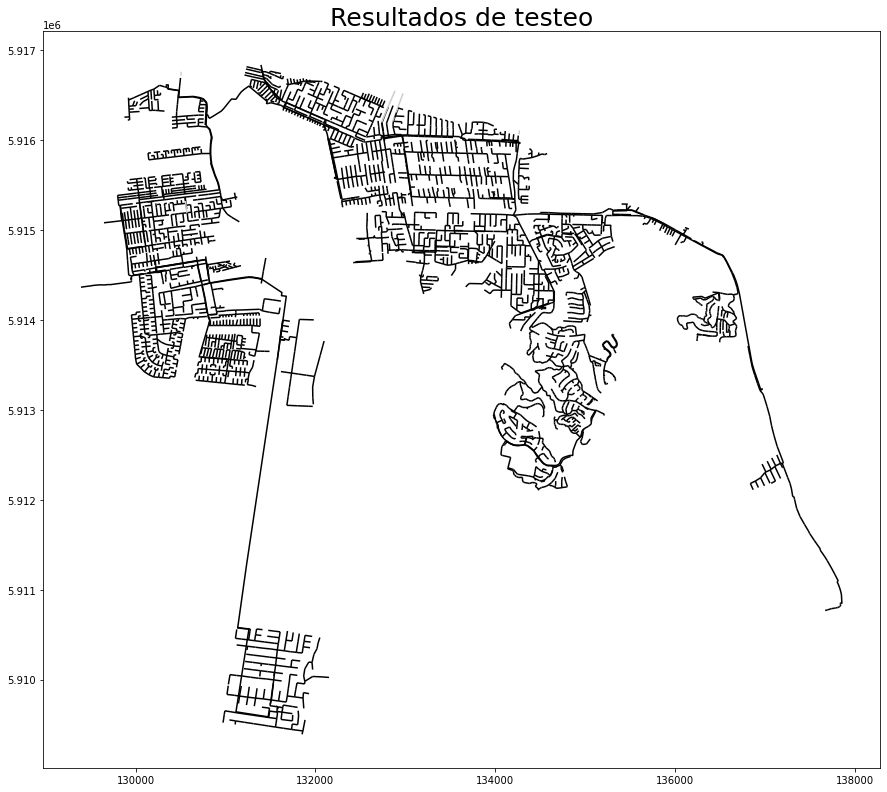

In [11]:
path = 'data/corrected_dijkstra.csv'
geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
geometry['color'] = 10
for u in range(N):
    geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = 0
f, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Resultados de testeo", fontsize=25)
ax = geometry.plot(ax = ax, column = 'color',
            figsize=(15, 15),
            cmap = 'nipy_spectral',)

plt.show()

In [12]:
def plot_sample_tree(G, N, s, sample, geom):
    
    geometry = geom.copy()
    
    ideal = get_ideal(G, [0] * N, s)
    V = [0 if u in ideal else 1 for u in range(N)]
    I = []; C = [-1 * V[u] for u in range(N)]
    
    i = 0
    for u in sample[::-1]:
        ideal = get_ideal(G, V, u)
        for v in ideal:
            V[v] = 1
            C[v] = i
        i += 1

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        if C[u] != -1:
            geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                figsize=(15, 15),
                legend = True,
                legend_kwds={'label': "-1: No considerado \n 0: No cubierto \n 1: Intersección ", 'orientation': "horizontal"},
                cmap = 'nipy_spectral',)
    plt.show()  

In [13]:
V = [0] * N

S = []
for u in range(N):
    S.append((get_size(G, V, N, u), u))

S.sort()

print(S)

[(1, 2), (1, 7), (1, 10), (1, 13), (1, 17), (1, 20), (1, 21), (1, 22), (1, 26), (1, 30), (1, 32), (1, 34), (1, 36), (1, 37), (1, 38), (1, 45), (1, 46), (1, 47), (1, 48), (1, 49), (1, 51), (1, 53), (1, 59), (1, 66), (1, 67), (1, 70), (1, 73), (1, 75), (1, 77), (1, 79), (1, 81), (1, 82), (1, 88), (1, 89), (1, 90), (1, 95), (1, 97), (1, 99), (1, 102), (1, 103), (1, 119), (1, 126), (1, 138), (1, 139), (1, 140), (1, 141), (1, 142), (1, 145), (1, 147), (1, 153), (1, 155), (1, 156), (1, 158), (1, 166), (1, 176), (1, 177), (1, 178), (1, 179), (1, 180), (1, 181), (1, 182), (1, 184), (1, 185), (1, 187), (1, 188), (1, 189), (1, 190), (1, 191), (1, 192), (1, 193), (1, 194), (1, 195), (1, 196), (1, 197), (1, 200), (1, 201), (1, 203), (1, 205), (1, 206), (1, 209), (1, 211), (1, 212), (1, 213), (1, 214), (1, 215), (1, 216), (1, 217), (1, 219), (1, 221), (1, 222), (1, 225), (1, 226), (1, 227), (1, 229), (1, 231), (1, 232), (1, 233), (1, 234), (1, 235), (1, 238), (1, 239), (1, 241), (1, 244), (1, 246),

In [14]:
def hist(sizes):
    bins = np.arange(0, 800, 50) # fixed bin size

    #plt.xlim([min(sizes)-5, max(sizes)+5])

    plt.hist(sizes, bins=bins, alpha=0.5)
    plt.title(f'Histograma de frecuencias de testeo.\n Máximo ideal de {max(sizes)}')
    plt.xlabel('Cantidad de nodos en ideal')
    plt.ylabel('Frecuencia')

    plt.show()

In [15]:
def get_sample_dp(G, N, k, s):
    st = time.time()

    order = get_ideal(G, [0] * N, s)[::-1]

    possibilities = {u: [] for u in order}
    next_dicts = {u: {} for u in order}

    for u in order:

        new_possibilities = set()
        predecessors = list(G.predecessors(u))

        mul = [1 for v in predecessors]; combs = 1 if predecessors else 0
        for i in range(len(predecessors)):
            now = len(possibilities[predecessors[i]])
            for j in range(i):
                mul[j] *= now
            combs *= now

        for i in range(combs):

            indexes = [0 for v in predecessors]
            for j in range(len(predecessors)):
                indexes[j] = (i // mul[j])
                i %= mul[j]

            l = 0; size_left = 1; max_ideal = 0
            for j in range(len(predecessors)):
                pos = possibilities[predecessors[j]][indexes[j]]
                l += pos[0]
                size_left += pos[1]
                max_ideal = max(max_ideal, pos[2])

            if l > k:
                continue

            new_possibilities.add((l, size_left, max_ideal))
            next_dicts[u][(l, size_left, max_ideal)] = indexes
            if l < k:
                new_possibilities.add((l + 1, 0, max(size_left, max_ideal)))
                next_dicts[u][(l + 1, 0, max(size_left, max_ideal))] = indexes

        if combs == 0:
            new_possibilities.add((0, 1, 0))
            next_dicts[u][(0, 1, 0)] = []
            new_possibilities.add((1, 0, 1))
            next_dicts[u][(1, 0, 1)] = []

        possibilities[u] = list(new_possibilities)

    et = time.time()
    print(f"Elapsed: {et - st}")

    mv = 1e10; opt_pos = None
    for pos in possibilities[s]:
        if pos[0] == k and pos[1] == 0:
            now = pos[2]
            if now < mv:
                mv = now
                opt_pos = pos
                
    ans = []
    Q = deque([]); Q.append((s, opt_pos))
    while Q:
        u, pos = Q.popleft()
        l, sm, mi = pos

        if sm == 0:
            ans.append(u)

        i = 0; indexes = next_dicts[u][pos]
        for v in G.predecessors(u):
            next_pos_v = possibilities[v][indexes[i]]
            Q.append((v, next_pos_v)); i += 1

    V = [0] * N; sizes = []
    print("Sizes:", end=" ")
    for u in ans[::-1]:
        V, x = visit(G, V, u)
        print(x, end=" ")
        sizes.append(x)
    
    return ans, sizes

Elapsed: 145.16823172569275
Sizes: 38 41 41 42 38 

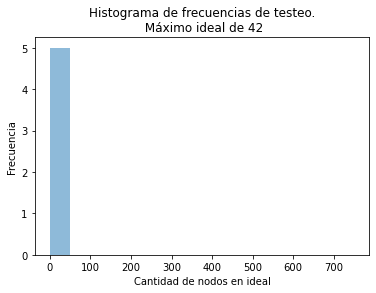

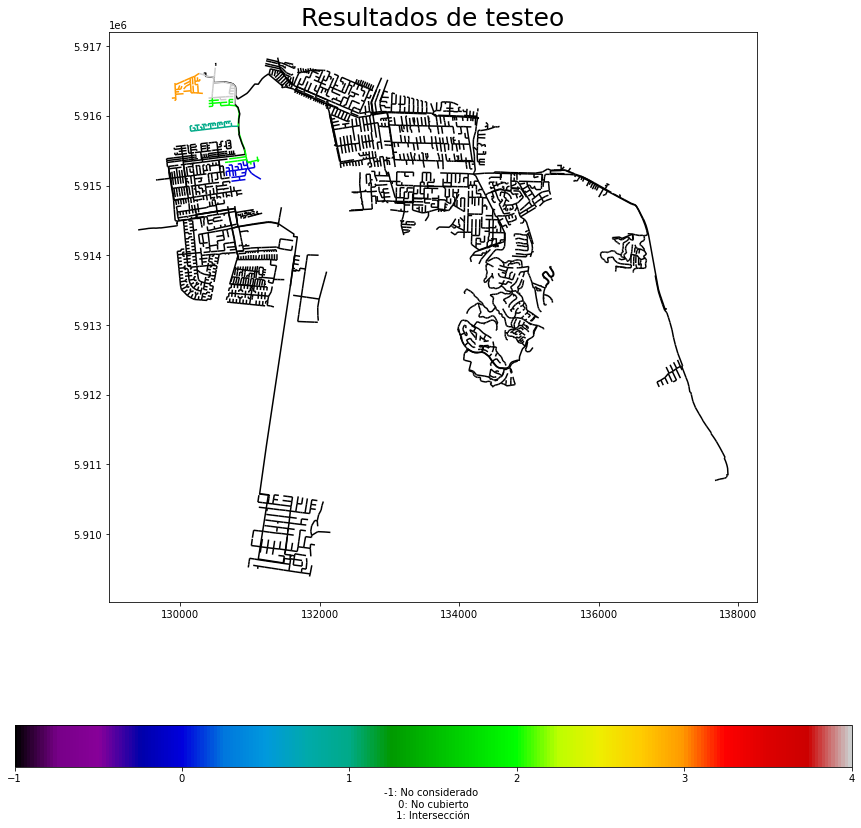

In [15]:
s = 2149; k = 5
sample, sizes = get_sample_dp(G, N, k, s)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

In [14]:
def get_sample_dp_opt(G, N, k, s, limit_l, limit_h):
    st = time.time()

    order = get_ideal(G, [0] * N, s)[::-1]
    size = get_size(G, [0] * N, N, s)

    possibilities = {u: [] for u in order}
    next_dicts = {u: {} for u in order}

    for u in order:

        new_possibilities = set()
        predecessors = list(G.predecessors(u))

        mul = [1 for v in predecessors]; combs = 1 if predecessors else 0
        for i in range(len(predecessors)):
            now = len(possibilities[predecessors[i]])
            for j in range(i):
                mul[j] *= now
            combs *= now
            
        for i in range(combs):

            indexes = [0 for v in predecessors]
            for j in range(len(predecessors)):
                indexes[j] = (i // mul[j])
                i %= mul[j]

            l = 0; size_left = 1; max_ideal = 0
            for j in range(len(predecessors)):
                pos = possibilities[predecessors[j]][indexes[j]]
                l += pos[0]
                size_left += pos[1]
                max_ideal = max(max_ideal, pos[2])

            if l > k or (max_ideal > 0 and max_ideal <= (size / k) * limit_l) or max_ideal > size * limit_h:
                continue

            new_possibilities.add((l, size_left, max_ideal))
            next_dicts[u][(l, size_left, max_ideal)] = indexes
            if l < k and size_left > (size / k) * limit_l and size_left <= size * limit_h:
                new_possibilities.add((l + 1, 0, max(size_left, max_ideal)))
                next_dicts[u][(l + 1, 0, max(size_left, max_ideal))] = indexes

        if combs == 0:
            new_possibilities.add((0, 1, 0))
            next_dicts[u][(0, 1, 0)] = []
            new_possibilities.add((1, 0, 1))
            next_dicts[u][(1, 0, 1)] = []

        possibilities[u] = list(new_possibilities)

    et = time.time()
    print(f"Elapsed: {et - st}")

    mv = 1e10; opt_pos = None
    for pos in possibilities[s]:
        if pos[0] == k and pos[1] == 0:
            now = pos[2]
            if now < mv:
                mv = now
                opt_pos = pos
                
    ans = []
    Q = deque([]); Q.append((s, opt_pos))
    while Q:
        u, pos = Q.popleft()
        l, sm, mi = pos

        if sm == 0:
            ans.append(u)

        i = 0; indexes = next_dicts[u][pos]
        for v in G.predecessors(u):
            next_pos_v = possibilities[v][indexes[i]]
            Q.append((v, next_pos_v)); i += 1

    V = [0] * N; sizes = []
    print("Sizes:", end=" ")
    for u in ans[::-1]:
        V, x = visit(G, V, u)
        print(x, end=" ")
        sizes.append(x)
    
    return ans, sizes

Elapsed: 0.14383816719055176
Sizes: 38 41 38 42 41 

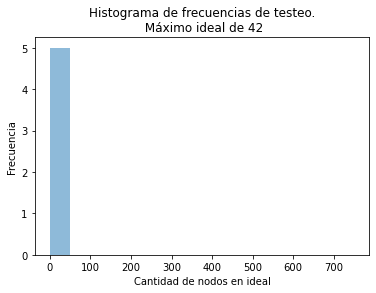

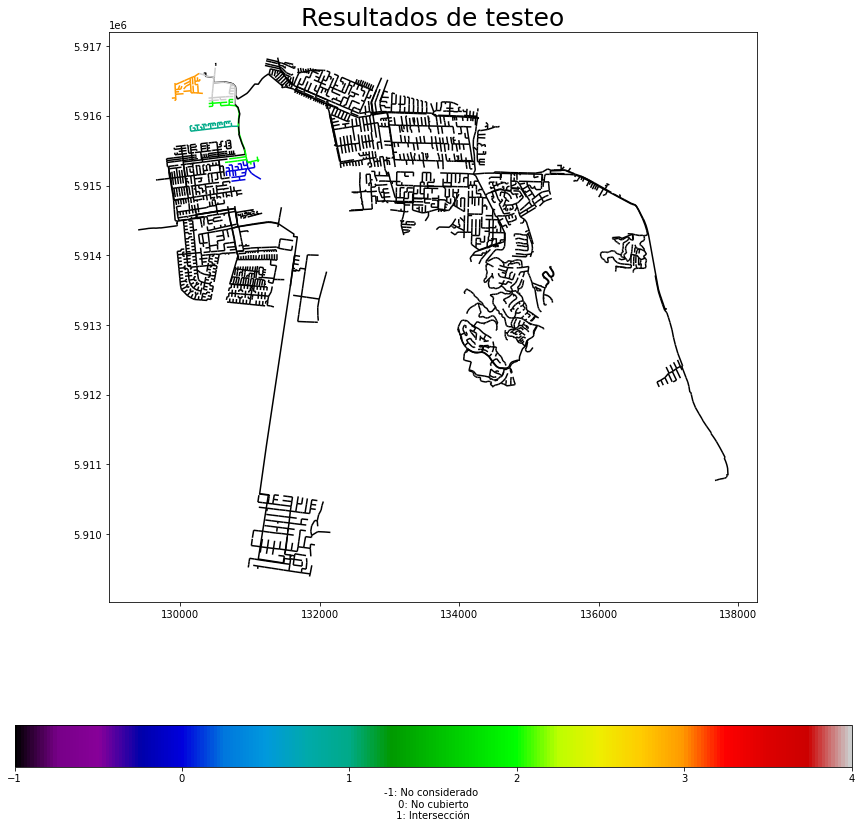

In [17]:
s = 2149; k = 5; p1 = 0.9; p2 = 0.4
sample, sizes = get_sample_dp_opt(G, N, k, s, p1, p2)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

Elapsed: 0.44296717643737793
Sizes: 250 211 282 172 187 

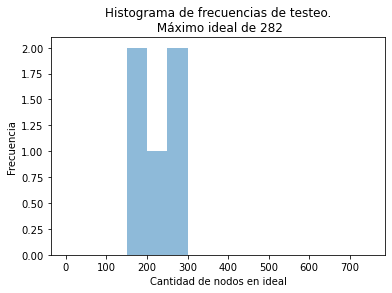

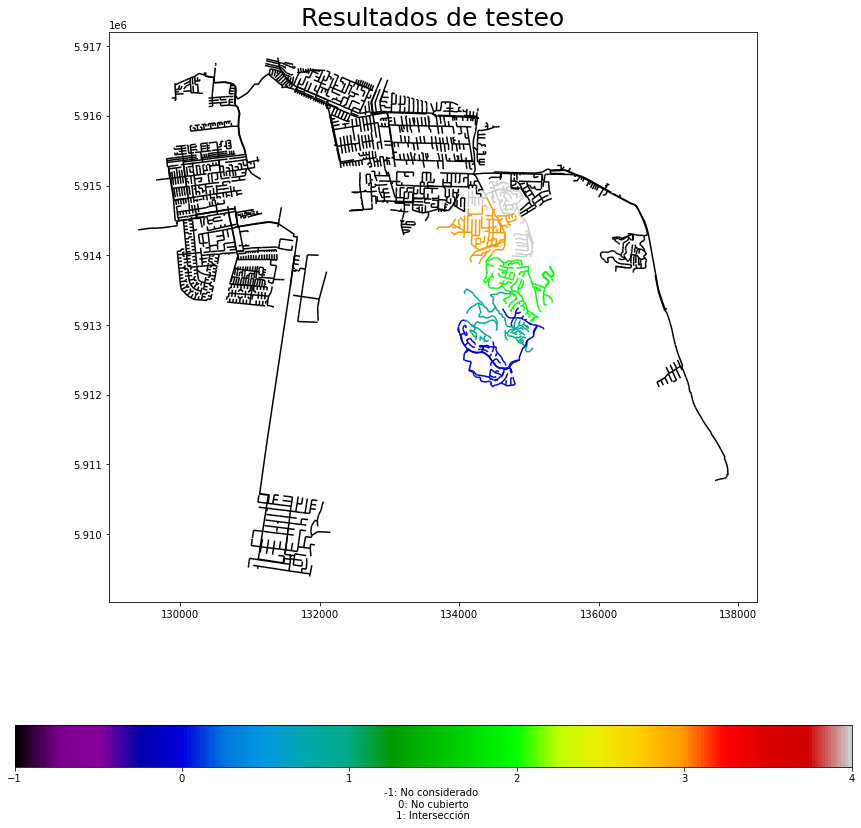

In [18]:
s = 3875; k = 5; p1 = 0.75; p2 = 0.4
sample, sizes = get_sample_dp_opt(G, N, k, s, p1, p2)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

Elapsed: 35.26478695869446
Sizes: 743 483 725 547 465 461 586 562 

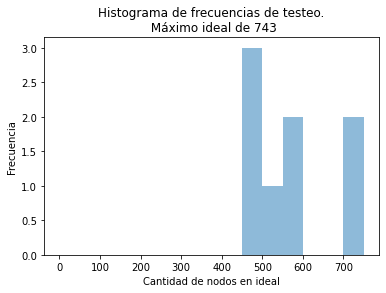

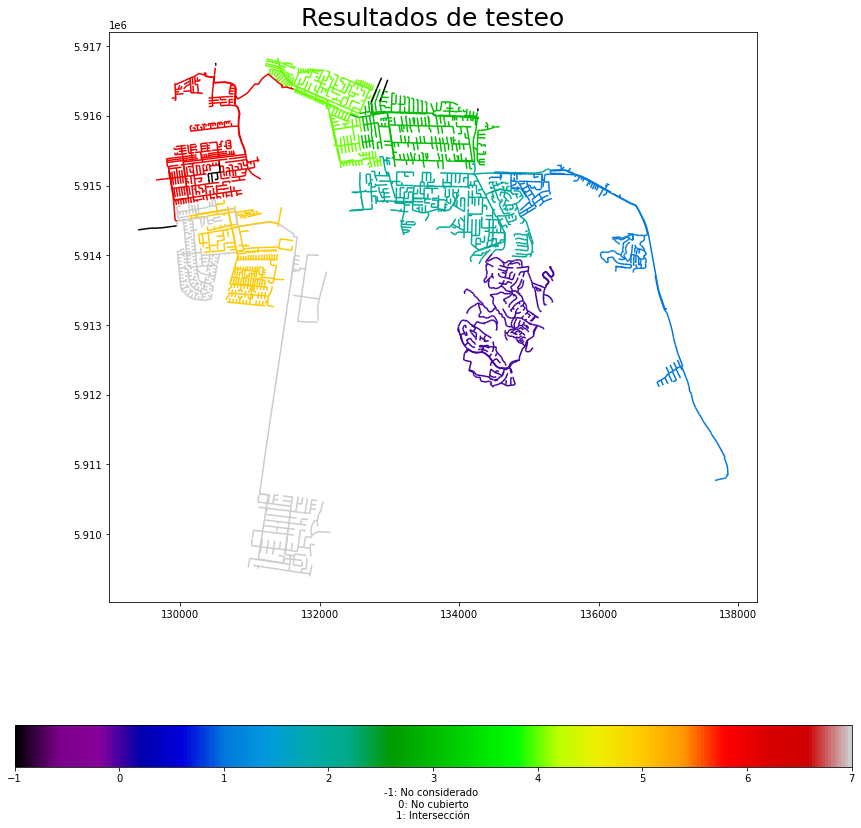

In [20]:
s = 743; k = 8; p1 = 0.8; p2 = 0.2
sample, sizes = get_sample_dp_opt(G, N, k, s, p1, p2)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

In [49]:
def get_sample_dp_reduce_eq(G, N, k, s, mult):
    st = time.time()

    order = get_ideal(G, [0] * N, s)[::-1]
    size = get_size(G, [0] * N, N, s)

    possibilities = {u: [] for u in order}
    next_dicts = {u: {} for u in order}

    for u in order:

        new_possibilities = {}; new_next = {}
        predecessors = list(G.predecessors(u))

        mul = [1 for v in predecessors]; combs = 1 if predecessors else 0
        for i in range(len(predecessors)):
            now = len(possibilities[predecessors[i]])
            for j in range(i):
                mul[j] *= now
            combs *= now
        
        for i in range(combs):

            indexes = [0 for v in predecessors]
            for j in range(len(predecessors)):
                indexes[j] = (i // mul[j])
                i %= mul[j]

            l = 0; size_left = 1; max_ideal = 0; min_ideal = N
            for j in range(len(predecessors)):
                pos = possibilities[predecessors[j]][indexes[j]]
                l += pos[0]
                size_left += pos[1]
                max_ideal = max(max_ideal, pos[2])
                min_ideal = min(min_ideal, pos[3])

            if l > k:
                continue

            if new_possibilities.get((l, max_ideal // mult)):
                prev = new_possibilities[(l, max_ideal // mult)]
                if size_left < prev[0] or (size_left == prev[0] and min_ideal > prev[2]):
                    new_possibilities[(l, max_ideal // mult)] = (size_left, max_ideal, min_ideal)
                    new_next[(l, max_ideal // mult)] = indexes
            else:
                new_possibilities[(l, max_ideal // mult)] = (size_left, max_ideal, min_ideal)
                new_next[(l, max_ideal // mult)] = indexes
                
            if l < k:
                if new_possibilities.get((l + 1, max(size_left, max_ideal) // mult)):
                    prev = new_possibilities[(l + 1, max(size_left, max_ideal) // mult)]
                    if 0 < prev[0] or (0 == prev[0] and min(size_left, min_ideal) > prev[2]):
                        new_possibilities[(l + 1, max(size_left, max_ideal) // mult)] = (0, max(size_left, max_ideal), min(size_left, min_ideal))
                        new_next[(l + 1, max(size_left, max_ideal) // mult)] = indexes
                else:
                    new_possibilities[(l + 1, max(size_left, max_ideal) // mult)] = (0, max(size_left, max_ideal), min(size_left, min_ideal))
                    new_next[(l + 1, max(size_left, max_ideal) // mult)] = indexes

        if combs == 0:
            new_possibilities[(0, 0)] = (1, 0, N)
            new_next[(0, 0)] = []
        
        final_possibilities = set()
        for item in new_possibilities.items():
            o, b = item;
            a = (o[0], b[0], b[1], b[2])
            final_possibilities.add(a)
            next_dicts[u][a] = new_next[o]

        possibilities[u] = list(final_possibilities)

    et = time.time()
    print(f"Elapsed: {et - st}")

    mv = 1e10; opt_pos = None
    for pos in possibilities[s]:
        if pos[0] == k and pos[1] == 0:
            now = pos[2]
            if now < mv:
                mv = now
                opt_pos = pos
                
    ans = []
    Q = deque([]); Q.append((s, opt_pos))
    while Q:
        u, pos = Q.popleft()

        if pos[1] == 0:
            ans.append(u)

        i = 0; indexes = next_dicts[u][pos]
        for v in G.predecessors(u):
            next_pos_v = possibilities[v][indexes[i]]
            Q.append((v, next_pos_v)); i += 1

    V = [0] * N; sizes = []
    print("Sizes:", end=" ")
    for u in ans[::-1]:
        V, x = visit(G, V, u)
        print(x, end=" ")
        sizes.append(x)
    
    return ans, sizes

Elapsed: 21.35230779647827
Sizes: 354 397 399 372 329 341 312 324 365 392 329 397 261 

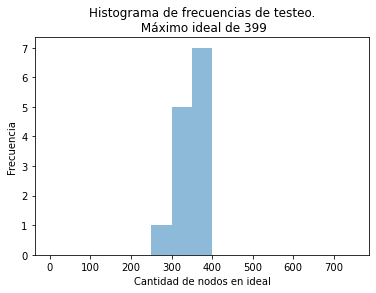

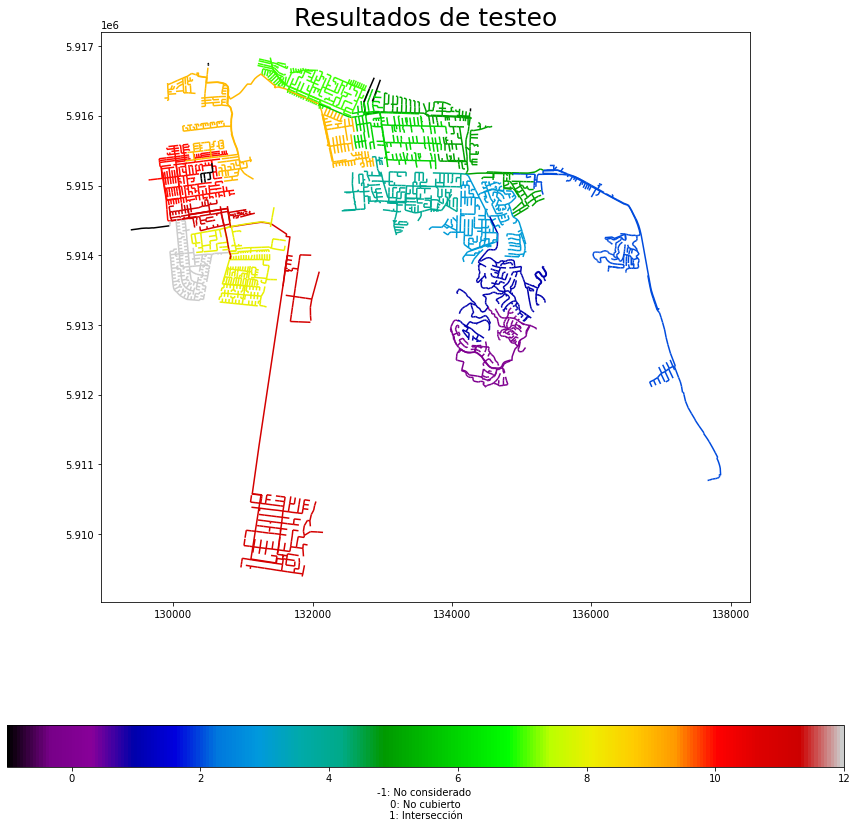

In [29]:
s = 743; k = 13;
sample, sizes = get_sample_dp_reduce_eq(G, N, k, s, 100)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

In [30]:
def get_sample_dp_reduce_cube(G, N, k, s, mult):
    st = time.time()

    order = get_ideal(G, [0] * N, s)[::-1]
    size = get_size(G, [0] * N, N, s)

    possibilities = {u: [] for u in order}
    next_dicts = {u: {} for u in order}

    for u in order:

        new_possibilities = {}; new_next = {}
        predecessors = list(G.predecessors(u))

        mul = [1 for v in predecessors]; combs = 1 if predecessors else 0
        for i in range(len(predecessors)):
            now = len(possibilities[predecessors[i]])
            for j in range(i):
                mul[j] *= now
            combs *= now
        
        for i in range(combs):

            indexes = [0 for v in predecessors]
            for j in range(len(predecessors)):
                indexes[j] = (i // mul[j])
                i %= mul[j]

            l = 0; size_left = 1; max_ideal = 0; score = 0
            for j in range(len(predecessors)):
                pos = possibilities[predecessors[j]][indexes[j]]
                l += pos[0]
                size_left += pos[1]
                max_ideal = max(max_ideal, pos[2])
                score += pos[3]

            if l > k:
                continue

            if new_possibilities.get((l, max_ideal // mult)):
                prev = new_possibilities[(l, max_ideal // mult)]
                if size_left < prev[0] or (size_left == prev[0] and score < prev[2]):
                    new_possibilities[(l, max_ideal // mult)] = (size_left, max_ideal, score)
                    new_next[(l, max_ideal // mult)] = indexes
            else:
                new_possibilities[(l, max_ideal // mult)] = (size_left, max_ideal, score)
                new_next[(l, max_ideal // mult)] = indexes
                
            if l < k:
                if new_possibilities.get((l + 1, max(size_left, max_ideal) // mult)):
                    prev = new_possibilities[(l + 1, max(size_left, max_ideal) // mult)]
                    if 0 < prev[0] or (0 == prev[0] and score + size_left**3 < prev[2]):
                        new_possibilities[(l + 1, max(size_left, max_ideal) // mult)] = (0, max(size_left, max_ideal), score + size_left**3)
                        new_next[(l + 1, max(size_left, max_ideal) // mult)] = indexes
                else:
                    new_possibilities[(l + 1, max(size_left, max_ideal) // mult)] = (0, max(size_left, max_ideal), score + size_left**3)
                    new_next[(l + 1, max(size_left, max_ideal) // mult)] = indexes

        if combs == 0:
            new_possibilities[(0, 0)] = (1, 0, 0)
            new_next[(0, 0)] = []
        
        final_possibilities = set()
        for item in new_possibilities.items():
            o, b = item;
            a = (o[0], b[0], b[1], b[2])
            final_possibilities.add(a)
            next_dicts[u][a] = new_next[o]

        possibilities[u] = list(final_possibilities)

    et = time.time()
    print(f"Elapsed: {et - st}")

    mv = 1e10; opt_pos = None
    for pos in possibilities[s]:
        if pos[0] == k and pos[1] == 0:
            now = pos[2]
            if now < mv:
                mv = now
                opt_pos = pos
                
    ans = []
    Q = deque([]); Q.append((s, opt_pos))
    while Q:
        u, pos = Q.popleft()

        if pos[1] == 0:
            ans.append(u)

        i = 0; indexes = next_dicts[u][pos]
        for v in G.predecessors(u):
            next_pos_v = possibilities[v][indexes[i]]
            Q.append((v, next_pos_v)); i += 1

    V = [0] * N; sizes = []
    print("Sizes:", end=" ")
    for u in ans[::-1]:
        V, x = visit(G, V, u)
        print(x, end=" ")
        sizes.append(x)
    
    return ans, sizes

Elapsed: 0.7646417617797852
Sizes: 38 39 40 42 41 

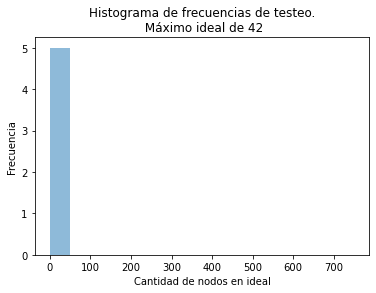

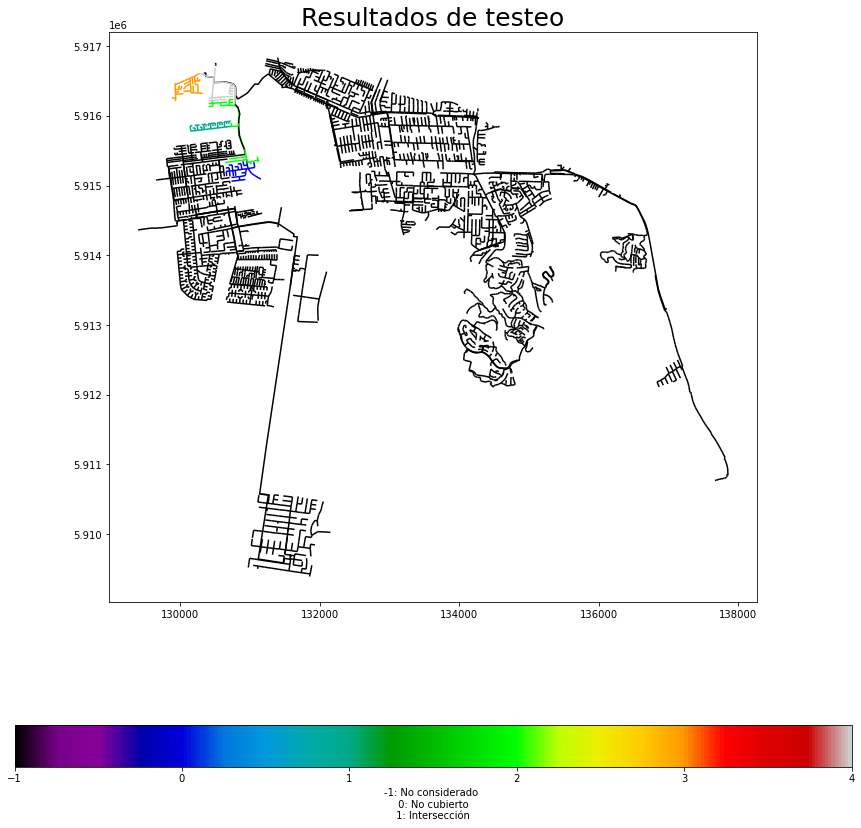

In [31]:
s = 2149; k = 5
sample, sizes = get_sample_dp_reduce_cube(G, N, k, s, 1)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

Elapsed: 2.3331189155578613
Sizes: 229 232 284 196 161 

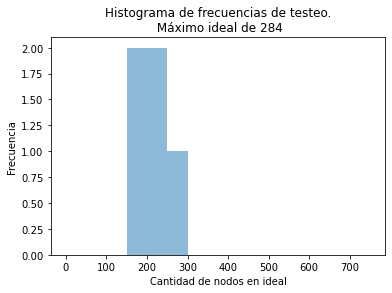

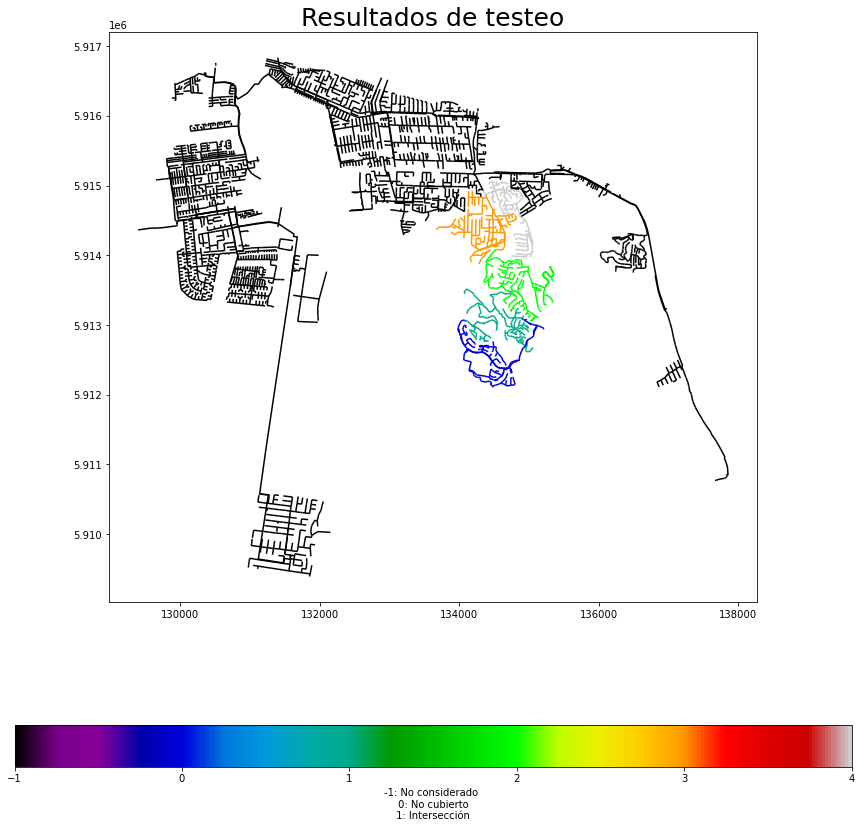

In [32]:
s = 3875; k = 5
sample, sizes = get_sample_dp_reduce_cube(G, N, k, s, 5)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

Elapsed: 18.037182807922363
Sizes: 749 494 708 687 365 623 397 549 

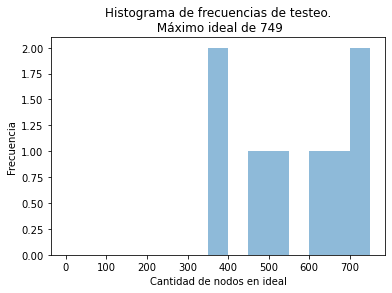

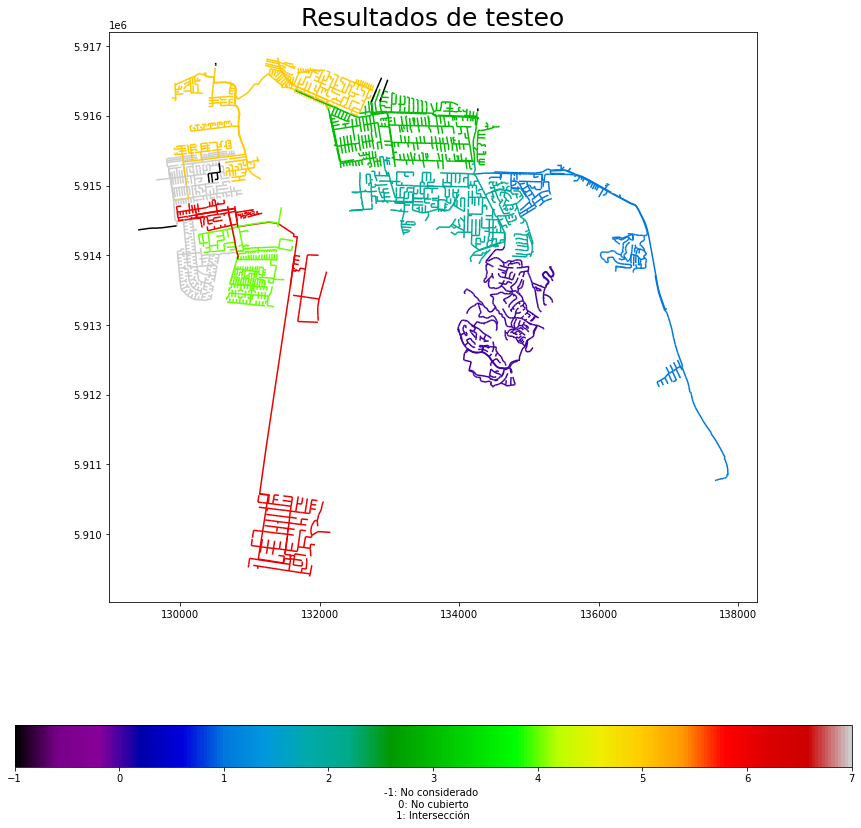

In [33]:
s = 743; k = 8;
sample, sizes = get_sample_dp_reduce_cube(G, N, k, s, 50)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

Elapsed: 18.111521244049072
Sizes: 354 397 399 372 329 341 312 324 365 392 329 397 261 

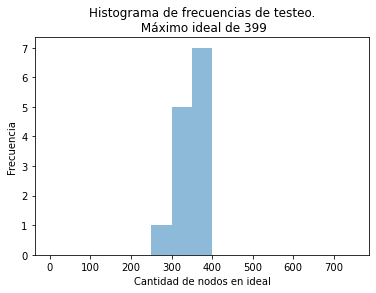

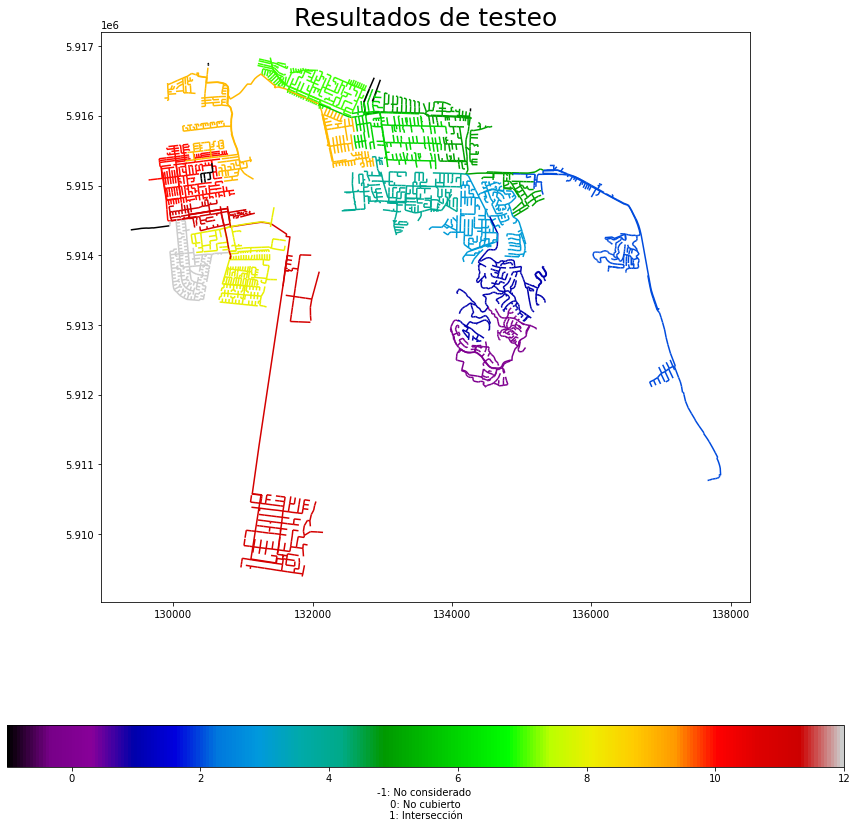

In [34]:
s = 743; k = 13;
sample, sizes = get_sample_dp_reduce_cube(G, N, k, s, 100)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

In [35]:
def get_sample_dp_cube(G, N, k, s):
    st = time.time()

    order = get_ideal(G, [0] * N, s)[::-1]
    size = get_size(G, [0] * N, N, s)

    possibilities = {u: [] for u in order}
    next_dicts = {u: {} for u in order}

    num = 0
    for u in order:

        new_possibilities = {}; new_next = {}
        predecessors = list(G.predecessors(u))

        mul = [1 for v in predecessors]; combs = 1 if predecessors else 0
        for i in range(len(predecessors)):
            now = len(possibilities[predecessors[i]])
            for j in range(i):
                mul[j] *= now
            combs *= now
        
        for i in range(combs):

            indexes = [0 for v in predecessors]
            for j in range(len(predecessors)):
                indexes[j] = (i // mul[j])
                i %= mul[j]

            l = 0; size_left = 1; max_ideal = 0; score = 0
            for j in range(len(predecessors)):
                pos = possibilities[predecessors[j]][indexes[j]]
                l += pos[0]
                size_left += pos[1]
                score += pos[2]

            if l > k:
                continue

            if new_possibilities.get((l, size_left)):
                prev = new_possibilities[(l, size_left)]
                if score < prev:
                    new_possibilities[(l, size_left)] = score
                    new_next[(l, size_left)] = indexes
            else:
                new_possibilities[(l, size_left)] = score
                new_next[(l, size_left)] = indexes
                
            if l < k:
                if new_possibilities.get((l + 1, 0)):
                    prev = new_possibilities[(l + 1, 0)]
                    if score + size_left**3 < prev:
                        new_possibilities[(l + 1, 0)] = score + size_left**3
                        new_next[(l + 1, 0)] = indexes
                else:
                    new_possibilities[(l + 1, 0)] = score + size_left**3
                    new_next[(l + 1, 0)] = indexes

        if combs == 0:
            new_possibilities[(0, 1)] = 0
            new_next[(0, 1)] = []
        
        final_possibilities = set()
        for item in new_possibilities.items():
            o, b = item;
            a = (o[0], o[1], b)
            final_possibilities.add(a)
            next_dicts[u][a] = new_next[o]

        possibilities[u] = list(final_possibilities)
        
        num += 1
        print('\r', end='')
        print((num / size) * 100, "%", end="")

    et = time.time()
    print(f"Elapsed: {et - st}")

    mv = 1e10; opt_pos = None
    for pos in possibilities[s]:
        if pos[0] == k and pos[1] == 0:
            now = pos[2]
            if now < mv:
                mv = now
                opt_pos = pos
                
    ans = []
    Q = deque([]); Q.append((s, opt_pos))
    while Q:
        u, pos = Q.popleft()

        if pos[1] == 0:
            ans.append(u)

        i = 0; indexes = next_dicts[u][pos]
        for v in G.predecessors(u):
            next_pos_v = possibilities[v][indexes[i]]
            Q.append((v, next_pos_v)); i += 1

    V = [0] * N; sizes = []
    print("Sizes:", end=" ")
    for u in ans[::-1]:
        V, x = visit(G, V, u)
        print(x, end=" ")
        sizes.append(x)
    
    return ans, sizes

100.0 %Elapsed: 0.6557762622833252
Sizes: 38 39 40 42 41 

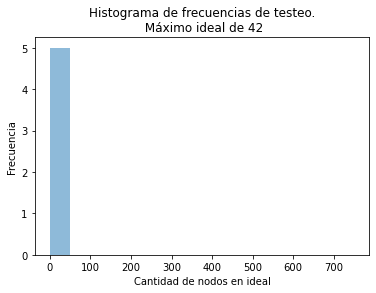

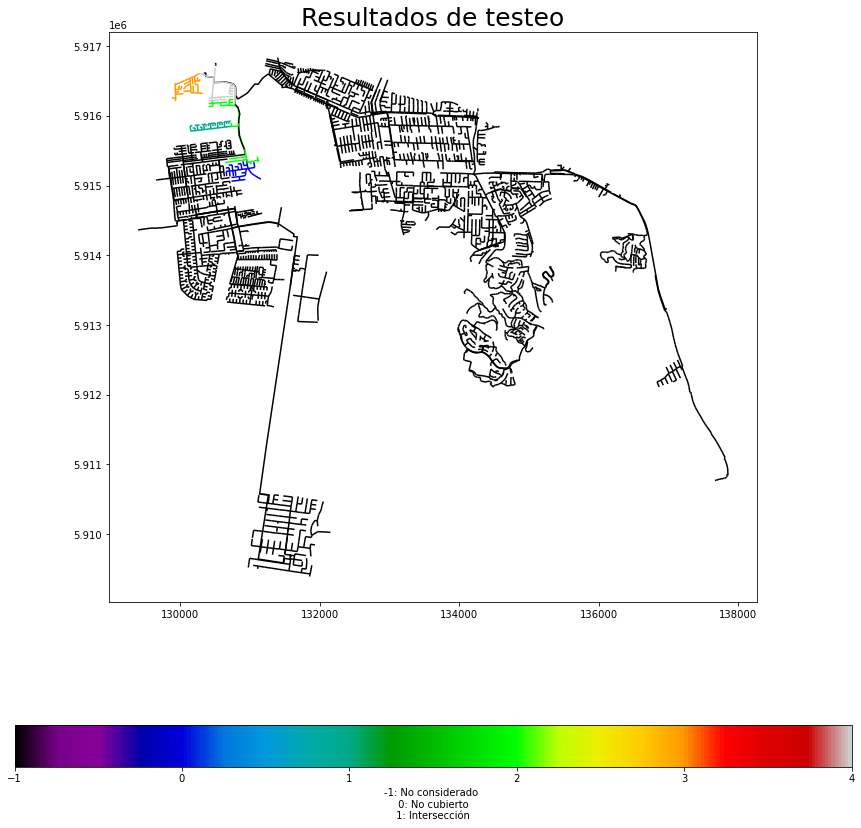

In [36]:
s = 2149; k = 5
sample, sizes = get_sample_dp_cube(G, N, k, s)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

100.0 %Elapsed: 33.72164607048035
Sizes: 229 232 282 172 187 

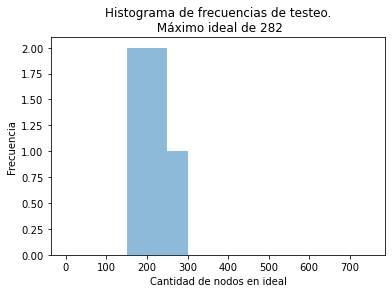

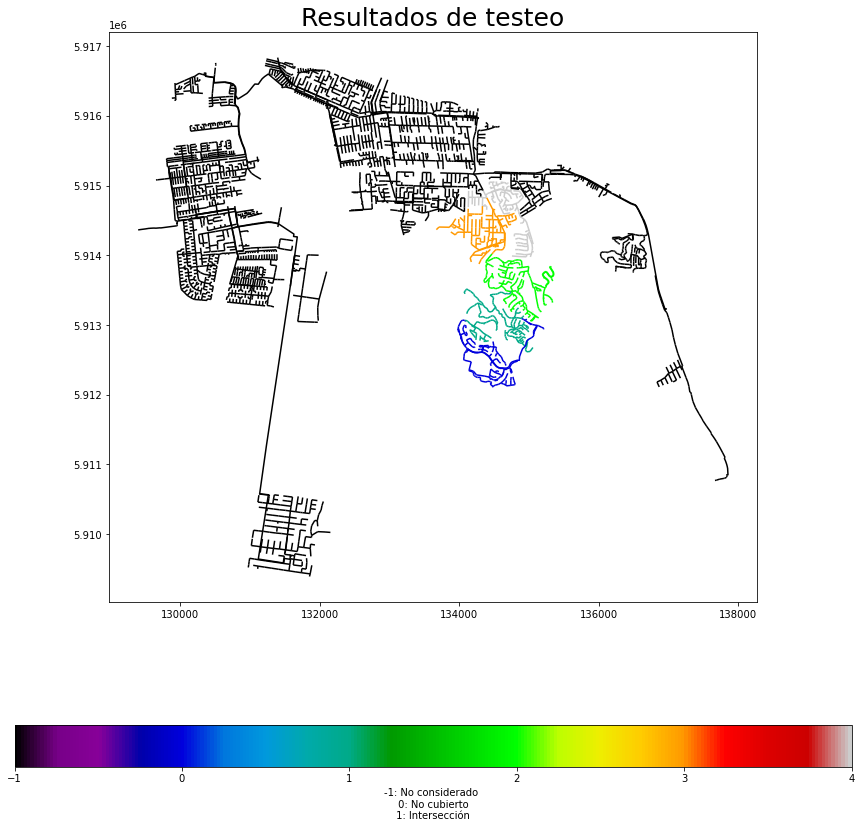

In [37]:
s = 3875; k = 5
sample, sizes = get_sample_dp_cube(G, N, k, s)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

In [38]:
def f_div(size, eps):
    return size * eps

In [39]:
def get_sample_dp_final(G, N, k, s, f_div, eps):
    st = time.time()

    order = get_ideal(G, [0] * N, s)[::-1]
    size = get_size(G, [0] * N, N, s)

    possibilities = {u: [] for u in order}
    next_dicts = {u: {} for u in order}

    for u in order:
        
        mult = f_div(get_size(G, [0] * N, N, u), eps)

        new_possibilities = {}; new_next = {}
        predecessors = list(G.predecessors(u))

        mul = [1 for v in predecessors]; combs = 1 if predecessors else 0
        for i in range(len(predecessors)):
            now = len(possibilities[predecessors[i]])
            for j in range(i):
                mul[j] *= now
            combs *= now
        
        for i in range(combs):

            indexes = [0 for v in predecessors]
            for j in range(len(predecessors)):
                indexes[j] = (i // mul[j])
                i %= mul[j]

            l = 0; size_left = 1; max_ideal = 0; min_ideal = N
            for j in range(len(predecessors)):
                pos = possibilities[predecessors[j]][indexes[j]]
                l += pos[0]
                size_left += pos[1]
                max_ideal = max(max_ideal, pos[2])
                min_ideal = min(min_ideal, pos[3])

            if l > k:
                continue

            if new_possibilities.get((l, max_ideal // mult)):
                prev = new_possibilities[(l, max_ideal // mult)]
                if size_left < prev[0] or (size_left == prev[0] and min_ideal > prev[2]):
                    new_possibilities[(l, max_ideal // mult)] = (size_left, max_ideal, min_ideal)
                    new_next[(l, max_ideal // mult)] = indexes
            else:
                new_possibilities[(l, max_ideal // mult)] = (size_left, max_ideal, min_ideal)
                new_next[(l, max_ideal // mult)] = indexes
                
            if l < k:
                if new_possibilities.get((l + 1, max(size_left, max_ideal) // mult)):
                    prev = new_possibilities[(l + 1, max(size_left, max_ideal) // mult)]
                    if 0 < prev[0] or (0 == prev[0] and min(size_left, min_ideal) > prev[2]):
                        new_possibilities[(l + 1, max(size_left, max_ideal) // mult)] = (0, max(size_left, max_ideal), min(size_left, min_ideal))
                        new_next[(l + 1, max(size_left, max_ideal) // mult)] = indexes
                else:
                    new_possibilities[(l + 1, max(size_left, max_ideal) // mult)] = (0, max(size_left, max_ideal), min(size_left, min_ideal))
                    new_next[(l + 1, max(size_left, max_ideal) // mult)] = indexes

        if combs == 0:
            new_possibilities[(0, 0)] = (1, 0, N)
            new_next[(0, 0)] = []
        
        final_possibilities = set()
        for item in new_possibilities.items():
            o, b = item;
            a = (o[0], b[0], b[1], b[2])
            final_possibilities.add(a)
            next_dicts[u][a] = new_next[o]

        possibilities[u] = list(final_possibilities)

    et = time.time()
    print(f"Elapsed: {et - st}")

    mv = 1e10; opt_pos = None
    for pos in possibilities[s]:
        if pos[0] == k and pos[1] == 0:
            now = pos[2]
            if now < mv:
                mv = now
                opt_pos = pos
                
    ans = []
    Q = deque([]); Q.append((s, opt_pos))
    while Q:
        u, pos = Q.popleft()

        if pos[1] == 0:
            ans.append(u)

        i = 0; indexes = next_dicts[u][pos]
        for v in G.predecessors(u):
            next_pos_v = possibilities[v][indexes[i]]
            Q.append((v, next_pos_v)); i += 1

    V = [0] * N; sizes = []
    print("Sizes:", end=" ")
    for u in ans[::-1]:
        V, x = visit(G, V, u)
        print(x, end=" ")
        sizes.append(x)
    
    return ans, sizes

Elapsed: 12.68248200416565
Sizes: 233 228 283 197 161 

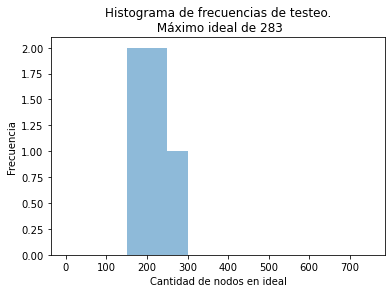

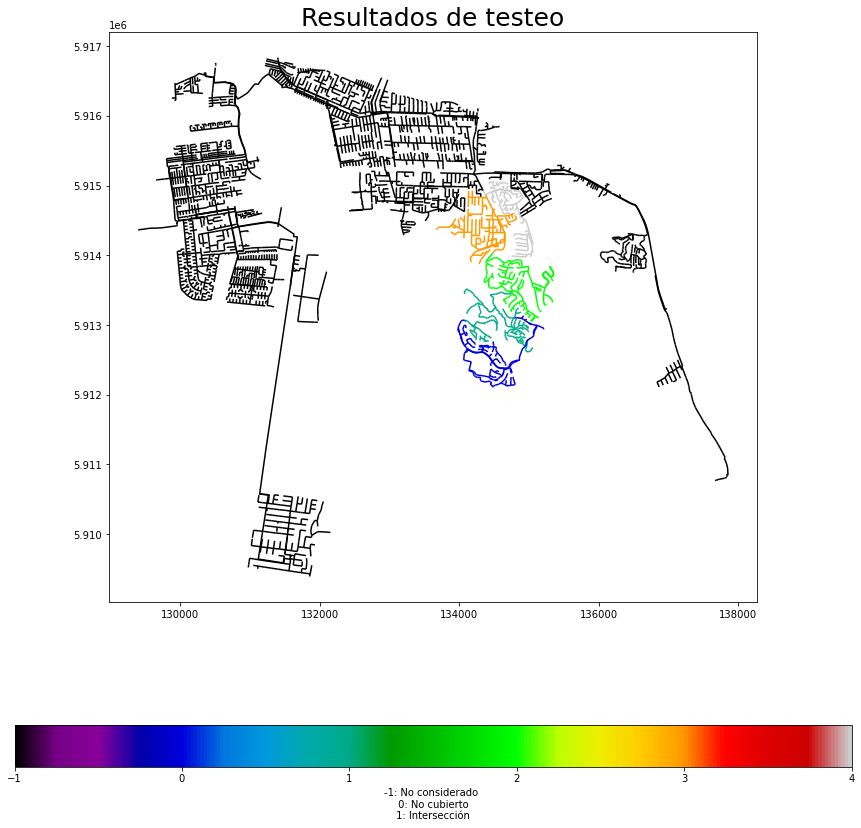

In [40]:
s = 3875; k = 5
sample, sizes = get_sample_dp_final(G, N, k, s, f_div, 0.01)
hist(sizes)
plot_sample_tree(G, N, s, sample, geometry)

In [16]:
def get_dp_table(G, V, N, k, s, mult):

    order = get_ideal(G, V, s)[::-1]
    size = get_size(G, V, N, s)

    possibilities = {u: [] for u in order}
    next_dicts = {u: {} for u in order}

    for u in order:

        new_possibilities = {}; new_next = {}
        predecessors = [v for v in G.predecessors(u) if not V[v]]

        mul = [1 for v in predecessors]; combs = 1 if predecessors else 0
        for i in range(len(predecessors)):
            now = len(possibilities[predecessors[i]])
            for j in range(i):
                mul[j] *= now
            combs *= now
        
        for i in range(combs):

            indexes = [0 for v in predecessors]
            for j in range(len(predecessors)):
                indexes[j] = (i // mul[j])
                i %= mul[j]

            l = 0; size_left = 1; max_ideal = 0; min_ideal = N
            for j in range(len(predecessors)):
                pos = possibilities[predecessors[j]][indexes[j]]
                l += pos[0]
                size_left += pos[1]
                max_ideal = max(max_ideal, pos[2])
                min_ideal = min(min_ideal, pos[3])

            if l >= k:
                continue

            if new_possibilities.get((l, max_ideal // mult)):
                prev = new_possibilities[(l, max_ideal // mult)]
                if size_left < prev[0] or (size_left == prev[0] and min_ideal > prev[2]):
                    new_possibilities[(l, max_ideal // mult)] = (size_left, max_ideal, min_ideal)
                    new_next[(l, max_ideal // mult)] = indexes
            else:
                new_possibilities[(l, max_ideal // mult)] = (size_left, max_ideal, min_ideal)
                new_next[(l, max_ideal // mult)] = indexes
                
            if l < k:
                if new_possibilities.get((l + 1, max(size_left, max_ideal) // mult)):
                    prev = new_possibilities[(l + 1, max(size_left, max_ideal) // mult)]
                    if 0 < prev[0] or (0 == prev[0] and min(size_left, min_ideal) > prev[2]):
                        new_possibilities[(l + 1, max(size_left, max_ideal) // mult)] = (0, max(size_left, max_ideal), min(size_left, min_ideal))
                        new_next[(l + 1, max(size_left, max_ideal) // mult)] = indexes
                else:
                    new_possibilities[(l + 1, max(size_left, max_ideal) // mult)] = (0, max(size_left, max_ideal), min(size_left, min_ideal))
                    new_next[(l + 1, max(size_left, max_ideal) // mult)] = indexes

        if combs == 0:
            new_possibilities[(0, 0)] = (1, 0, N)
            new_next[(0, 0)] = []
            new_possibilities[(1, 0)] = (0, 1, 1)
            new_next[(1, 0)] = []
        
        final_possibilities = set()
        for item in new_possibilities.items():
            o, b = item;
            a = (o[0], b[0], b[1], b[2])
            final_possibilities.add(a)
            next_dicts[u][a] = new_next[o]

        possibilities[u] = list(final_possibilities)

    return possibilities, next_dicts

In [17]:
def get_sample_from_table(possibilities, next_dicts, V, k, s):
    
    mv = 1e10; opt_pos = None
    for pos in possibilities[s]:
        if pos[0] == k and pos[1] == 0:
            now = pos[2]
            if now < mv:
                mv = now
                opt_pos = pos
                
    ans = []
    Q = deque([]); Q.append((s, opt_pos))
    while Q:
        u, pos = Q.popleft()

        if pos[1] == 0:
            ans.append(u)

        i = 0; indexes = next_dicts[u][pos]

        predecessors = [v for v in G.predecessors(u) if not V[v]]
        
        for v in predecessors:
            next_pos_v = possibilities[v][indexes[i]]
            Q.append((v, next_pos_v)); i += 1

    V_ = [0] * N; sizes = []
    for u in ans[::-1]:
        V_, x = visit(G, V_, u)
        sizes.append(x)
    
    return ans, sizes

In [18]:
init_possibilities, init_next_dicts = get_dp_table(G, [0] * N, N, 8, 743, 25)

# Simulación

In [27]:
def simulate(G, N):
    T = []

    for r in range(N):
        CV = [0 for u in range(N)]

        CV[r] = 1
        Q = deque([]); Q.append(r)
        while Q:
            u = Q.popleft()
            for v in G.successors(u):
                if not CV[v]:
                    CV[v] = 1
                    Q.append(v)

        V = [0 for u in range(N)]

        R = N; s = 743; k_list = [8, 5, 3, 2]
        for t in range(100):
            P = []; k = 2
            if t < 4:
                k = k_list[t]
            if t == 0:
                P, _ = get_sample_from_table(init_possibilities, init_next_dicts, V, k, s)
            elif N - sum(V) > 200:
                new_possibilities, new_next_dicts = get_dp_table(G, V, N, k, s, 20)
                P, _ = get_sample_from_table(new_possibilities, new_next_dicts, V, k, s)
            elif N - sum(V) > 10:
                new_possibilities, new_next_dicts = get_dp_table(G, V, N, k, s, 10)
                P, _ = get_sample_from_table(new_possibilities, new_next_dicts, V, k, s)
            else:
                new_possibilities, new_next_dicts = get_dp_table(G, V, N, min(k, N - sum(V)), s, 1)
                P, _ = get_sample_from_table(new_possibilities, new_next_dicts, V, min(k, N - sum(V)), s)
                
            for u in P[::-1]:
                if CV[u]:
                    I = set(get_ideal(G, V, u)[::-1])
                    V = [not (v in I) for v in range(N)]
                    s = u; break
                else:
                    V, _ = visit(G, V, u)

            size, weight = get_size_weight(G, V, N, s)

            if size == 1 or weight <= 200:
                T.append(t + 1)
                print(f"Result {r}: {T[-1]}    acc: {sum(T) / (r + 1)}")
                break
            if t == 99:
                T.append(100)
                print(f"Result {r}: {T[-1]}    acc: {sum(T) / (r + 1)}")

    print(sum(T) / len(T), max(T))
    
    return T


In [28]:
def hist_results(T):
    
    mx = max(T)
    bins = [b - 0.5 for b in range(1, mx + 1)]

    plt.figure(figsize=(10, 5))
    plt.hist(T, bins=bins)
    plt.xticks([b for b in range(1, mx + 1)])
    plt.xlim([0.5, mx + .5])
    plt.show()

In [29]:
T = simulate(G, N)

Result 0: 7    acc: 7.0
Result 1: 7    acc: 7.0
Result 2: 7    acc: 7.0
Result 3: 7    acc: 7.0
Result 4: 7    acc: 7.0
Result 5: 7    acc: 7.0
Result 6: 7    acc: 7.0
Result 7: 7    acc: 7.0
Result 8: 7    acc: 7.0
Result 9: 7    acc: 7.0
Result 10: 7    acc: 7.0
Result 11: 6    acc: 6.916666666666667
Result 12: 6    acc: 6.846153846153846
Result 13: 6    acc: 6.785714285714286
Result 14: 1    acc: 6.4
Result 15: 1    acc: 6.0625
Result 16: 1    acc: 5.764705882352941
Result 17: 1    acc: 5.5
Result 18: 1    acc: 5.2631578947368425
Result 19: 5    acc: 5.25
Result 20: 5    acc: 5.238095238095238
Result 21: 6    acc: 5.2727272727272725
Result 22: 6    acc: 5.304347826086956
Result 23: 6    acc: 5.333333333333333
Result 24: 1    acc: 5.16
Result 25: 7    acc: 5.230769230769231
Result 26: 7    acc: 5.296296296296297
Result 27: 7    acc: 5.357142857142857
Result 28: 5    acc: 5.344827586206897
Result 29: 8    acc: 5.433333333333334
Result 30: 8    acc: 5.516129032258065
Result 31: 5    ac

Result 220: 7    acc: 6.276018099547511
Result 221: 5    acc: 6.27027027027027
Result 222: 5    acc: 6.26457399103139
Result 223: 5    acc: 6.258928571428571
Result 224: 7    acc: 6.262222222222222
Result 225: 7    acc: 6.265486725663717
Result 226: 10    acc: 6.28193832599119
Result 227: 8    acc: 6.2894736842105265
Result 228: 8    acc: 6.296943231441048
Result 229: 7    acc: 6.3
Result 230: 7    acc: 6.303030303030303
Result 231: 7    acc: 6.306034482758621
Result 232: 6    acc: 6.304721030042918
Result 233: 5    acc: 6.299145299145299
Result 234: 5    acc: 6.293617021276596
Result 235: 6    acc: 6.2923728813559325
Result 236: 5    acc: 6.286919831223629
Result 237: 5    acc: 6.281512605042017
Result 238: 3    acc: 6.2677824267782425
Result 239: 6    acc: 6.266666666666667
Result 240: 4    acc: 6.257261410788382
Result 241: 5    acc: 6.25206611570248
Result 242: 3    acc: 6.238683127572016
Result 243: 6    acc: 6.237704918032787
Result 244: 6    acc: 6.236734693877551
Result 245: 7 

Result 428: 3    acc: 5.671328671328672
Result 429: 5    acc: 5.669767441860465
Result 430: 5    acc: 5.6682134570765665
Result 431: 8    acc: 5.673611111111111
Result 432: 6    acc: 5.674364896073903
Result 433: 6    acc: 5.675115207373272
Result 434: 3    acc: 5.6689655172413795
Result 435: 6    acc: 5.669724770642202
Result 436: 7    acc: 5.672768878718536
Result 437: 7    acc: 5.675799086757991
Result 438: 6    acc: 5.676537585421412
Result 439: 5    acc: 5.675
Result 440: 5    acc: 5.673469387755102
Result 441: 7    acc: 5.676470588235294
Result 442: 5    acc: 5.6749435665914225
Result 443: 8    acc: 5.68018018018018
Result 444: 6    acc: 5.680898876404495
Result 445: 7    acc: 5.683856502242152
Result 446: 6    acc: 5.684563758389261
Result 447: 4    acc: 5.680803571428571
Result 448: 4    acc: 5.67706013363029
Result 449: 4    acc: 5.673333333333333
Result 450: 4    acc: 5.669623059866963
Result 451: 4    acc: 5.665929203539823
Result 452: 4    acc: 5.662251655629139
Result 453:

Result 637: 5    acc: 5.768025078369906
Result 638: 5    acc: 5.766823161189358
Result 639: 3    acc: 5.7625
Result 640: 3    acc: 5.758190327613105
Result 641: 3    acc: 5.753894080996885
Result 642: 3    acc: 5.749611197511664
Result 643: 3    acc: 5.745341614906832
Result 644: 5    acc: 5.744186046511628
Result 645: 5    acc: 5.743034055727554
Result 646: 5    acc: 5.741885625965997
Result 647: 7    acc: 5.743827160493828
Result 648: 3    acc: 5.73959938366718
Result 649: 3    acc: 5.735384615384615
Result 650: 3    acc: 5.731182795698925
Result 651: 6    acc: 5.7315950920245395
Result 652: 8    acc: 5.735068912710567
Result 653: 3    acc: 5.730886850152905
Result 654: 4    acc: 5.72824427480916
Result 655: 3    acc: 5.724085365853658
Result 656: 8    acc: 5.7275494672754945
Result 657: 8    acc: 5.731003039513678
Result 658: 4    acc: 5.728376327769348
Result 659: 4    acc: 5.725757575757576
Result 660: 4    acc: 5.723146747352496
Result 661: 4    acc: 5.720543806646526
Result 662:

Result 844: 8    acc: 5.6520710059171595
Result 845: 8    acc: 5.6548463356974
Result 846: 8    acc: 5.657615112160567
Result 847: 7    acc: 5.659198113207547
Result 848: 5    acc: 5.658421672555948
Result 849: 8    acc: 5.661176470588235
Result 850: 8    acc: 5.663924794359577
Result 851: 8    acc: 5.666666666666667
Result 852: 7    acc: 5.668229777256741
Result 853: 8    acc: 5.67096018735363
Result 854: 7    acc: 5.6725146198830405
Result 855: 5    acc: 5.671728971962617
Result 856: 5    acc: 5.670945157526254
Result 857: 5    acc: 5.67016317016317
Result 858: 5    acc: 5.669383003492433
Result 859: 5    acc: 5.6686046511627906
Result 860: 5    acc: 5.667828106852497
Result 861: 5    acc: 5.667053364269141
Result 862: 5    acc: 5.666280417149479
Result 863: 5    acc: 5.6655092592592595
Result 864: 5    acc: 5.664739884393064
Result 865: 5    acc: 5.6639722863741335
Result 866: 7    acc: 5.665513264129181
Result 867: 6    acc: 5.6658986175115205
Result 868: 8    acc: 5.66858457997698

Result 1049: 5    acc: 5.555238095238095
Result 1050: 5    acc: 5.554709800190295
Result 1051: 5    acc: 5.554182509505703
Result 1052: 5    acc: 5.553656220322887
Result 1053: 5    acc: 5.553130929791271
Result 1054: 5    acc: 5.55260663507109
Result 1055: 3    acc: 5.550189393939394
Result 1056: 5    acc: 5.549668874172186
Result 1057: 5    acc: 5.549149338374291
Result 1058: 5    acc: 5.548630783758263
Result 1059: 5    acc: 5.5481132075471695
Result 1060: 5    acc: 5.547596606974552
Result 1061: 5    acc: 5.547080979284369
Result 1062: 8    acc: 5.549388523047978
Result 1063: 5    acc: 5.548872180451128
Result 1064: 3    acc: 5.546478873239437
Result 1065: 7    acc: 5.547842401500938
Result 1066: 5    acc: 5.547328959700094
Result 1067: 5    acc: 5.546816479400749
Result 1068: 7    acc: 5.5481758652946676
Result 1069: 6    acc: 5.548598130841121
Result 1070: 5    acc: 5.548085901027077
Result 1071: 5    acc: 5.547574626865671
Result 1072: 5    acc: 5.547064305684995
Result 1073: 5 

Result 1251: 6    acc: 5.535942492012779
Result 1252: 6    acc: 5.5363128491620115
Result 1253: 6    acc: 5.536682615629984
Result 1254: 6    acc: 5.537051792828685
Result 1255: 5    acc: 5.536624203821656
Result 1256: 5    acc: 5.536197295147176
Result 1257: 5    acc: 5.53577106518283
Result 1258: 5    acc: 5.535345512311358
Result 1259: 5    acc: 5.534920634920635
Result 1260: 5    acc: 5.534496431403648
Result 1261: 5    acc: 5.5340729001584785
Result 1262: 5    acc: 5.533650039588282
Result 1263: 7    acc: 5.534810126582278
Result 1264: 7    acc: 5.53596837944664
Result 1265: 7    acc: 5.5371248025276465
Result 1266: 7    acc: 5.538279400157853
Result 1267: 7    acc: 5.539432176656152
Result 1268: 7    acc: 5.540583136327817
Result 1269: 8    acc: 5.54251968503937
Result 1270: 8    acc: 5.544453186467349
Result 1271: 6    acc: 5.544811320754717
Result 1272: 6    acc: 5.545168892380204
Result 1273: 6    acc: 5.54552590266876
Result 1274: 7    acc: 5.546666666666667
Result 1275: 7   

Result 1453: 5    acc: 5.547455295735901
Result 1454: 5    acc: 5.547079037800687
Result 1455: 5    acc: 5.5467032967032965
Result 1456: 5    acc: 5.546328071379547
Result 1457: 5    acc: 5.545953360768175
Result 1458: 6    acc: 5.54626456477039
Result 1459: 5    acc: 5.545890410958904
Result 1460: 6    acc: 5.546201232032854
Result 1461: 6    acc: 5.546511627906977
Result 1462: 6    acc: 5.546821599453178
Result 1463: 5    acc: 5.546448087431694
Result 1464: 5    acc: 5.546075085324232
Result 1465: 5    acc: 5.545702592087312
Result 1466: 5    acc: 5.5453306066803
Result 1467: 5    acc: 5.544959128065395
Result 1468: 5    acc: 5.544588155207625
Result 1469: 6    acc: 5.544897959183674
Result 1470: 6    acc: 5.545207341944256
Result 1471: 6    acc: 5.545516304347826
Result 1472: 6    acc: 5.545824847250509
Result 1473: 5    acc: 5.545454545454546
Result 1474: 5    acc: 5.545084745762712
Result 1475: 5    acc: 5.544715447154472
Result 1476: 8    acc: 5.54637779282329
Result 1477: 8    a

Result 1655: 7    acc: 5.543478260869565
Result 1656: 7    acc: 5.544357272178636
Result 1657: 7    acc: 5.545235223160434
Result 1658: 7    acc: 5.5461121157323685
Result 1659: 7    acc: 5.546987951807229
Result 1660: 7    acc: 5.547862733293197
Result 1661: 7    acc: 5.548736462093863
Result 1662: 8    acc: 5.550210463018641
Result 1663: 7    acc: 5.551081730769231
Result 1664: 7    acc: 5.551951951951952
Result 1665: 7    acc: 5.552821128451381
Result 1666: 7    acc: 5.553689262147571
Result 1667: 7    acc: 5.554556354916067
Result 1668: 7    acc: 5.555422408627921
Result 1669: 7    acc: 5.5562874251497005
Result 1670: 7    acc: 5.557151406343507
Result 1671: 7    acc: 5.5580143540669855
Result 1672: 6    acc: 5.55827854154214
Result 1673: 6    acc: 5.558542413381123
Result 1674: 6    acc: 5.558805970149254
Result 1675: 5    acc: 5.558472553699284
Result 1676: 6    acc: 5.558735837805605
Result 1677: 6    acc: 5.558998808104887
Result 1678: 5    acc: 5.55866587254318
Result 1679: 5 

Result 1855: 7    acc: 5.594827586206897
Result 1856: 5    acc: 5.594507269789984
Result 1857: 6    acc: 5.594725511302475
Result 1858: 5    acc: 5.594405594405594
Result 1859: 5    acc: 5.594086021505376
Result 1860: 5    acc: 5.593766792047286
Result 1861: 5    acc: 5.593447905477981
Result 1862: 7    acc: 5.594202898550725
Result 1863: 8    acc: 5.59549356223176
Result 1864: 6    acc: 5.595710455764075
Result 1865: 5    acc: 5.595391211146838
Result 1866: 7    acc: 5.596143545795393
Result 1867: 6    acc: 5.5963597430406855
Result 1868: 7    acc: 5.597110754414126
Result 1869: 5    acc: 5.596791443850267
Result 1870: 5    acc: 5.596472474612507
Result 1871: 6    acc: 5.596688034188034
Result 1872: 6    acc: 5.596903363587827
Result 1873: 6    acc: 5.5971184631803625
Result 1874: 6    acc: 5.597333333333333
Result 1875: 6    acc: 5.597547974413646
Result 1876: 6    acc: 5.597762386787426
Result 1877: 4    acc: 5.596911608093717
Result 1878: 4    acc: 5.596061734965407
Result 1879: 4 

Result 2057: 5    acc: 5.626822157434402
Result 2058: 5    acc: 5.626517727051967
Result 2059: 5    acc: 5.62621359223301
Result 2060: 5    acc: 5.625909752547307
Result 2061: 6    acc: 5.626091173617847
Result 2062: 6    acc: 5.626272418807562
Result 2063: 6    acc: 5.626453488372093
Result 2064: 6    acc: 5.626634382566586
Result 2065: 6    acc: 5.626815101645692
Result 2066: 6    acc: 5.626995645863571
Result 2067: 6    acc: 5.6271760154738875
Result 2068: 9    acc: 5.6288061865635575
Result 2069: 9    acc: 5.630434782608695
Result 2070: 4    acc: 5.629647513278609
Result 2071: 4    acc: 5.628861003861004
Result 2072: 4    acc: 5.62807525325615
Result 2073: 6    acc: 5.628254580520733
Result 2074: 6    acc: 5.628433734939759
Result 2075: 6    acc: 5.628612716763006
Result 2076: 6    acc: 5.628791526239769
Result 2077: 5    acc: 5.628488931665062
Result 2078: 8    acc: 5.62962962962963
Result 2079: 8    acc: 5.630769230769231
Result 2080: 5    acc: 5.630466122056704
Result 2081: 5   

Result 2258: 6    acc: 5.530323151837096
Result 2259: 5    acc: 5.530088495575221
Result 2260: 5    acc: 5.529854046881911
Result 2261: 6    acc: 5.530061892130858
Result 2262: 5    acc: 5.529827662395051
Result 2263: 6    acc: 5.530035335689046
Result 2264: 6    acc: 5.530242825607064
Result 2265: 6    acc: 5.53045013239188
Result 2266: 6    acc: 5.53065725628584
Result 2267: 6    acc: 5.530864197530864
Result 2268: 5    acc: 5.530630233583076
Result 2269: 6    acc: 5.530837004405286
Result 2270: 6    acc: 5.5310435931307795
Result 2271: 7    acc: 5.53169014084507
Result 2272: 7    acc: 5.53233611966564
Result 2273: 7    acc: 5.532981530343008
Result 2274: 7    acc: 5.533626373626373
Result 2275: 6    acc: 5.533831282952549
Result 2276: 7    acc: 5.534475186649099
Result 2277: 6    acc: 5.534679543459175
Result 2278: 7    acc: 5.535322509872751
Result 2279: 6    acc: 5.535526315789474
Result 2280: 6    acc: 5.5357299430074525
Result 2281: 5    acc: 5.535495179666959
Result 2282: 5    

Result 2459: 3    acc: 5.496341463414634
Result 2460: 4    acc: 5.49573344169037
Result 2461: 3    acc: 5.49471974004874
Result 2462: 3    acc: 5.493706861550955
Result 2463: 3    acc: 5.492694805194805
Result 2464: 3    acc: 5.491683569979716
Result 2465: 3    acc: 5.490673154906731
Result 2466: 3    acc: 5.489663558978516
Result 2467: 3    acc: 5.488654781199352
Result 2468: 3    acc: 5.487646820575131
Result 2469: 3    acc: 5.48663967611336
Result 2470: 3    acc: 5.485633346823149
Result 2471: 3    acc: 5.48462783171521
Result 2472: 3    acc: 5.4836231298018605
Result 2473: 3    acc: 5.482619240097009
Result 2474: 3    acc: 5.481616161616162
Result 2475: 3    acc: 5.480613893376414
Result 2476: 3    acc: 5.479612434396447
Result 2477: 3    acc: 5.47861178369653
Result 2478: 6    acc: 5.478822105687778
Result 2479: 3    acc: 5.477822580645161
Result 2480: 3    acc: 5.476823861346231
Result 2481: 3    acc: 5.475825946817083
Result 2482: 3    acc: 5.474828836085381
Result 2483: 3    ac

Result 2660: 6    acc: 5.410747839158211
Result 2661: 6    acc: 5.410969196093163
Result 2662: 5    acc: 5.410814870446864
Result 2663: 5    acc: 5.41066066066066
Result 2664: 6    acc: 5.410881801125703
Result 2665: 6    acc: 5.411102775693924
Result 2666: 6    acc: 5.411323584551931
Result 2667: 6    acc: 5.411544227886057
Result 2668: 6    acc: 5.411764705882353
Result 2669: 4    acc: 5.4112359550561795
Result 2670: 6    acc: 5.411456383377012
Result 2671: 4    acc: 5.4109281437125745
Result 2672: 6    acc: 5.411148522259634
Result 2673: 6    acc: 5.411368735976065
Result 2674: 5    acc: 5.411214953271028
Result 2675: 5    acc: 5.411061285500748
Result 2676: 7    acc: 5.41165483750467
Result 2677: 8    acc: 5.412621359223301
Result 2678: 10    acc: 5.414333706606943
Result 2679: 9    acc: 5.415671641791045
Result 2680: 6    acc: 5.415889593435286
Result 2681: 6    acc: 5.416107382550336
Result 2682: 6    acc: 5.416325009317927
Result 2683: 6    acc: 5.416542473919523
Result 2684: 5 

Result 2861: 5    acc: 5.4245283018867925
Result 2862: 5    acc: 5.424380020957038
Result 2863: 5    acc: 5.424231843575419
Result 2864: 5    acc: 5.424083769633508
Result 2865: 5    acc: 5.423935799023028
Result 2866: 5    acc: 5.423787931635856
Result 2867: 4    acc: 5.423291492329149
Result 2868: 6    acc: 5.423492506099686
Result 2869: 6    acc: 5.423693379790941
Result 2870: 4    acc: 5.423197492163009
Result 2871: 6    acc: 5.423398328690808
Result 2872: 6    acc: 5.42359902540898
Result 2873: 6    acc: 5.423799582463466
Result 2874: 6    acc: 5.424
Result 2875: 5    acc: 5.423852573018081
Result 2876: 5    acc: 5.423705248522767
Result 2877: 5    acc: 5.423558026407227
Result 2878: 5    acc: 5.423410906564779
Result 2879: 5    acc: 5.423263888888889
Result 2880: 5    acc: 5.423116973273169
Result 2881: 5    acc: 5.422970159611381
Result 2882: 5    acc: 5.422823447797433
Result 2883: 4    acc: 5.422330097087379
Result 2884: 4    acc: 5.421837088388215
Result 2885: 4    acc: 5.421

Result 3062: 5    acc: 5.35096310806399
Result 3063: 5    acc: 5.350848563968668
Result 3064: 6    acc: 5.3510603588907015
Result 3065: 6    acc: 5.351272015655577
Result 3066: 6    acc: 5.351483534398435
Result 3067: 6    acc: 5.351694915254237
Result 3068: 6    acc: 5.351906158357771
Result 3069: 5    acc: 5.351791530944626
Result 3070: 5    acc: 5.3516769781830025
Result 3071: 5    acc: 5.3515625
Result 3072: 5    acc: 5.3514480963228115
Result 3073: 5    acc: 5.351333767078724
Result 3074: 5    acc: 5.351219512195122
Result 3075: 5    acc: 5.35110533159948
Result 3076: 5    acc: 5.35099122521937
Result 3077: 6    acc: 5.351202079272254
Result 3078: 6    acc: 5.351412796362455
Result 3079: 6    acc: 5.351623376623377
Result 3080: 6    acc: 5.351833820188251
Result 3081: 6    acc: 5.352044127190136
Result 3082: 6    acc: 5.35225429776192
Result 3083: 6    acc: 5.352464332036316
Result 3084: 6    acc: 5.352674230145867
Result 3085: 6    acc: 5.352883992222942
Result 3086: 6    acc: 5.

Result 3264: 4    acc: 5.385298621745789
Result 3265: 4    acc: 5.384874464176362
Result 3266: 4    acc: 5.3844505662687485
Result 3267: 5    acc: 5.384332925336597
Result 3268: 5    acc: 5.384215356378097
Result 3269: 4    acc: 5.383792048929664
Result 3270: 3    acc: 5.383063283399572
Result 3271: 3    acc: 5.382334963325183
Result 3272: 3    acc: 5.381607088298197
Result 3273: 7    acc: 5.382101405009163
Result 3274: 5    acc: 5.381984732824428
Result 3275: 4    acc: 5.381562881562882
Result 3276: 6    acc: 5.381751602075068
Result 3277: 6    acc: 5.381940207443563
Result 3278: 4    acc: 5.381518755718207
Result 3279: 6    acc: 5.381707317073171
Result 3280: 5    acc: 5.381590978360256
Result 3281: 6    acc: 5.3817794028031685
Result 3282: 5    acc: 5.381663113006397
Result 3283: 5    acc: 5.381546894031668
Result 3284: 5    acc: 5.381430745814307
Result 3285: 5    acc: 5.381314668289714
Result 3286: 5    acc: 5.381198661393368
Result 3287: 5    acc: 5.3810827250608275
Result 3288: 

Result 3464: 7    acc: 5.392496392496392
Result 3465: 7    acc: 5.392960184650894
Result 3466: 7    acc: 5.393423709258725
Result 3467: 7    acc: 5.393886966551326
Result 3468: 7    acc: 5.394349956759873
Result 3469: 8    acc: 5.3951008645533145
Result 3470: 8    acc: 5.395851339671564
Result 3471: 7    acc: 5.3963133640553
Result 3472: 7    acc: 5.396775122372588
Result 3473: 6    acc: 5.396948762233737
Result 3474: 6    acc: 5.397122302158273
Result 3475: 6    acc: 5.397295742232451
Result 3476: 7    acc: 5.397756686798965
Result 3477: 9    acc: 5.398792409430707
Result 3478: 10    acc: 5.400114975567692
Result 3479: 10    acc: 5.4014367816091955
Result 3480: 8    acc: 5.402183280666475
Result 3481: 8    acc: 5.402929350947731
Result 3482: 9    acc: 5.4039621016365205
Result 3483: 9    acc: 5.404994259471872
Result 3484: 6    acc: 5.405164992826399
Result 3485: 6    acc: 5.405335628227195
Result 3486: 6    acc: 5.405506165758531
Result 3487: 6    acc: 5.4056766055045875
Result 3488:

Result 3664: 7    acc: 5.418553888130969
Result 3665: 8    acc: 5.419258046917621
Result 3666: 4    acc: 5.418871011726207
Result 3667: 6    acc: 5.419029443838604
Result 3668: 6    acc: 5.4191877895884435
Result 3669: 6    acc: 5.419346049046322
Result 3670: 6    acc: 5.4195042222827565
Result 3671: 6    acc: 5.419662309368192
Result 3672: 5    acc: 5.419548053362374
Result 3673: 5    acc: 5.41943385955362
Result 3674: 6    acc: 5.419591836734694
Result 3675: 6    acc: 5.419749727965179
Result 3676: 6    acc: 5.419907533315203
Result 3677: 6    acc: 5.420065252854813
Result 3678: 4    acc: 5.41967926066866
Result 3679: 4    acc: 5.41929347826087
Result 3680: 6    acc: 5.419451236077153
Result 3681: 5    acc: 5.41933731667572
Result 3682: 5    acc: 5.419223459136574
Result 3683: 5    acc: 5.419109663409338
Result 3684: 5    acc: 5.418995929443691
Result 3685: 6    acc: 5.419153553988063
Result 3686: 6    acc: 5.419311093029563
Result 3687: 6    acc: 5.419468546637744
Result 3688: 6    

Result 3864: 6    acc: 5.409055627425614
Result 3865: 6    acc: 5.409208484221417
Result 3866: 5    acc: 5.409102663563486
Result 3867: 6    acc: 5.409255429162358
Result 3868: 6    acc: 5.4094081157921945
Result 3869: 6    acc: 5.409560723514212
Result 3870: 6    acc: 5.4097132523895635
Result 3871: 6    acc: 5.409865702479339
Result 3872: 6    acc: 5.410018073844565
Result 3873: 5    acc: 5.409912235415591
Result 3874: 4    acc: 5.409548387096774
Result 3875: 4    acc: 5.409184726522188
Result 3876: 6    acc: 5.409337116327057
Result 3877: 6    acc: 5.409489427539969
Result 3878: 5    acc: 5.409383861820057
Result 3879: 4    acc: 5.409020618556701
Result 3880: 5    acc: 5.408915228034012
Result 3881: 6    acc: 5.409067490984029
Result 3882: 6    acc: 5.409219675508627
Result 3883: 6    acc: 5.4093717816683835
Result 3884: 7    acc: 5.40978120978121
Result 3885: 7    acc: 5.410190427174473
Result 3886: 8    acc: 5.410856701826601
Result 3887: 8    acc: 5.411522633744856
Result 3888: 7

Result 4066: 6    acc: 5.428571428571429
Result 4067: 6    acc: 5.428711897738446
Result 4068: 6    acc: 5.428852297861883
Result 4069: 6    acc: 5.428992628992629
Result 4070: 7    acc: 5.429378531073446
Result 4071: 7    acc: 5.429764243614931
Result 4072: 4    acc: 5.429413208936902
Result 4073: 4    acc: 5.42906234658812
Result 4074: 6    acc: 5.42920245398773
Result 4075: 6    acc: 5.429342492639843
Result 4076: 5    acc: 5.429237184204071
Result 4077: 6    acc: 5.429377145659637
Result 4078: 6    acc: 5.429517038489826
Result 4079: 6    acc: 5.429656862745098
Result 4080: 5    acc: 5.4295515804949765
Result 4081: 6    acc: 5.4296913277805
Result 4082: 6    acc: 5.429831006612785
Result 4083: 5    acc: 5.429725759059745
Result 4084: 5    acc: 5.4296205630354955
Result 4085: 6    acc: 5.429760156632403
Result 4086: 5    acc: 5.429655003670174
Result 4087: 5    acc: 5.429549902152642
Result 4088: 5    acc: 5.429444852042064
Result 4089: 8    acc: 5.430073349633252
Result 4090: 8    

Result 4268: 5    acc: 5.447177324900445
Result 4269: 6    acc: 5.447306791569087
Result 4270: 6    acc: 5.4474361976118
Result 4271: 6    acc: 5.447565543071161
Result 4272: 6    acc: 5.447694827989703
Result 4273: 6    acc: 5.447824052409921
Result 4274: 6    acc: 5.447953216374269
Result 4275: 6    acc: 5.448082319925164
Result 4276: 6    acc: 5.44821136310498
Result 4277: 6    acc: 5.448340345956054
Result 4278: 6    acc: 5.448469268520682
Result 4279: 6    acc: 5.4485981308411215
Result 4280: 6    acc: 5.448726932959589
Result 4281: 7    acc: 5.4490892106492295
Result 4282: 7    acc: 5.449451319168807
Result 4283: 7    acc: 5.449813258636788
Result 4284: 6    acc: 5.449941656942824
Result 4285: 6    acc: 5.450069995333644
Result 4286: 8    acc: 5.450664800559832
Result 4287: 8    acc: 5.451259328358209
Result 4288: 8    acc: 5.451853578922826
Result 4289: 8    acc: 5.452447552447553
Result 4290: 6    acc: 5.452575157305989
Result 4291: 7    acc: 5.452935694315005
Result 4292: 7   

Result 4468: 8    acc: 5.461624524502126
Result 4469: 7    acc: 5.461968680089486
Result 4470: 5    acc: 5.461865354506822
Result 4471: 5    acc: 5.4617620751341684
Result 4472: 9    acc: 5.462553096355913
Result 4473: 9    acc: 5.463343763969602
Result 4474: 8    acc: 5.4639106145251395
Result 4475: 6    acc: 5.4640303842716715
Result 4476: 3    acc: 5.463480008934554
Result 4477: 6    acc: 5.463599821348817
Result 4478: 5    acc: 5.463496316141996
Result 4479: 8    acc: 5.4640625
Result 4480: 6    acc: 5.464182102209328
Result 4481: 7    acc: 5.464524765729585
Result 4482: 6    acc: 5.4646442114655365
Result 4483: 7    acc: 5.464986619090098
Result 4484: 6    acc: 5.465105908584169
Result 4485: 6    acc: 5.465225144895229
Result 4486: 8    acc: 5.465790060173836
Result 4487: 7    acc: 5.466131907308378
Result 4488: 5    acc: 5.466028068612163
Result 4489: 7    acc: 5.466369710467706
Result 4490: 6    acc: 5.466488532620797
Result 4491: 6    acc: 5.466607301869991
Result 4492: 6    ac

In [98]:
T = simulate(G, N, 8, 2)

Result 0: 9    acc: 9.0
Result 1: 9    acc: 9.0
Result 2: 9    acc: 9.0
Result 3: 9    acc: 9.0
Result 4: 9    acc: 9.0
Result 5: 8    acc: 8.833333333333334
Result 6: 8    acc: 8.714285714285714
Result 7: 8    acc: 8.625
Result 8: 8    acc: 8.555555555555555
Result 9: 8    acc: 8.5
Result 10: 8    acc: 8.454545454545455
Result 11: 8    acc: 8.416666666666666
Result 12: 8    acc: 8.384615384615385
Result 13: 8    acc: 8.357142857142858
Result 14: 1    acc: 7.866666666666666
Result 15: 1    acc: 7.4375
Result 16: 1    acc: 7.0588235294117645
Result 17: 1    acc: 6.722222222222222
Result 18: 1    acc: 6.421052631578948
Result 19: 7    acc: 6.45
Result 20: 7    acc: 6.476190476190476
Result 21: 8    acc: 6.545454545454546
Result 22: 8    acc: 6.608695652173913
Result 23: 8    acc: 6.666666666666667
Result 24: 1    acc: 6.44
Result 25: 9    acc: 6.538461538461538
Result 26: 8    acc: 6.592592592592593
Result 27: 8    acc: 6.642857142857143
Result 28: 7    acc: 6.655172413793103
Result 29: 

Result 219: 7    acc: 7.836363636363636
Result 220: 10    acc: 7.846153846153846
Result 221: 7    acc: 7.842342342342342
Result 222: 9    acc: 7.8475336322869955
Result 223: 9    acc: 7.852678571428571
Result 224: 11    acc: 7.866666666666666
Result 225: 11    acc: 7.880530973451328
Result 226: 11    acc: 7.894273127753304
Result 227: 9    acc: 7.899122807017544
Result 228: 9    acc: 7.903930131004367
Result 229: 10    acc: 7.913043478260869
Result 230: 10    acc: 7.922077922077922
Result 231: 10    acc: 7.931034482758621
Result 232: 7    acc: 7.927038626609442
Result 233: 7    acc: 7.923076923076923
Result 234: 7    acc: 7.919148936170213
Result 235: 8    acc: 7.919491525423729
Result 236: 7    acc: 7.915611814345992
Result 237: 7    acc: 7.911764705882353
Result 238: 6    acc: 7.903765690376569
Result 239: 9    acc: 7.908333333333333
Result 240: 7    acc: 7.904564315352697
Result 241: 7    acc: 7.900826446280992
Result 242: 4    acc: 7.88477366255144
Result 243: 8    acc: 7.885245901

Result 428: 5    acc: 7.286713286713287
Result 429: 7    acc: 7.286046511627907
Result 430: 6    acc: 7.283062645011601
Result 431: 9    acc: 7.287037037037037
Result 432: 7    acc: 7.286374133949192
Result 433: 7    acc: 7.285714285714286
Result 434: 4    acc: 7.2781609195402295
Result 435: 8    acc: 7.279816513761468
Result 436: 9    acc: 7.2837528604119
Result 437: 9    acc: 7.287671232876712
Result 438: 8    acc: 7.289293849658314
Result 439: 7    acc: 7.288636363636364
Result 440: 6    acc: 7.285714285714286
Result 441: 8    acc: 7.287330316742081
Result 442: 6    acc: 7.284424379232505
Result 443: 10    acc: 7.29054054054054
Result 444: 7    acc: 7.289887640449439
Result 445: 8    acc: 7.291479820627803
Result 446: 7    acc: 7.29082774049217
Result 447: 5    acc: 7.285714285714286
Result 448: 5    acc: 7.280623608017818
Result 449: 5    acc: 7.275555555555556
Result 450: 5    acc: 7.270509977827051
Result 451: 5    acc: 7.265486725663717
Result 452: 5    acc: 7.260485651214128
Re

Result 634: 6    acc: 7.411023622047244
Result 635: 6    acc: 7.408805031446541
Result 636: 6    acc: 7.406593406593407
Result 637: 6    acc: 7.4043887147335425
Result 638: 6    acc: 7.402190923317684
Result 639: 6    acc: 7.4
Result 640: 6    acc: 7.3978159126365055
Result 641: 6    acc: 7.395638629283489
Result 642: 6    acc: 7.3934681181959565
Result 643: 6    acc: 7.391304347826087
Result 644: 6    acc: 7.389147286821705
Result 645: 6    acc: 7.386996904024768
Result 646: 6    acc: 7.384853168469861
Result 647: 10    acc: 7.388888888888889
Result 648: 6    acc: 7.386748844375963
Result 649: 6    acc: 7.384615384615385
Result 650: 6    acc: 7.382488479262673
Result 651: 8    acc: 7.383435582822086
Result 652: 9    acc: 7.385911179173047
Result 653: 4    acc: 7.3807339449541285
Result 654: 6    acc: 7.378625954198474
Result 655: 6    acc: 7.376524390243903
Result 656: 9    acc: 7.378995433789954
Result 657: 10    acc: 7.382978723404255
Result 658: 7    acc: 7.382397572078907
Result 6

Result 841: 7    acc: 7.358669833729216
Result 842: 9    acc: 7.3606168446026095
Result 843: 9    acc: 7.362559241706161
Result 844: 9    acc: 7.364497041420118
Result 845: 9    acc: 7.366430260047282
Result 846: 9    acc: 7.368358913813459
Result 847: 8    acc: 7.369103773584905
Result 848: 6    acc: 7.3674911660777385
Result 849: 9    acc: 7.369411764705882
Result 850: 9    acc: 7.371327849588719
Result 851: 9    acc: 7.373239436619718
Result 852: 9    acc: 7.375146541617819
Result 853: 9    acc: 7.377049180327869
Result 854: 9    acc: 7.378947368421053
Result 855: 7    acc: 7.378504672897196
Result 856: 9    acc: 7.380396732788798
Result 857: 9    acc: 7.382284382284382
Result 858: 8    acc: 7.383003492433062
Result 859: 8    acc: 7.383720930232558
Result 860: 8    acc: 7.384436701509872
Result 861: 8    acc: 7.385150812064965
Result 862: 8    acc: 7.385863267670915
Result 863: 8    acc: 7.386574074074074
Result 864: 8    acc: 7.38728323699422
Result 865: 8    acc: 7.387990762124711

Result 1047: 7    acc: 7.2929389312977095
Result 1048: 7    acc: 7.292659675881792
Result 1049: 7    acc: 7.292380952380952
Result 1050: 7    acc: 7.2921027592768795
Result 1051: 7    acc: 7.2918250950570345
Result 1052: 7    acc: 7.2915479582146245
Result 1053: 7    acc: 7.291271347248577
Result 1054: 7    acc: 7.290995260663507
Result 1055: 6    acc: 7.2897727272727275
Result 1056: 7    acc: 7.289498580889309
Result 1057: 7    acc: 7.289224952741021
Result 1058: 7    acc: 7.288951841359774
Result 1059: 7    acc: 7.288679245283019
Result 1060: 7    acc: 7.288407163053723
Result 1061: 7    acc: 7.288135593220339
Result 1062: 10    acc: 7.29068673565381
Result 1063: 7    acc: 7.290413533834586
Result 1064: 4    acc: 7.2873239436619714
Result 1065: 9    acc: 7.288930581613508
Result 1066: 7    acc: 7.288659793814433
Result 1067: 7    acc: 7.288389513108614
Result 1068: 9    acc: 7.28999064546305
Result 1069: 6    acc: 7.288785046728972
Result 1070: 7    acc: 7.288515406162465
Result 1071

Result 1247: 10    acc: 7.256410256410256
Result 1248: 9    acc: 7.257806244995996
Result 1249: 10    acc: 7.26
Result 1250: 10    acc: 7.262190247801759
Result 1251: 8    acc: 7.262779552715655
Result 1252: 8    acc: 7.263367916999202
Result 1253: 8    acc: 7.263955342902712
Result 1254: 8    acc: 7.264541832669322
Result 1255: 7    acc: 7.264331210191083
Result 1256: 7    acc: 7.26412092283214
Result 1257: 7    acc: 7.263910969793323
Result 1258: 7    acc: 7.263701350277999
Result 1259: 7    acc: 7.2634920634920634
Result 1260: 7    acc: 7.263283108643933
Result 1261: 7    acc: 7.263074484944532
Result 1262: 7    acc: 7.2628661916072845
Result 1263: 9    acc: 7.264240506329114
Result 1264: 9    acc: 7.265612648221344
Result 1265: 9    acc: 7.2669826224328595
Result 1266: 9    acc: 7.26835043409629
Result 1267: 9    acc: 7.269716088328075
Result 1268: 9    acc: 7.271079590228527
Result 1269: 10    acc: 7.273228346456693
Result 1270: 10    acc: 7.27537372147915
Result 1271: 8    acc: 7

Result 1450: 7    acc: 7.296347346657478
Result 1451: 7    acc: 7.296143250688705
Result 1452: 7    acc: 7.295939435650379
Result 1453: 7    acc: 7.295735900962861
Result 1454: 7    acc: 7.29553264604811
Result 1455: 7    acc: 7.295329670329671
Result 1456: 7    acc: 7.29512697323267
Result 1457: 7    acc: 7.2949245541838135
Result 1458: 7    acc: 7.294722412611377
Result 1459: 7    acc: 7.294520547945205
Result 1460: 7    acc: 7.294318959616701
Result 1461: 7    acc: 7.294117647058823
Result 1462: 7    acc: 7.293916609706083
Result 1463: 7    acc: 7.293715846994536
Result 1464: 7    acc: 7.293515358361775
Result 1465: 7    acc: 7.2933151432469305
Result 1466: 7    acc: 7.293115201090661
Result 1467: 7    acc: 7.29291553133515
Result 1468: 7    acc: 7.292716133424098
Result 1469: 7    acc: 7.292517006802721
Result 1470: 7    acc: 7.292318150917743
Result 1471: 7    acc: 7.292119565217392
Result 1472: 7    acc: 7.291921249151391
Result 1473: 7    acc: 7.291723202170964
Result 1474: 7   

Result 1651: 9    acc: 7.321428571428571
Result 1652: 9    acc: 7.322444041137326
Result 1653: 10    acc: 7.3240628778718255
Result 1654: 9    acc: 7.325075528700906
Result 1655: 9    acc: 7.326086956521739
Result 1656: 9    acc: 7.327097163548582
Result 1657: 9    acc: 7.32810615199035
Result 1658: 9    acc: 7.329113924050633
Result 1659: 9    acc: 7.330120481927711
Result 1660: 9    acc: 7.33112582781457
Result 1661: 9    acc: 7.332129963898917
Result 1662: 10    acc: 7.333734215273602
Result 1663: 9    acc: 7.334735576923077
Result 1664: 9    acc: 7.335735735735736
Result 1665: 9    acc: 7.336734693877551
Result 1666: 9    acc: 7.3377324535092985
Result 1667: 9    acc: 7.338729016786571
Result 1668: 9    acc: 7.339724385859796
Result 1669: 7    acc: 7.339520958083832
Result 1670: 7    acc: 7.339317773788151
Result 1671: 7    acc: 7.339114832535885
Result 1672: 7    acc: 7.338912133891213
Result 1673: 7    acc: 7.338709677419355
Result 1674: 8    acc: 7.33910447761194
Result 1675: 7 

Result 1851: 7    acc: 7.390388768898488
Result 1852: 7    acc: 7.390178089584458
Result 1853: 6    acc: 7.389428263214671
Result 1854: 10    acc: 7.390835579514825
Result 1855: 9    acc: 7.391702586206897
Result 1856: 7    acc: 7.391491653204093
Result 1857: 7    acc: 7.391280947255113
Result 1858: 7    acc: 7.391070467993545
Result 1859: 7    acc: 7.390860215053763
Result 1860: 7    acc: 7.390650188070929
Result 1861: 7    acc: 7.3904403866809885
Result 1862: 9    acc: 7.391304347826087
Result 1863: 10    acc: 7.3927038626609445
Result 1864: 6    acc: 7.39195710455764
Result 1865: 7    acc: 7.391747052518757
Result 1866: 9    acc: 7.392608462774504
Result 1867: 7    acc: 7.392398286937902
Result 1868: 9    acc: 7.393258426966292
Result 1869: 8    acc: 7.393582887700535
Result 1870: 8    acc: 7.393907001603421
Result 1871: 9    acc: 7.394764957264957
Result 1872: 9    acc: 7.395621996796583
Result 1873: 9    acc: 7.396478121664888
Result 1874: 9    acc: 7.397333333333333
Result 1875: 

Result 2051: 9    acc: 7.438109161793372
Result 2052: 8    acc: 7.438382854359474
Result 2053: 7    acc: 7.438169425511198
Result 2054: 6    acc: 7.437469586374696
Result 2055: 7    acc: 7.437256809338521
Result 2056: 9    acc: 7.43801652892562
Result 2057: 7    acc: 7.437803692905733
Result 2058: 7    acc: 7.437591063623118
Result 2059: 7    acc: 7.437378640776699
Result 2060: 7    acc: 7.437166424065987
Result 2061: 8    acc: 7.437439379243453
Result 2062: 8    acc: 7.43771206980126
Result 2063: 8    acc: 7.437984496124031
Result 2064: 8    acc: 7.438256658595642
Result 2065: 8    acc: 7.438528557599225
Result 2066: 8    acc: 7.438800193517174
Result 2067: 8    acc: 7.439071566731141
Result 2068: 11    acc: 7.440792653455776
Result 2069: 11    acc: 7.442512077294686
Result 2070: 9    acc: 7.443264123611781
Result 2071: 9    acc: 7.444015444015444
Result 2072: 9    acc: 7.444766039556199
Result 2073: 6    acc: 7.444069431051109
Result 2074: 6    acc: 7.443373493975904
Result 2075: 6  

Result 2252: 7    acc: 7.326675543719485
Result 2253: 7    acc: 7.326530612244898
Result 2254: 8    acc: 7.326829268292683
Result 2255: 7    acc: 7.32668439716312
Result 2256: 8    acc: 7.3269827204253435
Result 2257: 7    acc: 7.326837909654562
Result 2258: 8    acc: 7.32713590084108
Result 2259: 7    acc: 7.326991150442478
Result 2260: 7    acc: 7.326846528084918
Result 2261: 8    acc: 7.327144120247569
Result 2262: 7    acc: 7.326999558108705
Result 2263: 8    acc: 7.3272968197879855
Result 2264: 8    acc: 7.327593818984547
Result 2265: 8    acc: 7.327890556045896
Result 2266: 8    acc: 7.328187031318924
Result 2267: 8    acc: 7.328483245149912
Result 2268: 7    acc: 7.328338475099162
Result 2269: 8    acc: 7.3286343612334806
Result 2270: 8    acc: 7.32892998678996
Result 2271: 9    acc: 7.329665492957746
Result 2272: 9    acc: 7.330400351957765
Result 2273: 9    acc: 7.3311345646438
Result 2274: 9    acc: 7.331868131868132
Result 2275: 8    acc: 7.3321616871704745
Result 2276: 9   

Result 2454: 7    acc: 7.268024439918533
Result 2455: 4    acc: 7.266693811074918
Result 2456: 4    acc: 7.265364265364266
Result 2457: 6    acc: 7.264849471114728
Result 2458: 6    acc: 7.264335095567303
Result 2459: 6    acc: 7.263821138211382
Result 2460: 7    acc: 7.2637139374238116
Result 2461: 7    acc: 7.263606823720552
Result 2462: 4    acc: 7.262281770198944
Result 2463: 6    acc: 7.26176948051948
Result 2464: 6    acc: 7.261257606490872
Result 2465: 6    acc: 7.2607461476074615
Result 2466: 6    acc: 7.26023510336441
Result 2467: 6    acc: 7.259724473257698
Result 2468: 6    acc: 7.259214256784123
Result 2469: 6    acc: 7.258704453441296
Result 2470: 6    acc: 7.258195062727641
Result 2471: 6    acc: 7.257686084142395
Result 2472: 6    acc: 7.257177517185604
Result 2473: 6    acc: 7.256669361358124
Result 2474: 6    acc: 7.2561616161616165
Result 2475: 6    acc: 7.255654281098546
Result 2476: 6    acc: 7.255147355672184
Result 2477: 6    acc: 7.254640839386602
Result 2478: 7 

Result 2655: 8    acc: 7.192771084337349
Result 2656: 8    acc: 7.1930748964998115
Result 2657: 8    acc: 7.193378480060195
Result 2658: 8    acc: 7.193681835276419
Result 2659: 8    acc: 7.193984962406015
Result 2660: 8    acc: 7.194287861706125
Result 2661: 8    acc: 7.194590533433509
Result 2662: 7    acc: 7.194517461509576
Result 2663: 7    acc: 7.194444444444445
Result 2664: 8    acc: 7.194746716697936
Result 2665: 8    acc: 7.195048762190548
Result 2666: 7    acc: 7.194975628046494
Result 2667: 7    acc: 7.194902548725637
Result 2668: 7    acc: 7.194829524166354
Result 2669: 6    acc: 7.19438202247191
Result 2670: 7    acc: 7.194309247472857
Result 2671: 8    acc: 7.1946107784431135
Result 2672: 7    acc: 7.19453797231575
Result 2673: 7    acc: 7.194465220643231
Result 2674: 7    acc: 7.194392523364486
Result 2675: 7    acc: 7.1943198804185355
Result 2676: 9    acc: 7.1949943967127385
Result 2677: 9    acc: 7.195668409260643
Result 2678: 11    acc: 7.197088465845464
Result 2679: 

Result 2855: 8    acc: 7.220238095238095
Result 2856: 8    acc: 7.220511025551278
Result 2857: 8    acc: 7.220783764870538
Result 2858: 8    acc: 7.221056313396293
Result 2859: 7    acc: 7.220979020979021
Result 2860: 6    acc: 7.220552254456484
Result 2861: 6    acc: 7.220125786163522
Result 2862: 6    acc: 7.219699615787635
Result 2863: 6    acc: 7.2192737430167595
Result 2864: 6    acc: 7.218848167539267
Result 2865: 6    acc: 7.218422889043964
Result 2866: 6    acc: 7.217997907220091
Result 2867: 6    acc: 7.2175732217573225
Result 2868: 9    acc: 7.2181944928546535
Result 2869: 8    acc: 7.218466898954704
Result 2870: 7    acc: 7.218390804597701
Result 2871: 7    acc: 7.218314763231198
Result 2872: 7    acc: 7.218238774799861
Result 2873: 7    acc: 7.218162839248434
Result 2874: 7    acc: 7.218086956521739
Result 2875: 6    acc: 7.217663421418637
Result 2876: 6    acc: 7.21724018074383
Result 2877: 6    acc: 7.21681723419041
Result 2878: 6    acc: 7.216394581451893
Result 2879: 6 

Result 3057: 7    acc: 7.13570961412688
Result 3058: 7    acc: 7.135665250081726
Result 3059: 7    acc: 7.13562091503268
Result 3060: 8    acc: 7.135903299575302
Result 3061: 8    acc: 7.136185499673416
Result 3062: 7    acc: 7.136141038197845
Result 3063: 7    acc: 7.136096605744125
Result 3064: 8    acc: 7.136378466557912
Result 3065: 8    acc: 7.1366601435094585
Result 3066: 8    acc: 7.136941636778611
Result 3067: 8    acc: 7.137222946544981
Result 3068: 8    acc: 7.1375040729879435
Result 3069: 8    acc: 7.137785016286645
Result 3070: 8    acc: 7.138065776619993
Result 3071: 8    acc: 7.138346354166667
Result 3072: 8    acc: 7.138626749105109
Result 3073: 8    acc: 7.138906961613533
Result 3074: 8    acc: 7.139186991869919
Result 3075: 8    acc: 7.139466840052016
Result 3076: 8    acc: 7.1397465063373415
Result 3077: 8    acc: 7.140025990903184
Result 3078: 8    acc: 7.140305293926599
Result 3079: 8    acc: 7.140584415584415
Result 3080: 8    acc: 7.140863356053229
Result 3081: 8 

Result 3259: 8    acc: 7.195398773006135
Result 3260: 8    acc: 7.195645507513033
Result 3261: 8    acc: 7.195892090741876
Result 3262: 7    acc: 7.1958320563898255
Result 3263: 7    acc: 7.195772058823529
Result 3264: 7    acc: 7.195712098009189
Result 3265: 7    acc: 7.195652173913044
Result 3266: 7    acc: 7.195592286501378
Result 3267: 7    acc: 7.195532435740514
Result 3268: 7    acc: 7.195472621596819
Result 3269: 7    acc: 7.195412844036698
Result 3270: 6    acc: 7.195047386120453
Result 3271: 6    acc: 7.194682151589242
Result 3272: 6    acc: 7.194317140238313
Result 3273: 9    acc: 7.194868662186927
Result 3274: 7    acc: 7.1948091603053435
Result 3275: 7    acc: 7.194749694749695
Result 3276: 8    acc: 7.194995422642661
Result 3277: 8    acc: 7.195241000610128
Result 3278: 6    acc: 7.194876486733761
Result 3279: 7    acc: 7.194817073170731
Result 3280: 7    acc: 7.1947576958244435
Result 3281: 8    acc: 7.195003046922608
Result 3282: 7    acc: 7.194943649101432
Result 3283: 

Result 3460: 8    acc: 7.2161225079456806
Result 3461: 7    acc: 7.216060080878105
Result 3462: 8    acc: 7.216286456829339
Result 3463: 8    acc: 7.216512702078522
Result 3464: 9    acc: 7.217027417027417
Result 3465: 9    acc: 7.217541834968263
Result 3466: 9    acc: 7.218055956158062
Result 3467: 9    acc: 7.218569780853518
Result 3468: 9    acc: 7.21908330931104
Result 3469: 10    acc: 7.219884726224784
Result 3470: 10    acc: 7.220685681359838
Result 3471: 9    acc: 7.221198156682028
Result 3472: 9    acc: 7.221710336884538
Result 3473: 8    acc: 7.221934369602764
Result 3474: 8    acc: 7.222158273381295
Result 3475: 8    acc: 7.222382048331416
Result 3476: 9    acc: 7.222893298820822
Result 3477: 11    acc: 7.223979298447383
Result 3478: 12    acc: 7.225352112676056
Result 3479: 12    acc: 7.2267241379310345
Result 3480: 10    acc: 7.227520827348463
Result 3481: 10    acc: 7.228317059161402
Result 3482: 11    acc: 7.229399942578238
Result 3483: 11    acc: 7.230482204362802
Result

Result 3661: 7    acc: 7.256690333151283
Result 3662: 8    acc: 7.256893256893257
Result 3663: 8    acc: 7.257096069868996
Result 3664: 8    acc: 7.257298772169168
Result 3665: 9    acc: 7.257774140752864
Result 3666: 8    acc: 7.257976547586583
Result 3667: 8    acc: 7.258178844056706
Result 3668: 9    acc: 7.2586535840828565
Result 3669: 9    acc: 7.259128065395095
Result 3670: 9    acc: 7.2596022882048485
Result 3671: 8    acc: 7.259803921568627
Result 3672: 7    acc: 7.259733188129594
Result 3673: 7    acc: 7.259662493195427
Result 3674: 8    acc: 7.259863945578231
Result 3675: 8    acc: 7.26006528835691
Result 3676: 8    acc: 7.260266521620887
Result 3677: 8    acc: 7.260467645459489
Result 3678: 7    acc: 7.260396846969285
Result 3679: 7    acc: 7.260326086956522
Result 3680: 8    acc: 7.26052703069818
Result 3681: 6    acc: 7.260184682237914
Result 3682: 6    acc: 7.25984251968504
Result 3683: 6    acc: 7.259500542888165
Result 3684: 6    acc: 7.259158751696065
Result 3685: 6   

Result 3863: 8    acc: 7.244306418219462
Result 3864: 8    acc: 7.244501940491591
Result 3865: 8    acc: 7.2446973616140715
Result 3866: 7    acc: 7.244634083268684
Result 3867: 7    acc: 7.2445708376421925
Result 3868: 7    acc: 7.244507624709227
Result 3869: 7    acc: 7.2444444444444445
Result 3870: 7    acc: 7.244381296822526
Result 3871: 7    acc: 7.244318181818182
Result 3872: 7    acc: 7.244255099406145
Result 3873: 6    acc: 7.243933918430563
Result 3874: 7    acc: 7.243870967741936
Result 3875: 7    acc: 7.243808049535604
Result 3876: 7    acc: 7.243745163786433
Result 3877: 7    acc: 7.243682310469314
Result 3878: 7    acc: 7.243619489559165
Result 3879: 7    acc: 7.243556701030927
Result 3880: 7    acc: 7.243493944859572
Result 3881: 9    acc: 7.243946419371458
Result 3882: 8    acc: 7.244141127993819
Result 3883: 6    acc: 7.243820803295572
Result 3884: 10    acc: 7.244530244530244
Result 3885: 10    acc: 7.245239320638189
Result 3886: 11    acc: 7.246205299717006
Result 388

Result 4064: 7    acc: 7.2637146371463714
Result 4065: 7    acc: 7.263649778652238
Result 4066: 7    acc: 7.263584952053111
Result 4067: 7    acc: 7.263520157325467
Result 4068: 7    acc: 7.26345539444581
Result 4069: 8    acc: 7.263636363636364
Result 4070: 9    acc: 7.264062883812331
Result 4071: 9    acc: 7.264489194499018
Result 4072: 6    acc: 7.264178738030935
Result 4073: 6    acc: 7.263868433971527
Result 4074: 7    acc: 7.263803680981595
Result 4075: 8    acc: 7.263984298331698
Result 4076: 7    acc: 7.263919548687761
Result 4077: 8    acc: 7.264100049043649
Result 4078: 8    acc: 7.264280460897279
Result 4079: 8    acc: 7.264460784313726
Result 4080: 7    acc: 7.264395981377113
Result 4081: 8    acc: 7.264576188143067
Result 4082: 8    acc: 7.264756306637277
Result 4083: 7    acc: 7.264691478942214
Result 4084: 7    acc: 7.2646266829865365
Result 4085: 8    acc: 7.264806656877141
Result 4086: 7    acc: 7.264741864448251
Result 4087: 7    acc: 7.264677103718199
Result 4088: 7 

Result 4264: 7    acc: 7.294490035169988
Result 4265: 7    acc: 7.294421003281763
Result 4266: 7    acc: 7.294352003749707
Result 4267: 7    acc: 7.294283036551078
Result 4268: 7    acc: 7.294214101663153
Result 4269: 7    acc: 7.294145199063232
Result 4270: 7    acc: 7.294076328728635
Result 4271: 8    acc: 7.294241573033708
Result 4272: 7    acc: 7.294172712380061
Result 4273: 7    acc: 7.294103883949462
Result 4274: 7    acc: 7.2940350877192985
Result 4275: 7    acc: 7.293966323666979
Result 4276: 7    acc: 7.293897591769932
Result 4277: 7    acc: 7.29382889200561
Result 4278: 7    acc: 7.293760224351484
Result 4279: 7    acc: 7.293691588785046
Result 4280: 7    acc: 7.293622985283812
Result 4281: 8    acc: 7.2937879495562825
Result 4282: 8    acc: 7.293952836796638
Result 4283: 8    acc: 7.294117647058823
Result 4284: 7    acc: 7.294049008168028
Result 4285: 7    acc: 7.293980401306579
Result 4286: 9    acc: 7.2943783531607185
Result 4287: 9    acc: 7.294776119402985
Result 4288: 9

Result 4465: 6    acc: 7.301164352888491
Result 4466: 6    acc: 7.300873069173942
Result 4467: 6    acc: 7.300581915846016
Result 4468: 9    acc: 7.300962183933766
Result 4469: 8    acc: 7.3011185682326625
Result 4470: 6    acc: 7.300827555356744
Result 4471: 6    acc: 7.300536672629696
Result 4472: 11    acc: 7.301363737983456
Result 4473: 11    acc: 7.302190433616451
Result 4474: 10    acc: 7.302793296089385
Result 4475: 8    acc: 7.302949061662199
Result 4476: 4    acc: 7.302211302211302
Result 4477: 6    acc: 7.301920500223314
Result 4478: 7    acc: 7.301853092208082
Result 4479: 10    acc: 7.302455357142857
Result 4480: 7    acc: 7.302387859852711
Result 4481: 9    acc: 7.30276662204373
Result 4482: 8    acc: 7.302922150345751
Result 4483: 9    acc: 7.303300624442462
Result 4484: 8    acc: 7.303455964325529
Result 4485: 8    acc: 7.303611234953188
Result 4486: 9    acc: 7.30398930242924
Result 4487: 8    acc: 7.304144385026738
Result 4488: 7    acc: 7.304076631766541
Result 4489: 

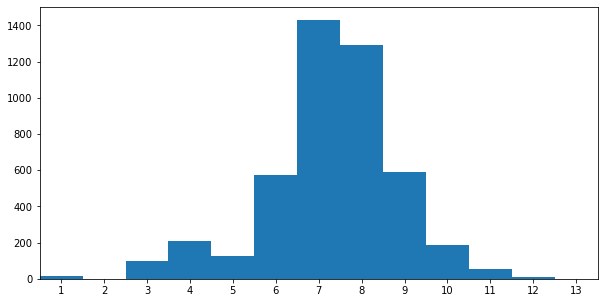

In [99]:
hist_results(T)

In [100]:
T = simulate(G, N, 8, 3)

Result 0: 6    acc: 6.0
Result 1: 6    acc: 6.0
Result 2: 6    acc: 6.0
Result 3: 6    acc: 6.0
Result 4: 6    acc: 6.0
Result 5: 6    acc: 6.0
Result 6: 6    acc: 6.0
Result 7: 6    acc: 6.0
Result 8: 6    acc: 6.0
Result 9: 6    acc: 6.0
Result 10: 6    acc: 6.0
Result 11: 6    acc: 6.0
Result 12: 6    acc: 6.0
Result 13: 6    acc: 6.0
Result 14: 1    acc: 5.666666666666667
Result 15: 1    acc: 5.375
Result 16: 1    acc: 5.117647058823529
Result 17: 1    acc: 4.888888888888889
Result 18: 1    acc: 4.684210526315789
Result 19: 6    acc: 4.75
Result 20: 6    acc: 4.809523809523809
Result 21: 6    acc: 4.863636363636363
Result 22: 6    acc: 4.913043478260869
Result 23: 6    acc: 4.958333333333333
Result 24: 1    acc: 4.8
Result 25: 6    acc: 4.846153846153846
Result 26: 6    acc: 4.888888888888889
Result 27: 6    acc: 4.928571428571429
Result 28: 6    acc: 4.9655172413793105
Result 29: 6    acc: 5.0
Result 30: 6    acc: 5.032258064516129
Result 31: 5    acc: 5.03125
Result 32: 6    acc:

Result 220: 6    acc: 5.633484162895928
Result 221: 5    acc: 5.63063063063063
Result 222: 6    acc: 5.632286995515695
Result 223: 6    acc: 5.633928571428571
Result 224: 7    acc: 5.64
Result 225: 7    acc: 5.646017699115045
Result 226: 7    acc: 5.651982378854625
Result 227: 6    acc: 5.6535087719298245
Result 228: 6    acc: 5.655021834061135
Result 229: 7    acc: 5.660869565217391
Result 230: 7    acc: 5.666666666666667
Result 231: 7    acc: 5.672413793103448
Result 232: 6    acc: 5.67381974248927
Result 233: 5    acc: 5.670940170940171
Result 234: 6    acc: 5.672340425531915
Result 235: 6    acc: 5.673728813559322
Result 236: 6    acc: 5.675105485232067
Result 237: 4    acc: 5.668067226890757
Result 238: 5    acc: 5.665271966527197
Result 239: 6    acc: 5.666666666666667
Result 240: 5    acc: 5.66390041493776
Result 241: 6    acc: 5.6652892561983474
Result 242: 3    acc: 5.654320987654321
Result 243: 6    acc: 5.655737704918033
Result 244: 6    acc: 5.6571428571428575
Result 245: 8

Result 428: 4    acc: 5.296037296037296
Result 429: 5    acc: 5.2953488372093025
Result 430: 5    acc: 5.294663573085847
Result 431: 6    acc: 5.296296296296297
Result 432: 5    acc: 5.295612009237876
Result 433: 5    acc: 5.2949308755760365
Result 434: 3    acc: 5.289655172413793
Result 435: 6    acc: 5.291284403669724
Result 436: 7    acc: 5.295194508009153
Result 437: 7    acc: 5.299086757990867
Result 438: 7    acc: 5.302961275626424
Result 439: 6    acc: 5.304545454545455
Result 440: 5    acc: 5.303854875283447
Result 441: 6    acc: 5.3054298642533935
Result 442: 5    acc: 5.3047404063205414
Result 443: 7    acc: 5.308558558558558
Result 444: 5    acc: 5.307865168539326
Result 445: 6    acc: 5.309417040358745
Result 446: 7    acc: 5.313199105145414
Result 447: 5    acc: 5.3125
Result 448: 5    acc: 5.311804008908686
Result 449: 5    acc: 5.311111111111111
Result 450: 5    acc: 5.310421286031042
Result 451: 5    acc: 5.3097345132743365
Result 452: 5    acc: 5.309050772626931
Result

Result 636: 5    acc: 5.398744113029827
Result 637: 5    acc: 5.398119122257054
Result 638: 5    acc: 5.397496087636933
Result 639: 4    acc: 5.3953125
Result 640: 4    acc: 5.393135725429017
Result 641: 4    acc: 5.390965732087228
Result 642: 4    acc: 5.388802488335926
Result 643: 4    acc: 5.386645962732919
Result 644: 5    acc: 5.386046511627907
Result 645: 5    acc: 5.385448916408668
Result 646: 5    acc: 5.384853168469861
Result 647: 6    acc: 5.385802469135802
Result 648: 4    acc: 5.3836671802773495
Result 649: 4    acc: 5.381538461538462
Result 650: 4    acc: 5.379416282642089
Result 651: 5    acc: 5.378834355828221
Result 652: 6    acc: 5.3797856049004595
Result 653: 3    acc: 5.376146788990826
Result 654: 5    acc: 5.37557251908397
Result 655: 4    acc: 5.373475609756097
Result 656: 7    acc: 5.375951293759513
Result 657: 6    acc: 5.376899696048632
Result 658: 4    acc: 5.374810318664643
Result 659: 4    acc: 5.372727272727273
Result 660: 4    acc: 5.3706505295007565
Result

Result 844: 6    acc: 5.2946745562130175
Result 845: 6    acc: 5.295508274231678
Result 846: 6    acc: 5.296340023612751
Result 847: 5    acc: 5.2959905660377355
Result 848: 5    acc: 5.295641931684335
Result 849: 6    acc: 5.2964705882352945
Result 850: 6    acc: 5.297297297297297
Result 851: 6    acc: 5.2981220657277
Result 852: 5    acc: 5.297772567409144
Result 853: 6    acc: 5.298594847775176
Result 854: 6    acc: 5.299415204678363
Result 855: 5    acc: 5.299065420560748
Result 856: 7    acc: 5.301050175029172
Result 857: 7    acc: 5.303030303030303
Result 858: 6    acc: 5.3038416763678695
Result 859: 6    acc: 5.304651162790698
Result 860: 6    acc: 5.305458768873403
Result 861: 6    acc: 5.306264501160093
Result 862: 6    acc: 5.307068366164542
Result 863: 6    acc: 5.30787037037037
Result 864: 6    acc: 5.308670520231214
Result 865: 6    acc: 5.309468822170901
Result 866: 7    acc: 5.311418685121107
Result 867: 5    acc: 5.311059907834101
Result 868: 6    acc: 5.311852704257768

Result 1050: 5    acc: 5.230256898192198
Result 1051: 5    acc: 5.230038022813688
Result 1052: 5    acc: 5.229819563152897
Result 1053: 5    acc: 5.229601518026565
Result 1054: 5    acc: 5.229383886255924
Result 1055: 5    acc: 5.229166666666667
Result 1056: 5    acc: 5.228949858088931
Result 1057: 5    acc: 5.228733459357278
Result 1058: 5    acc: 5.22851746931067
Result 1059: 5    acc: 5.228301886792453
Result 1060: 5    acc: 5.22808671065033
Result 1061: 5    acc: 5.227871939736347
Result 1062: 7    acc: 5.229539040451552
Result 1063: 5    acc: 5.2293233082706765
Result 1064: 3    acc: 5.227230046948357
Result 1065: 7    acc: 5.228893058161351
Result 1066: 5    acc: 5.228678537956888
Result 1067: 5    acc: 5.228464419475656
Result 1068: 7    acc: 5.2301216089803555
Result 1069: 5    acc: 5.229906542056074
Result 1070: 5    acc: 5.2296918767507
Result 1071: 5    acc: 5.229477611940299
Result 1072: 5    acc: 5.229263746505126
Result 1073: 5    acc: 5.229050279329609
Result 1074: 5    

Result 1254: 6    acc: 5.199203187250996
Result 1255: 5    acc: 5.199044585987261
Result 1256: 5    acc: 5.1988862370723945
Result 1257: 5    acc: 5.198728139904611
Result 1258: 5    acc: 5.198570293884035
Result 1259: 5    acc: 5.198412698412699
Result 1260: 5    acc: 5.198255352894528
Result 1261: 5    acc: 5.19809825673534
Result 1262: 5    acc: 5.197941409342834
Result 1263: 6    acc: 5.198575949367089
Result 1264: 6    acc: 5.199209486166008
Result 1265: 6    acc: 5.199842022116903
Result 1266: 6    acc: 5.2004735595895815
Result 1267: 5    acc: 5.200315457413249
Result 1268: 5    acc: 5.200157604412923
Result 1269: 5    acc: 5.2
Result 1270: 5    acc: 5.1998426435877265
Result 1271: 5    acc: 5.199685534591195
Result 1272: 5    acc: 5.199528672427337
Result 1273: 5    acc: 5.199372056514914
Result 1274: 5    acc: 5.19921568627451
Result 1275: 5    acc: 5.199059561128527
Result 1276: 5    acc: 5.198903680501175
Result 1277: 5    acc: 5.198748043818466
Result 1278: 5    acc: 5.1985

Result 1456: 5    acc: 5.217570350034317
Result 1457: 5    acc: 5.217421124828532
Result 1458: 5    acc: 5.217272104180946
Result 1459: 5    acc: 5.217123287671233
Result 1460: 5    acc: 5.216974674880219
Result 1461: 5    acc: 5.2168262653898765
Result 1462: 5    acc: 5.216678058783322
Result 1463: 5    acc: 5.216530054644808
Result 1464: 5    acc: 5.216382252559727
Result 1465: 5    acc: 5.216234652114598
Result 1466: 5    acc: 5.2160872528970685
Result 1467: 5    acc: 5.2159400544959125
Result 1468: 5    acc: 5.215793056501021
Result 1469: 5    acc: 5.215646258503401
Result 1470: 5    acc: 5.2154996600951735
Result 1471: 5    acc: 5.215353260869565
Result 1472: 5    acc: 5.2152070604209095
Result 1473: 5    acc: 5.215061058344641
Result 1474: 5    acc: 5.2149152542372885
Result 1475: 5    acc: 5.214769647696477
Result 1476: 8    acc: 5.21665538253216
Result 1477: 8    acc: 5.2185385656292285
Result 1478: 6    acc: 5.219066937119676
Result 1479: 6    acc: 5.219594594594595
Result 148

Result 1658: 6    acc: 5.248342374924653
Result 1659: 6    acc: 5.248795180722891
Result 1660: 6    acc: 5.2492474413004215
Result 1661: 6    acc: 5.249699157641396
Result 1662: 6    acc: 5.2501503307276005
Result 1663: 6    acc: 5.250600961538462
Result 1664: 6    acc: 5.251051051051051
Result 1665: 6    acc: 5.251500600240096
Result 1666: 7    acc: 5.25254949010198
Result 1667: 7    acc: 5.253597122302159
Result 1668: 7    acc: 5.254643499101258
Result 1669: 6    acc: 5.255089820359282
Result 1670: 6    acc: 5.255535607420706
Result 1671: 5    acc: 5.255382775119617
Result 1672: 6    acc: 5.255827854154214
Result 1673: 6    acc: 5.256272401433692
Result 1674: 6    acc: 5.2567164179104475
Result 1675: 5    acc: 5.256563245823389
Result 1676: 7    acc: 5.257602862254025
Result 1677: 7    acc: 5.258641239570918
Result 1678: 5    acc: 5.258487194758785
Result 1679: 5    acc: 5.258333333333334
Result 1680: 5    acc: 5.2581796549672815
Result 1681: 5    acc: 5.258026159334126
Result 1682: 

Result 1860: 5    acc: 5.297152068780226
Result 1861: 5    acc: 5.296992481203008
Result 1862: 8    acc: 5.2984433709071395
Result 1863: 7    acc: 5.299356223175966
Result 1864: 5    acc: 5.299195710455764
Result 1865: 5    acc: 5.29903536977492
Result 1866: 6    acc: 5.299410819496519
Result 1867: 5    acc: 5.299250535331906
Result 1868: 6    acc: 5.299625468164794
Result 1869: 5    acc: 5.2994652406417115
Result 1870: 5    acc: 5.299305184393373
Result 1871: 7    acc: 5.3002136752136755
Result 1872: 7    acc: 5.301121195942338
Result 1873: 7    acc: 5.302027748132337
Result 1874: 7    acc: 5.302933333333334
Result 1875: 6    acc: 5.303304904051172
Result 1876: 6    acc: 5.303676078849228
Result 1877: 6    acc: 5.304046858359958
Result 1878: 6    acc: 5.304417243214476
Result 1879: 6    acc: 5.3047872340425535
Result 1880: 6    acc: 5.305156831472621
Result 1881: 6    acc: 5.305526036131774
Result 1882: 6    acc: 5.305894848645778
Result 1883: 6    acc: 5.306263269639066
Result 1884: 

Result 2061: 5    acc: 5.3273520853540255
Result 2062: 5    acc: 5.32719340765875
Result 2063: 5    acc: 5.3270348837209305
Result 2064: 5    acc: 5.326876513317191
Result 2065: 5    acc: 5.3267182962245885
Result 2066: 5    acc: 5.32656023222061
Result 2067: 5    acc: 5.326402321083172
Result 2068: 7    acc: 5.327211213146447
Result 2069: 5    acc: 5.327053140096618
Result 2070: 5    acc: 5.326895219700628
Result 2071: 5    acc: 5.3267374517374515
Result 2072: 5    acc: 5.326579835986493
Result 2073: 5    acc: 5.326422372227579
Result 2074: 5    acc: 5.326265060240964
Result 2075: 5    acc: 5.3261078998073215
Result 2076: 5    acc: 5.325950890707752
Result 2077: 5    acc: 5.325794032723773
Result 2078: 6    acc: 5.326118326118326
Result 2079: 6    acc: 5.326442307692307
Result 2080: 5    acc: 5.326285439692455
Result 2081: 5    acc: 5.326128722382324
Result 2082: 6    acc: 5.326452232357177
Result 2083: 5    acc: 5.326295585412668
Result 2084: 7    acc: 5.327098321342926
Result 2085: 

Result 2261: 5    acc: 5.260831122900089
Result 2262: 6    acc: 5.261157755192222
Result 2263: 5    acc: 5.261042402826855
Result 2264: 5    acc: 5.260927152317881
Result 2265: 7    acc: 5.261694616063548
Result 2266: 7    acc: 5.262461402734892
Result 2267: 7    acc: 5.2632275132275135
Result 2268: 6    acc: 5.263552225650066
Result 2269: 7    acc: 5.26431718061674
Result 2270: 7    acc: 5.265081461911052
Result 2271: 7    acc: 5.265845070422535
Result 2272: 7    acc: 5.266608007039156
Result 2273: 7    acc: 5.267370272647318
Result 2274: 7    acc: 5.268131868131868
Result 2275: 6    acc: 5.268453427065026
Result 2276: 7    acc: 5.26921387790953
Result 2277: 6    acc: 5.269534679543459
Result 2278: 7    acc: 5.2702939885914875
Result 2279: 6    acc: 5.2706140350877195
Result 2280: 7    acc: 5.2713722051731695
Result 2281: 5    acc: 5.27125328659071
Result 2282: 5    acc: 5.271134472185721
Result 2283: 6    acc: 5.271453590192644
Result 2284: 6    acc: 5.271772428884026
Result 2285: 5 

Result 2462: 3    acc: 5.235079171741778
Result 2463: 4    acc: 5.234577922077922
Result 2464: 4    acc: 5.234077079107505
Result 2465: 4    acc: 5.233576642335766
Result 2466: 4    acc: 5.233076611268747
Result 2467: 4    acc: 5.23257698541329
Result 2468: 4    acc: 5.232077764277035
Result 2469: 4    acc: 5.231578947368421
Result 2470: 4    acc: 5.231080534196681
Result 2471: 4    acc: 5.230582524271845
Result 2472: 4    acc: 5.2300849171047314
Result 2473: 4    acc: 5.2295877122069525
Result 2474: 4    acc: 5.2290909090909095
Result 2475: 4    acc: 5.22859450726979
Result 2476: 4    acc: 5.228098506257569
Result 2477: 4    acc: 5.227602905569007
Result 2478: 5    acc: 5.227511093182735
Result 2479: 3    acc: 5.226612903225806
Result 2480: 3    acc: 5.22571543732366
Result 2481: 3    acc: 5.224818694601128
Result 2482: 3    acc: 5.223922674184454
Result 2483: 3    acc: 5.223027375201288
Result 2484: 3    acc: 5.222132796780684
Result 2485: 3    acc: 5.221238938053097
Result 2486: 3  

Result 2664: 6    acc: 5.173358348968105
Result 2665: 6    acc: 5.173668417104276
Result 2666: 6    acc: 5.173978252718411
Result 2667: 6    acc: 5.174287856071964
Result 2668: 6    acc: 5.174597227426002
Result 2669: 5    acc: 5.174531835205992
Result 2670: 6    acc: 5.174840883564208
Result 2671: 5    acc: 5.174775449101796
Result 2672: 6    acc: 5.175084175084175
Result 2673: 6    acc: 5.175392670157068
Result 2674: 5    acc: 5.175327102803738
Result 2675: 5    acc: 5.175261584454409
Result 2676: 6    acc: 5.175569667538289
Result 2677: 6    acc: 5.175877520537715
Result 2678: 7    acc: 5.176558417319895
Result 2679: 6    acc: 5.176865671641791
Result 2680: 5    acc: 5.176799701603879
Result 2681: 6    acc: 5.177106636838181
Result 2682: 5    acc: 5.177040626164741
Result 2683: 5    acc: 5.176974664679583
Result 2684: 5    acc: 5.176908752327747
Result 2685: 5    acc: 5.176842889054356
Result 2686: 6    acc: 5.177149237067361
Result 2687: 6    acc: 5.177455357142857
Result 2688: 5  

Result 2865: 4    acc: 5.185624563852059
Result 2866: 4    acc: 5.185211021974189
Result 2867: 5    acc: 5.185146443514644
Result 2868: 6    acc: 5.185430463576159
Result 2869: 5    acc: 5.185365853658537
Result 2870: 5    acc: 5.185301288749565
Result 2871: 5    acc: 5.185236768802229
Result 2872: 5    acc: 5.185172293769579
Result 2873: 5    acc: 5.185107863604732
Result 2874: 5    acc: 5.185043478260869
Result 2875: 5    acc: 5.184979137691238
Result 2876: 5    acc: 5.184914841849149
Result 2877: 5    acc: 5.184850590687978
Result 2878: 4    acc: 5.184439041333796
Result 2879: 4    acc: 5.184027777777778
Result 2880: 4    acc: 5.183616799722318
Result 2881: 4    acc: 5.183206106870229
Result 2882: 4    acc: 5.182795698924731
Result 2883: 5    acc: 5.182732316227462
Result 2884: 5    acc: 5.182668977469671
Result 2885: 5    acc: 5.182605682605683
Result 2886: 5    acc: 5.182542431589885
Result 2887: 4    acc: 5.18213296398892
Result 2888: 4    acc: 5.181723779854621
Result 2889: 4   

Result 3066: 6    acc: 5.148679491359635
Result 3067: 6    acc: 5.148956975228161
Result 3068: 6    acc: 5.149234278266536
Result 3069: 6    acc: 5.149511400651466
Result 3070: 6    acc: 5.149788342559427
Result 3071: 6    acc: 5.150065104166667
Result 3072: 6    acc: 5.150341685649202
Result 3073: 6    acc: 5.150618087182823
Result 3074: 6    acc: 5.15089430894309
Result 3075: 6    acc: 5.151170351105332
Result 3076: 6    acc: 5.151446213844654
Result 3077: 6    acc: 5.151721897335932
Result 3078: 6    acc: 5.151997401753817
Result 3079: 6    acc: 5.152272727272727
Result 3080: 6    acc: 5.152547874066862
Result 3081: 6    acc: 5.152822842310188
Result 3082: 6    acc: 5.1530976321764514
Result 3083: 6    acc: 5.15337224383917
Result 3084: 6    acc: 5.153646677471637
Result 3085: 6    acc: 5.153920933246922
Result 3086: 6    acc: 5.154195011337868
Result 3087: 6    acc: 5.154468911917099
Result 3088: 6    acc: 5.1547426351570085
Result 3089: 6    acc: 5.155016181229773
Result 3090: 6  

Result 3268: 5    acc: 5.184460079535026
Result 3269: 4    acc: 5.184097859327217
Result 3270: 4    acc: 5.1837358605930905
Result 3271: 4    acc: 5.183374083129585
Result 3272: 4    acc: 5.183012526733883
Result 3273: 6    acc: 5.183262064752596
Result 3274: 5    acc: 5.183206106870229
Result 3275: 5    acc: 5.183150183150183
Result 3276: 6    acc: 5.183399450717119
Result 3277: 6    acc: 5.183648566198902
Result 3278: 5    acc: 5.1835925587069225
Result 3279: 5    acc: 5.183536585365854
Result 3280: 5    acc: 5.183480646144468
Result 3281: 6    acc: 5.183729433272394
Result 3282: 5    acc: 5.183673469387755
Result 3283: 5    acc: 5.183617539585871
Result 3284: 5    acc: 5.183561643835616
Result 3285: 5    acc: 5.183505782105904
Result 3286: 5    acc: 5.183449954365683
Result 3287: 5    acc: 5.1833941605839415
Result 3288: 5    acc: 5.183338400729705
Result 3289: 4    acc: 5.182978723404255
Result 3290: 5    acc: 5.182923123670617
Result 3291: 5    acc: 5.182867557715674
Result 3292: 

Result 3469: 7    acc: 5.193083573487032
Result 3470: 7    acc: 5.193604148660328
Result 3471: 7    acc: 5.1941244239631335
Result 3472: 7    acc: 5.194644399654478
Result 3473: 6    acc: 5.194876223373632
Result 3474: 6    acc: 5.195107913669065
Result 3475: 6    acc: 5.195339470655926
Result 3476: 7    acc: 5.195858498705781
Result 3477: 7    acc: 5.196377228292122
Result 3478: 8    acc: 5.197183098591549
Result 3479: 8    acc: 5.1979885057471265
Result 3480: 7    acc: 5.198506176386096
Result 3481: 7    acc: 5.19902354968409
Result 3482: 8    acc: 5.199827734711455
Result 3483: 8    acc: 5.200631458094144
Result 3484: 6    acc: 5.200860832137733
Result 3485: 6    acc: 5.201090074584051
Result 3486: 6    acc: 5.201319185546315
Result 3487: 6    acc: 5.2015481651376145
Result 3488: 6    acc: 5.201777013470909
Result 3489: 6    acc: 5.2020057306590255
Result 3490: 4    acc: 5.201661415067316
Result 3491: 5    acc: 5.2016036655211915
Result 3492: 5    acc: 5.201545949040939
Result 3493:

Result 3671: 6    acc: 5.214869281045751
Result 3672: 5    acc: 5.21481078137762
Result 3673: 5    acc: 5.214752313554709
Result 3674: 5    acc: 5.214693877551021
Result 3675: 5    acc: 5.2146354733405875
Result 3676: 5    acc: 5.214577100897471
Result 3677: 5    acc: 5.214518760195759
Result 3678: 5    acc: 5.214460451209568
Result 3679: 5    acc: 5.214402173913044
Result 3680: 6    acc: 5.214615593588698
Result 3681: 5    acc: 5.2145573058120585
Result 3682: 5    acc: 5.214499049687754
Result 3683: 5    acc: 5.214440825190011
Result 3684: 5    acc: 5.21438263229308
Result 3685: 5    acc: 5.214324470971243
Result 3686: 5    acc: 5.214266341198806
Result 3687: 5    acc: 5.214208242950108
Result 3688: 5    acc: 5.214150176199512
Result 3689: 5    acc: 5.21409214092141
Result 3690: 6    acc: 5.214305066377675
Result 3691: 7    acc: 5.214788732394366
Result 3692: 7    acc: 5.215272136474411
Result 3693: 6    acc: 5.215484569572279
Result 3694: 6    acc: 5.215696887686062
Result 3695: 5   

Result 3872: 4    acc: 5.207332816937774
Result 3873: 5    acc: 5.207279297883325
Result 3874: 4    acc: 5.206967741935484
Result 3875: 4    acc: 5.206656346749226
Result 3876: 4    acc: 5.206345112200155
Result 3877: 5    acc: 5.206291903042805
Result 3878: 5    acc: 5.206238721319928
Result 3879: 5    acc: 5.206185567010309
Result 3880: 4    acc: 5.205874774542644
Result 3881: 7    acc: 5.206336939721793
Result 3882: 6    acc: 5.206541334020088
Result 3883: 6    acc: 5.2067456230690015
Result 3884: 7    acc: 5.207207207207207
Result 3885: 7    acc: 5.20766855378281
Result 3886: 7    acc: 5.208129662979161
Result 3887: 7    acc: 5.2085905349794235
Result 3888: 7    acc: 5.209051169966572
Result 3889: 7    acc: 5.209511568123394
Result 3890: 6    acc: 5.209714726291442
Result 3891: 7    acc: 5.210174717368962
Result 3892: 6    acc: 5.210377600821988
Result 3893: 6    acc: 5.210580380071906
Result 3894: 5    acc: 5.2105263157894735
Result 3895: 6    acc: 5.210728952772074
Result 3896: 6

Result 4074: 5    acc: 5.223312883435582
Result 4075: 6    acc: 5.223503434739941
Result 4076: 5    acc: 5.223448614177091
Result 4077: 6    acc: 5.223639038744483
Result 4078: 6    acc: 5.223829369943614
Result 4079: 6    acc: 5.224019607843137
Result 4080: 5    acc: 5.223964714530752
Result 4081: 6    acc: 5.2241548260656545
Result 4082: 6    acc: 5.2243448444771
Result 4083: 5    acc: 5.224289911851127
Result 4084: 5    acc: 5.224235006119951
Result 4085: 6    acc: 5.224424865394028
Result 4086: 5    acc: 5.2243699535111325
Result 4087: 5    acc: 5.2243150684931505
Result 4088: 5    acc: 5.224260210320372
Result 4089: 8    acc: 5.224938875305623
Result 4090: 7    acc: 5.225372769494011
Result 4091: 6    acc: 5.225562072336266
Result 4092: 5    acc: 5.225506963107745
Result 4093: 5    acc: 5.225451880801172
Result 4094: 5    acc: 5.2253968253968255
Result 4095: 6    acc: 5.2255859375
Result 4096: 6    acc: 5.225774957285819
Result 4097: 6    acc: 5.225963884821864
Result 4098: 6    a

Result 4274: 5    acc: 5.240701754385965
Result 4275: 5    acc: 5.240645463049579
Result 4276: 5    acc: 5.240589198036006
Result 4277: 6    acc: 5.240766713417485
Result 4278: 6    acc: 5.240944145828465
Result 4279: 6    acc: 5.241121495327103
Result 4280: 6    acc: 5.241298761971502
Result 4281: 6    acc: 5.24147594581971
Result 4282: 6    acc: 5.241653046929722
Result 4283: 6    acc: 5.241830065359477
Result 4284: 6    acc: 5.242007001166861
Result 4285: 6    acc: 5.242183854409706
Result 4286: 6    acc: 5.24236062514579
Result 4287: 6    acc: 5.242537313432836
Result 4288: 6    acc: 5.242713919328515
Result 4289: 6    acc: 5.242890442890443
Result 4290: 5    acc: 5.242833838266138
Result 4291: 5    acc: 5.24277726001864
Result 4292: 5    acc: 5.2427207081295135
Result 4293: 6    acc: 5.2428970656730325
Result 4294: 5    acc: 5.242840512223515
Result 4295: 6    acc: 5.243016759776537
Result 4296: 6    acc: 5.243192925296719
Result 4297: 5    acc: 5.243136342484877
Result 4298: 3   

Result 4475: 6    acc: 5.2439678284182305
Result 4476: 3    acc: 5.24346660710297
Result 4477: 6    acc: 5.2436355515855295
Result 4478: 5    acc: 5.243581156508149
Result 4479: 7    acc: 5.243973214285714
Result 4480: 5    acc: 5.243918768132113
Result 4481: 6    acc: 5.244087460954931
Result 4482: 5    acc: 5.24403301360696
Result 4483: 7    acc: 5.244424620874219
Result 4484: 7    acc: 5.244816053511705
Result 4485: 7    acc: 5.245207311636202
Result 4486: 6    acc: 5.245375529306886
Result 4487: 6    acc: 5.24554367201426
Result 4488: 6    acc: 5.245711739808421
Result 4489: 7    acc: 5.2461024498886415
Result 4490: 6    acc: 5.246270318414607
Result 4491: 5    acc: 5.246215494211932
Result 4492: 5    acc: 5.246160694413532
Result 4493: 5    acc: 5.246105919003115
Result 4494: 6    acc: 5.246273637374861
Result 4495: 6    acc: 5.24644128113879
Result 4496: 6    acc: 5.246608850344674
Result 4497: 6    acc: 5.246776345042241
Result 4498: 6    acc: 5.2469437652811735
Result 4499: 5  

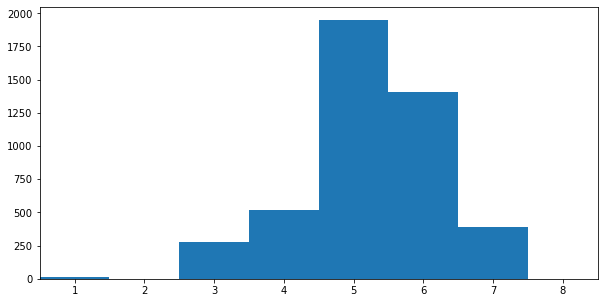

In [101]:
hist_results(T)

In [102]:
T = simulate(G, N, 8, 4)

Result 0: 5    acc: 5.0
Result 1: 5    acc: 5.0
Result 2: 5    acc: 5.0
Result 3: 5    acc: 5.0
Result 4: 6    acc: 5.2
Result 5: 5    acc: 5.166666666666667
Result 6: 5    acc: 5.142857142857143
Result 7: 5    acc: 5.125
Result 8: 5    acc: 5.111111111111111
Result 9: 5    acc: 5.1
Result 10: 5    acc: 5.090909090909091
Result 11: 6    acc: 5.166666666666667
Result 12: 5    acc: 5.153846153846154
Result 13: 5    acc: 5.142857142857143
Result 14: 1    acc: 4.866666666666666
Result 15: 1    acc: 4.625
Result 16: 1    acc: 4.411764705882353
Result 17: 1    acc: 4.222222222222222
Result 18: 1    acc: 4.052631578947368
Result 19: 5    acc: 4.1
Result 20: 5    acc: 4.142857142857143
Result 21: 5    acc: 4.181818181818182
Result 22: 5    acc: 4.217391304347826
Result 23: 5    acc: 4.25
Result 24: 1    acc: 4.12
Result 25: 6    acc: 4.1923076923076925
Result 26: 5    acc: 4.222222222222222
Result 27: 5    acc: 4.25
Result 28: 5    acc: 4.275862068965517
Result 29: 6    acc: 4.333333333333333


Result 218: 4    acc: 4.799086757990867
Result 219: 4    acc: 4.795454545454546
Result 220: 4    acc: 4.791855203619909
Result 221: 4    acc: 4.788288288288288
Result 222: 5    acc: 4.789237668161435
Result 223: 5    acc: 4.790178571428571
Result 224: 6    acc: 4.795555555555556
Result 225: 6    acc: 4.800884955752212
Result 226: 6    acc: 4.8061674008810575
Result 227: 5    acc: 4.807017543859649
Result 228: 5    acc: 4.807860262008734
Result 229: 6    acc: 4.8130434782608695
Result 230: 6    acc: 4.818181818181818
Result 231: 6    acc: 4.823275862068965
Result 232: 5    acc: 4.824034334763948
Result 233: 4    acc: 4.82051282051282
Result 234: 4    acc: 4.817021276595745
Result 235: 6    acc: 4.822033898305085
Result 236: 4    acc: 4.818565400843882
Result 237: 4    acc: 4.815126050420168
Result 238: 4    acc: 4.811715481171548
Result 239: 5    acc: 4.8125
Result 240: 4    acc: 4.809128630705394
Result 241: 5    acc: 4.809917355371901
Result 242: 3    acc: 4.802469135802469
Result 243

Result 426: 5    acc: 4.496487119437939
Result 427: 3    acc: 4.492990654205608
Result 428: 3    acc: 4.489510489510489
Result 429: 4    acc: 4.488372093023256
Result 430: 4    acc: 4.487238979118329
Result 431: 5    acc: 4.488425925925926
Result 432: 5    acc: 4.489607390300231
Result 433: 5    acc: 4.490783410138249
Result 434: 3    acc: 4.487356321839081
Result 435: 5    acc: 4.488532110091743
Result 436: 6    acc: 4.491990846681922
Result 437: 6    acc: 4.495433789954338
Result 438: 5    acc: 4.496583143507973
Result 439: 5    acc: 4.497727272727273
Result 440: 4    acc: 4.496598639455782
Result 441: 5    acc: 4.497737556561086
Result 442: 4    acc: 4.496613995485327
Result 443: 6    acc: 4.5
Result 444: 5    acc: 4.501123595505618
Result 445: 5    acc: 4.502242152466367
Result 446: 5    acc: 4.503355704697986
Result 447: 4    acc: 4.502232142857143
Result 448: 4    acc: 4.501113585746102
Result 449: 4    acc: 4.5
Result 450: 4    acc: 4.498891352549889
Result 451: 4    acc: 4.4977

Result 635: 4    acc: 4.567610062893082
Result 636: 4    acc: 4.566718995290424
Result 637: 4    acc: 4.565830721003135
Result 638: 4    acc: 4.564945226917058
Result 639: 4    acc: 4.5640625
Result 640: 4    acc: 4.563182527301092
Result 641: 4    acc: 4.562305295950155
Result 642: 4    acc: 4.561430793157077
Result 643: 4    acc: 4.5605590062111805
Result 644: 4    acc: 4.55968992248062
Result 645: 4    acc: 4.5588235294117645
Result 646: 4    acc: 4.557959814528593
Result 647: 5    acc: 4.558641975308642
Result 648: 4    acc: 4.557781201848998
Result 649: 4    acc: 4.556923076923077
Result 650: 4    acc: 4.556067588325653
Result 651: 5    acc: 4.556748466257669
Result 652: 5    acc: 4.557427258805513
Result 653: 3    acc: 4.555045871559633
Result 654: 4    acc: 4.554198473282443
Result 655: 4    acc: 4.553353658536586
Result 656: 5    acc: 4.554033485540335
Result 657: 5    acc: 4.554711246200608
Result 658: 4    acc: 4.553869499241275
Result 659: 4    acc: 4.553030303030303
Result 

Result 842: 5    acc: 4.513641755634638
Result 843: 5    acc: 4.514218009478673
Result 844: 5    acc: 4.514792899408284
Result 845: 5    acc: 4.515366430260047
Result 846: 5    acc: 4.515938606847698
Result 847: 4    acc: 4.515330188679245
Result 848: 4    acc: 4.51472320376914
Result 849: 5    acc: 4.515294117647059
Result 850: 5    acc: 4.515863689776733
Result 851: 5    acc: 4.516431924882629
Result 852: 4    acc: 4.515826494724502
Result 853: 5    acc: 4.516393442622951
Result 854: 5    acc: 4.5169590643274855
Result 855: 4    acc: 4.516355140186916
Result 856: 5    acc: 4.516919486581097
Result 857: 5    acc: 4.5174825174825175
Result 858: 5    acc: 4.518044237485448
Result 859: 5    acc: 4.518604651162791
Result 860: 5    acc: 4.519163763066202
Result 861: 5    acc: 4.5197215777262185
Result 862: 5    acc: 4.5202780996523755
Result 863: 5    acc: 4.520833333333333
Result 864: 5    acc: 4.521387283236995
Result 865: 5    acc: 4.521939953810624
Result 866: 5    acc: 4.5224913494809

Result 1048: 4    acc: 4.480457578646329
Result 1049: 5    acc: 4.480952380952381
Result 1050: 4    acc: 4.480494766888677
Result 1051: 5    acc: 4.480988593155893
Result 1052: 4    acc: 4.480531813865147
Result 1053: 5    acc: 4.481024667931689
Result 1054: 4    acc: 4.480568720379147
Result 1055: 4    acc: 4.480113636363637
Result 1056: 4    acc: 4.479659413434248
Result 1057: 4    acc: 4.479206049149338
Result 1058: 4    acc: 4.478753541076487
Result 1059: 4    acc: 4.478301886792453
Result 1060: 4    acc: 4.477851083883129
Result 1061: 5    acc: 4.47834274952919
Result 1062: 5    acc: 4.4788334901222955
Result 1063: 4    acc: 4.478383458646617
Result 1064: 3    acc: 4.476995305164319
Result 1065: 4    acc: 4.476547842401501
Result 1066: 4    acc: 4.4761012183692594
Result 1067: 4    acc: 4.47565543071161
Result 1068: 5    acc: 4.476145930776426
Result 1069: 4    acc: 4.475700934579439
Result 1070: 4    acc: 4.4752567693744165
Result 1071: 5    acc: 4.475746268656716
Result 1072: 4 

Result 1249: 6    acc: 4.4712
Result 1250: 6    acc: 4.47242206235012
Result 1251: 5    acc: 4.472843450479234
Result 1252: 5    acc: 4.473264166001596
Result 1253: 5    acc: 4.473684210526316
Result 1254: 5    acc: 4.47410358565737
Result 1255: 4    acc: 4.473726114649682
Result 1256: 4    acc: 4.473349244232299
Result 1257: 4    acc: 4.472972972972973
Result 1258: 4    acc: 4.472597299444003
Result 1259: 4    acc: 4.472222222222222
Result 1260: 4    acc: 4.471847739888977
Result 1261: 4    acc: 4.471473851030111
Result 1262: 4    acc: 4.471100554235946
Result 1263: 6    acc: 4.472310126582278
Result 1264: 6    acc: 4.473517786561265
Result 1265: 6    acc: 4.474723538704581
Result 1266: 6    acc: 4.475927387529597
Result 1267: 5    acc: 4.476340694006309
Result 1268: 5    acc: 4.476753349093775
Result 1269: 5    acc: 4.477165354330709
Result 1270: 5    acc: 4.477576711250983
Result 1271: 5    acc: 4.477987421383648
Result 1272: 5    acc: 4.478397486252946
Result 1273: 5    acc: 4.4788

Result 1451: 4    acc: 4.502754820936639
Result 1452: 4    acc: 4.502408809359945
Result 1453: 4    acc: 4.502063273727648
Result 1454: 4    acc: 4.501718213058419
Result 1455: 4    acc: 4.501373626373627
Result 1456: 4    acc: 4.501029512697324
Result 1457: 4    acc: 4.500685871056241
Result 1458: 4    acc: 4.500342700479781
Result 1459: 4    acc: 4.5
Result 1460: 4    acc: 4.499657768651608
Result 1461: 4    acc: 4.4993160054719565
Result 1462: 4    acc: 4.4989747095010255
Result 1463: 4    acc: 4.498633879781421
Result 1464: 4    acc: 4.498293515358362
Result 1465: 4    acc: 4.497953615279672
Result 1466: 4    acc: 4.497614178595773
Result 1467: 4    acc: 4.497275204359673
Result 1468: 4    acc: 4.496936691626957
Result 1469: 4    acc: 4.496598639455782
Result 1470: 4    acc: 4.4962610469068665
Result 1471: 4    acc: 4.4959239130434785
Result 1472: 4    acc: 4.495587236931432
Result 1473: 4    acc: 4.495251017639077
Result 1474: 4    acc: 4.494915254237288
Result 1475: 4    acc: 4.4

Result 1653: 6    acc: 4.5278113663845225
Result 1654: 6    acc: 4.528700906344411
Result 1655: 6    acc: 4.529589371980676
Result 1656: 6    acc: 4.530476765238383
Result 1657: 6    acc: 4.531363088057901
Result 1658: 6    acc: 4.532248342374925
Result 1659: 6    acc: 4.533132530120482
Result 1660: 6    acc: 4.534015653220951
Result 1661: 6    acc: 4.534897713598075
Result 1662: 6    acc: 4.5357787131689715
Result 1663: 6    acc: 4.536658653846154
Result 1664: 6    acc: 4.5375375375375375
Result 1665: 6    acc: 4.538415366146459
Result 1666: 6    acc: 4.539292141571686
Result 1667: 6    acc: 4.540167865707434
Result 1668: 6    acc: 4.541042540443379
Result 1669: 5    acc: 4.541317365269461
Result 1670: 5    acc: 4.541591861160981
Result 1671: 5    acc: 4.541866028708134
Result 1672: 5    acc: 4.542139868499701
Result 1673: 5    acc: 4.542413381123058
Result 1674: 5    acc: 4.542686567164179
Result 1675: 4    acc: 4.54236276849642
Result 1676: 5    acc: 4.542635658914729
Result 1677: 5

Result 1855: 6    acc: 4.558189655172414
Result 1856: 5    acc: 4.5584275713516424
Result 1857: 5    acc: 4.558665231431647
Result 1858: 5    acc: 4.558902635825713
Result 1859: 5    acc: 4.559139784946237
Result 1860: 5    acc: 4.559376679204728
Result 1861: 5    acc: 4.559613319011815
Result 1862: 6    acc: 4.5603864734299515
Result 1863: 6    acc: 4.5611587982832615
Result 1864: 4    acc: 4.560857908847185
Result 1865: 5    acc: 4.561093247588424
Result 1866: 5    acc: 4.561328334226031
Result 1867: 5    acc: 4.561563169164883
Result 1868: 5    acc: 4.561797752808989
Result 1869: 4    acc: 4.561497326203209
Result 1870: 4    acc: 4.561197220737573
Result 1871: 5    acc: 4.5614316239316235
Result 1872: 5    acc: 4.561665776828617
Result 1873: 5    acc: 4.561899679829242
Result 1874: 5    acc: 4.562133333333334
Result 1875: 5    acc: 4.562366737739872
Result 1876: 5    acc: 4.56259989344699
Result 1877: 5    acc: 4.56283280085197
Result 1878: 5    acc: 4.56306546035125
Result 1879: 5 

Result 2057: 4    acc: 4.580174927113703
Result 2058: 4    acc: 4.579893152015542
Result 2059: 4    acc: 4.579611650485437
Result 2060: 4    acc: 4.579330422125182
Result 2061: 5    acc: 4.5795344325897185
Result 2062: 5    acc: 4.579738245273873
Result 2063: 5    acc: 4.579941860465116
Result 2064: 5    acc: 4.580145278450363
Result 2065: 5    acc: 4.580348499515973
Result 2066: 5    acc: 4.580551523947751
Result 2067: 5    acc: 4.580754352030948
Result 2068: 5    acc: 4.580956984050266
Result 2069: 6    acc: 4.581642512077295
Result 2070: 4    acc: 4.581361661033317
Result 2071: 4    acc: 4.581081081081081
Result 2072: 4    acc: 4.580800771828268
Result 2073: 4    acc: 4.5805207328833175
Result 2074: 4    acc: 4.580240963855422
Result 2075: 4    acc: 4.579961464354528
Result 2076: 4    acc: 4.579682233991334
Result 2077: 5    acc: 4.579884504331088
Result 2078: 5    acc: 4.58008658008658
Result 2079: 5    acc: 4.580288461538461
Result 2080: 4    acc: 4.580009610764056
Result 2081: 6 

Result 2258: 5    acc: 4.518370960602036
Result 2259: 4    acc: 4.518141592920354
Result 2260: 4    acc: 4.517912428129146
Result 2261: 5    acc: 4.5181255526083115
Result 2262: 5    acc: 4.518338488731772
Result 2263: 4    acc: 4.5181095406360425
Result 2264: 4    acc: 4.517880794701987
Result 2265: 5    acc: 4.518093556928508
Result 2266: 5    acc: 4.518306131451257
Result 2267: 5    acc: 4.518518518518518
Result 2268: 4    acc: 4.518289995592772
Result 2269: 5    acc: 4.518502202643171
Result 2270: 5    acc: 4.518714222809335
Result 2271: 6    acc: 4.519366197183099
Result 2272: 6    acc: 4.520017597888254
Result 2273: 6    acc: 4.5206684256816185
Result 2274: 6    acc: 4.521318681318681
Result 2275: 5    acc: 4.52152899824253
Result 2276: 6    acc: 4.522178304787
Result 2277: 5    acc: 4.522388059701493
Result 2278: 6    acc: 4.523036419482229
Result 2279: 6    acc: 4.523684210526316
Result 2280: 5    acc: 4.523893029373082
Result 2281: 4    acc: 4.523663453111306
Result 2282: 4   

Result 2459: 4    acc: 4.491869918699187
Result 2460: 4    acc: 4.491670052824055
Result 2461: 4    acc: 4.4914703493095045
Result 2462: 3    acc: 4.490864799025578
Result 2463: 4    acc: 4.490665584415584
Result 2464: 4    acc: 4.490466531440163
Result 2465: 4    acc: 4.490267639902676
Result 2466: 4    acc: 4.49006890960681
Result 2467: 4    acc: 4.489870340356564
Result 2468: 4    acc: 4.4896719319562575
Result 2469: 4    acc: 4.489473684210527
Result 2470: 4    acc: 4.4892755969243225
Result 2471: 4    acc: 4.489077669902913
Result 2472: 4    acc: 4.48887990295188
Result 2473: 4    acc: 4.488682295877122
Result 2474: 4    acc: 4.488484848484848
Result 2475: 4    acc: 4.4882875605815835
Result 2476: 4    acc: 4.488090431974162
Result 2477: 4    acc: 4.487893462469733
Result 2478: 4    acc: 4.487696651875757
Result 2479: 3    acc: 4.487096774193549
Result 2480: 3    acc: 4.486497380088674
Result 2481: 3    acc: 4.4858984689766315
Result 2482: 3    acc: 4.485300040273862
Result 2483: 

Result 2660: 5    acc: 4.456971063509958
Result 2661: 5    acc: 4.45717505634861
Result 2662: 4    acc: 4.4570033796470145
Result 2663: 4    acc: 4.456831831831832
Result 2664: 5    acc: 4.457035647279549
Result 2665: 5    acc: 4.4572393098274565
Result 2666: 5    acc: 4.457442819647544
Result 2667: 5    acc: 4.4576461769115445
Result 2668: 5    acc: 4.457849381790933
Result 2669: 4    acc: 4.457677902621723
Result 2670: 4    acc: 4.457506551853238
Result 2671: 4    acc: 4.457335329341317
Result 2672: 5    acc: 4.457538346427235
Result 2673: 5    acc: 4.457741211667913
Result 2674: 4    acc: 4.457570093457944
Result 2675: 4    acc: 4.457399103139013
Result 2676: 5    acc: 4.457601793051924
Result 2677: 5    acc: 4.457804331590739
Result 2678: 6    acc: 4.458379992534528
Result 2679: 5    acc: 4.458582089552239
Result 2680: 4    acc: 4.458411040656472
Result 2681: 4    acc: 4.4582401193139445
Result 2682: 5    acc: 4.45844204248975
Result 2683: 5    acc: 4.458643815201192
Result 2684: 5

Result 2860: 4    acc: 4.463124781544915
Result 2861: 4    acc: 4.462962962962963
Result 2862: 4    acc: 4.462801257422284
Result 2863: 4    acc: 4.4626396648044695
Result 2864: 4    acc: 4.462478184991274
Result 2865: 4    acc: 4.46231681786462
Result 2866: 4    acc: 4.462155563306593
Result 2867: 4    acc: 4.461994421199442
Result 2868: 5    acc: 4.462181944928546
Result 2869: 5    acc: 4.462369337979094
Result 2870: 4    acc: 4.462208289794496
Result 2871: 4    acc: 4.462047353760446
Result 2872: 4    acc: 4.461886529759833
Result 2873: 5    acc: 4.462073764787752
Result 2874: 5    acc: 4.462260869565218
Result 2875: 4    acc: 4.462100139082058
Result 2876: 4    acc: 4.461939520333681
Result 2877: 4    acc: 4.461779013203613
Result 2878: 4    acc: 4.461618617575547
Result 2879: 4    acc: 4.461458333333334
Result 2880: 4    acc: 4.461298160360986
Result 2881: 4    acc: 4.461138098542679
Result 2882: 4    acc: 4.460978147762747
Result 2883: 4    acc: 4.4608183079056865
Result 2884: 4 

Result 3061: 5    acc: 4.417700849118224
Result 3062: 5    acc: 4.417890956578518
Result 3063: 5    acc: 4.418080939947781
Result 3064: 5    acc: 4.4182707993474715
Result 3065: 5    acc: 4.418460534898891
Result 3066: 5    acc: 4.4186501467231825
Result 3067: 5    acc: 4.41883963494133
Result 3068: 5    acc: 4.419028999674161
Result 3069: 6    acc: 4.419543973941368
Result 3070: 6    acc: 4.420058612829697
Result 3071: 6    acc: 4.420572916666667
Result 3072: 6    acc: 4.421086885779369
Result 3073: 6    acc: 4.4216005204944695
Result 3074: 6    acc: 4.422113821138211
Result 3075: 6    acc: 4.4226267880364105
Result 3076: 6    acc: 4.423139421514462
Result 3077: 5    acc: 4.423326835607537
Result 3078: 5    acc: 4.4235141279636245
Result 3079: 5    acc: 4.423701298701299
Result 3080: 5    acc: 4.423888347938981
Result 3081: 5    acc: 4.424075275794938
Result 3082: 6    acc: 4.42458644177749
Result 3083: 6    acc: 4.425097276264592
Result 3084: 6    acc: 4.425607779578606
Result 3085: 

Result 3262: 5    acc: 4.445908673000306
Result 3263: 4    acc: 4.445772058823529
Result 3264: 4    acc: 4.445635528330781
Result 3265: 4    acc: 4.445499081445193
Result 3266: 4    acc: 4.44536271808999
Result 3267: 4    acc: 4.445226438188494
Result 3268: 4    acc: 4.445090241664118
Result 3269: 4    acc: 4.444954128440367
Result 3270: 4    acc: 4.444818098440844
Result 3271: 4    acc: 4.444682151589242
Result 3272: 4    acc: 4.44454628780935
Result 3273: 5    acc: 4.4447159437996335
Result 3274: 4    acc: 4.444580152671755
Result 3275: 4    acc: 4.444444444444445
Result 3276: 4    acc: 4.444308819041806
Result 3277: 5    acc: 4.444478340451495
Result 3278: 4    acc: 4.444342787435193
Result 3279: 5    acc: 4.444512195121951
Result 3280: 4    acc: 4.444376714416337
Result 3281: 5    acc: 4.4445460085313835
Result 3282: 4    acc: 4.44441060006092
Result 3283: 4    acc: 4.44427527405603
Result 3284: 4    acc: 4.4441400304414005
Result 3285: 4    acc: 4.444004869141814
Result 3286: 4   

Result 3462: 5    acc: 4.452497834247762
Result 3463: 5    acc: 4.452655889145497
Result 3464: 6    acc: 4.453102453102453
Result 3465: 6    acc: 4.453548759376803
Result 3466: 6    acc: 4.45399480819152
Result 3467: 6    acc: 4.4544405997693195
Result 3468: 6    acc: 4.454886134332661
Result 3469: 6    acc: 4.455331412103747
Result 3470: 6    acc: 4.455776433304523
Result 3471: 6    acc: 4.456221198156682
Result 3472: 6    acc: 4.456665706881658
Result 3473: 5    acc: 4.456822107081175
Result 3474: 5    acc: 4.456978417266187
Result 3475: 5    acc: 4.457134637514384
Result 3476: 6    acc: 4.457578372159908
Result 3477: 6    acc: 4.458021851638873
Result 3478: 6    acc: 4.458465076171313
Result 3479: 6    acc: 4.458908045977012
Result 3480: 6    acc: 4.459350761275496
Result 3481: 6    acc: 4.459793222286042
Result 3482: 6    acc: 4.460235429227677
Result 3483: 6    acc: 4.460677382319173
Result 3484: 5    acc: 4.460832137733142
Result 3485: 5    acc: 4.4609868043602985
Result 3486: 5 

Result 3662: 4    acc: 4.471198471198472
Result 3663: 4    acc: 4.471069868995633
Result 3664: 5    acc: 4.471214188267394
Result 3665: 6    acc: 4.471631205673759
Result 3666: 4    acc: 4.471502590673575
Result 3667: 5    acc: 4.471646673936751
Result 3668: 4    acc: 4.471518124829654
Result 3669: 4    acc: 4.471389645776567
Result 3670: 4    acc: 4.47126123672024
Result 3671: 4    acc: 4.471132897603486
Result 3672: 4    acc: 4.4710046283691804
Result 3673: 4    acc: 4.470876428960262
Result 3674: 5    acc: 4.471020408163265
Result 3675: 5    acc: 4.471164309031556
Result 3676: 5    acc: 4.471308131629045
Result 3677: 5    acc: 4.471451876019576
Result 3678: 4    acc: 4.47132372927426
Result 3679: 4    acc: 4.471195652173913
Result 3680: 4    acc: 4.471067644661777
Result 3681: 4    acc: 4.470939706681151
Result 3682: 4    acc: 4.4708118381754005
Result 3683: 4    acc: 4.470684039087948
Result 3684: 4    acc: 4.470556309362279
Result 3685: 4    acc: 4.470428648941943
Result 3686: 4  

Result 3862: 5    acc: 4.465959099145742
Result 3863: 5    acc: 4.466097308488613
Result 3864: 5    acc: 4.466235446313066
Result 3865: 5    acc: 4.466373512674599
Result 3866: 5    acc: 4.466511507628653
Result 3867: 5    acc: 4.46664943123061
Result 3868: 5    acc: 4.466787283535798
Result 3869: 5    acc: 4.466925064599483
Result 3870: 5    acc: 4.467062774476879
Result 3871: 5    acc: 4.46720041322314
Result 3872: 5    acc: 4.467337980893364
Result 3873: 4    acc: 4.467217346411977
Result 3874: 5    acc: 4.467354838709677
Result 3875: 5    acc: 4.46749226006192
Result 3876: 5    acc: 4.467629610523601
Result 3877: 4    acc: 4.4675090252707585
Result 3878: 4    acc: 4.4673885021912865
Result 3879: 4    acc: 4.467268041237113
Result 3880: 5    acc: 4.467405307910332
Result 3881: 5    acc: 4.467542503863988
Result 3882: 5    acc: 4.467679629152717
Result 3883: 4    acc: 4.46755921730175
Result 3884: 6    acc: 4.467953667953668
Result 3885: 6    acc: 4.468347915594442
Result 3886: 6    

Result 4064: 5    acc: 4.473308733087331
Result 4065: 5    acc: 4.473438268568618
Result 4066: 4    acc: 4.473321858864027
Result 4067: 4    acc: 4.473205506391347
Result 4068: 4    acc: 4.47308921110838
Result 4069: 5    acc: 4.473218673218673
Result 4070: 5    acc: 4.473348071726848
Result 4071: 5    acc: 4.4734774066797645
Result 4072: 4    acc: 4.473361158850969
Result 4073: 4    acc: 4.473244968090329
Result 4074: 4    acc: 4.473128834355828
Result 4075: 5    acc: 4.473258096172718
Result 4076: 4    acc: 4.4731420161883735
Result 4077: 5    acc: 4.473271211378126
Result 4078: 5    acc: 4.473400343221377
Result 4079: 5    acc: 4.473529411764706
Result 4080: 4    acc: 4.473413379073756
Result 4081: 5    acc: 4.473542381185693
Result 4082: 5    acc: 4.473671320107764
Result 4083: 4    acc: 4.473555337904016
Result 4084: 4    acc: 4.473439412484701
Result 4085: 5    acc: 4.473568281938326
Result 4086: 4    acc: 4.473452410080744
Result 4087: 4    acc: 4.473336594911937
Result 4088: 4 

Result 4265: 4    acc: 4.482887951242382
Result 4266: 4    acc: 4.482774783220061
Result 4267: 4    acc: 4.482661668228679
Result 4268: 4    acc: 4.482548606230967
Result 4269: 5    acc: 4.482669789227166
Result 4270: 5    acc: 4.482790915476469
Result 4271: 5    acc: 4.482911985018727
Result 4272: 5    acc: 4.483032997893751
Result 4273: 5    acc: 4.4831539541413195
Result 4274: 5    acc: 4.48327485380117
Result 4275: 5    acc: 4.483395696913003
Result 4276: 5    acc: 4.483516483516484
Result 4277: 4    acc: 4.4834034595605425
Result 4278: 4    acc: 4.4832904884318765
Result 4279: 4    acc: 4.483177570093458
Result 4280: 4    acc: 4.483064704508292
Result 4281: 5    acc: 4.483185427370388
Result 4282: 5    acc: 4.4833060938594445
Result 4283: 5    acc: 4.483426704014939
Result 4284: 4    acc: 4.483313885647608
Result 4285: 4    acc: 4.483201119925338
Result 4286: 6    acc: 4.483554933519944
Result 4287: 6    acc: 4.483908582089552
Result 4288: 6    acc: 4.484262065749592
Result 4289: 

Result 4467: 4    acc: 4.486347358997314
Result 4468: 5    acc: 4.486462295815619
Result 4469: 4    acc: 4.486353467561521
Result 4470: 4    acc: 4.486244687989264
Result 4471: 4    acc: 4.48613595706619
Result 4472: 6    acc: 4.48647440196736
Result 4473: 6    acc: 4.48681269557443
Result 4474: 6    acc: 4.4871508379888265
Result 4475: 5    acc: 4.487265415549598
Result 4476: 3    acc: 4.4869332142059415
Result 4477: 4    acc: 4.486824475212148
Result 4478: 4    acc: 4.486715784773387
Result 4479: 6    acc: 4.4870535714285715
Result 4480: 5    acc: 4.487168042847578
Result 4481: 5    acc: 4.4872824631860775
Result 4482: 5    acc: 4.487396832478251
Result 4483: 5    acc: 4.487511150758252
Result 4484: 5    acc: 4.487625418060201
Result 4485: 5    acc: 4.48773963441819
Result 4486: 5    acc: 4.48785379986628
Result 4487: 5    acc: 4.487967914438503
Result 4488: 5    acc: 4.488081978168857
Result 4489: 6    acc: 4.488418708240535
Result 4490: 6    acc: 4.488755288354486
Result 4491: 5   

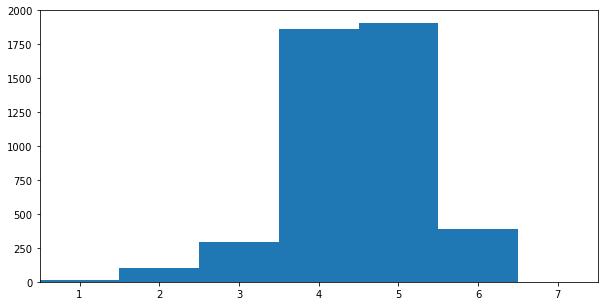

In [103]:
hist_results(T)

In [104]:
T = simulate(G, N, 8, 5)

Result 0: 5    acc: 5.0
Result 1: 5    acc: 5.0
Result 2: 4    acc: 4.666666666666667
Result 3: 4    acc: 4.5
Result 4: 5    acc: 4.6
Result 5: 5    acc: 4.666666666666667
Result 6: 5    acc: 4.714285714285714
Result 7: 5    acc: 4.75
Result 8: 5    acc: 4.777777777777778
Result 9: 5    acc: 4.8
Result 10: 5    acc: 4.818181818181818
Result 11: 5    acc: 4.833333333333333
Result 12: 5    acc: 4.846153846153846
Result 13: 5    acc: 4.857142857142857
Result 14: 1    acc: 4.6
Result 15: 1    acc: 4.375
Result 16: 1    acc: 4.176470588235294
Result 17: 1    acc: 4.0
Result 18: 1    acc: 3.8421052631578947
Result 19: 5    acc: 3.9
Result 20: 5    acc: 3.9523809523809526
Result 21: 5    acc: 4.0
Result 22: 5    acc: 4.043478260869565
Result 23: 5    acc: 4.083333333333333
Result 24: 1    acc: 3.96
Result 25: 4    acc: 3.9615384615384617
Result 26: 5    acc: 4.0
Result 27: 5    acc: 4.035714285714286
Result 28: 5    acc: 4.068965517241379
Result 29: 5    acc: 4.1
Result 30: 5    acc: 4.129032

Result 220: 4    acc: 4.46606334841629
Result 221: 4    acc: 4.463963963963964
Result 222: 4    acc: 4.461883408071749
Result 223: 4    acc: 4.459821428571429
Result 224: 5    acc: 4.4622222222222225
Result 225: 5    acc: 4.464601769911504
Result 226: 5    acc: 4.466960352422907
Result 227: 5    acc: 4.469298245614035
Result 228: 5    acc: 4.471615720524017
Result 229: 5    acc: 4.473913043478261
Result 230: 5    acc: 4.476190476190476
Result 231: 5    acc: 4.478448275862069
Result 232: 5    acc: 4.48068669527897
Result 233: 4    acc: 4.478632478632479
Result 234: 4    acc: 4.476595744680851
Result 235: 5    acc: 4.478813559322034
Result 236: 4    acc: 4.476793248945148
Result 237: 4    acc: 4.474789915966387
Result 238: 3    acc: 4.468619246861925
Result 239: 4    acc: 4.466666666666667
Result 240: 4    acc: 4.464730290456432
Result 241: 4    acc: 4.462809917355372
Result 242: 3    acc: 4.45679012345679
Result 243: 5    acc: 4.459016393442623
Result 244: 5    acc: 4.461224489795918
Re

Result 426: 5    acc: 4.224824355971897
Result 427: 3    acc: 4.22196261682243
Result 428: 3    acc: 4.2191142191142195
Result 429: 4    acc: 4.21860465116279
Result 430: 4    acc: 4.218097447795824
Result 431: 5    acc: 4.219907407407407
Result 432: 4    acc: 4.219399538106235
Result 433: 4    acc: 4.21889400921659
Result 434: 3    acc: 4.216091954022988
Result 435: 5    acc: 4.217889908256881
Result 436: 6    acc: 4.221967963386728
Result 437: 6    acc: 4.226027397260274
Result 438: 5    acc: 4.2277904328018225
Result 439: 5    acc: 4.2295454545454545
Result 440: 4    acc: 4.229024943310658
Result 441: 4    acc: 4.228506787330317
Result 442: 4    acc: 4.227990970654628
Result 443: 5    acc: 4.22972972972973
Result 444: 4    acc: 4.229213483146068
Result 445: 4    acc: 4.228699551569507
Result 446: 5    acc: 4.230425055928412
Result 447: 3    acc: 4.227678571428571
Result 448: 3    acc: 4.224944320712694
Result 449: 3    acc: 4.222222222222222
Result 450: 3    acc: 4.219512195121951
R

Result 635: 4    acc: 4.238993710691824
Result 636: 4    acc: 4.23861852433281
Result 637: 4    acc: 4.238244514106583
Result 638: 4    acc: 4.237871674491393
Result 639: 4    acc: 4.2375
Result 640: 4    acc: 4.237129485179407
Result 641: 4    acc: 4.2367601246105915
Result 642: 4    acc: 4.236391912908243
Result 643: 4    acc: 4.236024844720497
Result 644: 4    acc: 4.235658914728682
Result 645: 4    acc: 4.235294117647059
Result 646: 4    acc: 4.234930448222566
Result 647: 5    acc: 4.236111111111111
Result 648: 4    acc: 4.2357473035439135
Result 649: 4    acc: 4.235384615384615
Result 650: 3    acc: 4.233486943164363
Result 651: 4    acc: 4.233128834355829
Result 652: 5    acc: 4.234303215926493
Result 653: 3    acc: 4.232415902140673
Result 654: 4    acc: 4.23206106870229
Result 655: 3    acc: 4.2301829268292686
Result 656: 5    acc: 4.231354642313547
Result 657: 5    acc: 4.232522796352583
Result 658: 3    acc: 4.2306525037936265
Result 659: 3    acc: 4.2287878787878785
Result 6

Result 841: 4    acc: 4.176959619952494
Result 842: 5    acc: 4.177935943060498
Result 843: 5    acc: 4.178909952606635
Result 844: 5    acc: 4.179881656804734
Result 845: 5    acc: 4.180851063829787
Result 846: 5    acc: 4.181818181818182
Result 847: 4    acc: 4.181603773584905
Result 848: 4    acc: 4.181389870435807
Result 849: 5    acc: 4.182352941176471
Result 850: 5    acc: 4.18331374853114
Result 851: 5    acc: 4.184272300469484
Result 852: 4    acc: 4.184056271981243
Result 853: 5    acc: 4.1850117096018735
Result 854: 4    acc: 4.184795321637427
Result 855: 4    acc: 4.184579439252336
Result 856: 4    acc: 4.18436406067678
Result 857: 4    acc: 4.1841491841491845
Result 858: 4    acc: 4.183934807916182
Result 859: 4    acc: 4.183720930232558
Result 860: 4    acc: 4.183507549361208
Result 861: 4    acc: 4.183294663573085
Result 862: 4    acc: 4.183082271147161
Result 863: 4    acc: 4.18287037037037
Result 864: 4    acc: 4.182658959537572
Result 865: 4    acc: 4.182448036951501
R

Result 1046: 4    acc: 4.1241642788920725
Result 1047: 4    acc: 4.124045801526718
Result 1048: 4    acc: 4.123927550047664
Result 1049: 4    acc: 4.123809523809523
Result 1050: 4    acc: 4.1236917221693625
Result 1051: 4    acc: 4.123574144486692
Result 1052: 4    acc: 4.1234567901234565
Result 1053: 4    acc: 4.1233396584440225
Result 1054: 4    acc: 4.123222748815166
Result 1055: 3    acc: 4.122159090909091
Result 1056: 4    acc: 4.122043519394513
Result 1057: 4    acc: 4.121928166351607
Result 1058: 4    acc: 4.121813031161473
Result 1059: 4    acc: 4.121698113207547
Result 1060: 4    acc: 4.121583411875589
Result 1061: 4    acc: 4.121468926553672
Result 1062: 6    acc: 4.123236124176858
Result 1063: 4    acc: 4.1231203007518795
Result 1064: 3    acc: 4.122065727699531
Result 1065: 5    acc: 4.122889305816135
Result 1066: 4    acc: 4.122774133083412
Result 1067: 4    acc: 4.122659176029963
Result 1068: 5    acc: 4.123479887745557
Result 1069: 4    acc: 4.123364485981308
Result 1070

Result 1247: 6    acc: 4.1193910256410255
Result 1248: 6    acc: 4.120896717373899
Result 1249: 6    acc: 4.1224
Result 1250: 6    acc: 4.123900879296563
Result 1251: 5    acc: 4.124600638977636
Result 1252: 5    acc: 4.125299281723863
Result 1253: 5    acc: 4.1259968102073366
Result 1254: 5    acc: 4.126693227091634
Result 1255: 4    acc: 4.126592356687898
Result 1256: 4    acc: 4.126491646778043
Result 1257: 4    acc: 4.126391096979332
Result 1258: 4    acc: 4.126290706910246
Result 1259: 4    acc: 4.126190476190477
Result 1260: 4    acc: 4.12609040444092
Result 1261: 4    acc: 4.125990491283677
Result 1262: 4    acc: 4.1258907363420425
Result 1263: 5    acc: 4.1265822784810124
Result 1264: 5    acc: 4.127272727272727
Result 1265: 5    acc: 4.127962085308057
Result 1266: 5    acc: 4.128650355169692
Result 1267: 5    acc: 4.129337539432177
Result 1268: 5    acc: 4.130023640661938
Result 1269: 5    acc: 4.130708661417323
Result 1270: 5    acc: 4.1313926042486235
Result 1271: 4    acc: 

Result 1449: 4    acc: 4.148965517241379
Result 1450: 4    acc: 4.148862853204687
Result 1451: 4    acc: 4.148760330578512
Result 1452: 4    acc: 4.148657949070888
Result 1453: 4    acc: 4.148555708390647
Result 1454: 4    acc: 4.148453608247423
Result 1455: 4    acc: 4.148351648351649
Result 1456: 4    acc: 4.14824982841455
Result 1457: 4    acc: 4.148148148148148
Result 1458: 4    acc: 4.14804660726525
Result 1459: 4    acc: 4.147945205479452
Result 1460: 4    acc: 4.147843942505133
Result 1461: 4    acc: 4.147742818057456
Result 1462: 4    acc: 4.147641831852358
Result 1463: 4    acc: 4.147540983606557
Result 1464: 4    acc: 4.147440273037542
Result 1465: 4    acc: 4.147339699863575
Result 1466: 4    acc: 4.147239263803681
Result 1467: 4    acc: 4.147138964577657
Result 1468: 4    acc: 4.147038801906058
Result 1469: 4    acc: 4.146938775510204
Result 1470: 4    acc: 4.146838885112168
Result 1471: 4    acc: 4.146739130434782
Result 1472: 4    acc: 4.146639511201629
Result 1473: 4    

Result 1650: 5    acc: 4.1556632344033915
Result 1651: 5    acc: 4.156174334140436
Result 1652: 5    acc: 4.156684815486994
Result 1653: 5    acc: 4.157194679564691
Result 1654: 5    acc: 4.157703927492447
Result 1655: 5    acc: 4.158212560386473
Result 1656: 5    acc: 4.158720579360289
Result 1657: 5    acc: 4.159227985524729
Result 1658: 5    acc: 4.159734779987945
Result 1659: 5    acc: 4.160240963855422
Result 1660: 5    acc: 4.160746538229982
Result 1661: 5    acc: 4.161251504211793
Result 1662: 5    acc: 4.161755862898376
Result 1663: 5    acc: 4.162259615384615
Result 1664: 5    acc: 4.162762762762763
Result 1665: 5    acc: 4.163265306122449
Result 1666: 5    acc: 4.16376724655069
Result 1667: 5    acc: 4.164268585131895
Result 1668: 5    acc: 4.164769322947873
Result 1669: 4    acc: 4.164670658682635
Result 1670: 4    acc: 4.16457211250748
Result 1671: 4    acc: 4.1644736842105265
Result 1672: 5    acc: 4.164973102211596
Result 1673: 5    acc: 4.1654719235364395
Result 1674: 5 

Result 1851: 4    acc: 4.1690064794816415
Result 1852: 4    acc: 4.168915272531031
Result 1853: 4    acc: 4.168824163969795
Result 1854: 5    acc: 4.169272237196766
Result 1855: 5    acc: 4.169719827586207
Result 1856: 4    acc: 4.169628432956381
Result 1857: 4    acc: 4.169537136706135
Result 1858: 4    acc: 4.1694459386767075
Result 1859: 4    acc: 4.169354838709677
Result 1860: 4    acc: 4.169263836646964
Result 1861: 4    acc: 4.169172932330827
Result 1862: 5    acc: 4.169618894256575
Result 1863: 5    acc: 4.170064377682404
Result 1864: 4    acc: 4.169973190348525
Result 1865: 4    acc: 4.169882100750268
Result 1866: 4    acc: 4.169791108730584
Result 1867: 4    acc: 4.169700214132762
Result 1868: 4    acc: 4.169609416800428
Result 1869: 4    acc: 4.1695187165775405
Result 1870: 4    acc: 4.169428113308391
Result 1871: 5    acc: 4.169871794871795
Result 1872: 5    acc: 4.170315002669514
Result 1873: 5    acc: 4.1707577374599785
Result 1874: 5    acc: 4.1712
Result 1875: 3    acc: 

Result 2052: 4    acc: 4.1894788114953725
Result 2053: 4    acc: 4.189386562804284
Result 2054: 4    acc: 4.189294403892944
Result 2055: 4    acc: 4.18920233463035
Result 2056: 5    acc: 4.189596499756927
Result 2057: 4    acc: 4.189504373177843
Result 2058: 4    acc: 4.1894123360854785
Result 2059: 4    acc: 4.189320388349515
Result 2060: 4    acc: 4.189228529839884
Result 2061: 4    acc: 4.18913676042677
Result 2062: 4    acc: 4.189045079980611
Result 2063: 4    acc: 4.188953488372093
Result 2064: 4    acc: 4.188861985472155
Result 2065: 4    acc: 4.188770571151984
Result 2066: 4    acc: 4.188679245283019
Result 2067: 4    acc: 4.188588007736944
Result 2068: 6    acc: 4.189463508941517
Result 2069: 5    acc: 4.189855072463768
Result 2070: 3    acc: 4.189280540801545
Result 2071: 3    acc: 4.188706563706564
Result 2072: 4    acc: 4.188615533043897
Result 2073: 4    acc: 4.188524590163935
Result 2074: 4    acc: 4.188433734939759
Result 2075: 4    acc: 4.188342967244702
Result 2076: 4  

Result 2253: 4    acc: 4.133984028393966
Result 2254: 4    acc: 4.133924611973392
Result 2255: 4    acc: 4.13386524822695
Result 2256: 4    acc: 4.133805937084626
Result 2257: 3    acc: 4.133303808680248
Result 2258: 4    acc: 4.133244798583444
Result 2259: 3    acc: 4.132743362831858
Result 2260: 3    acc: 4.132242370632463
Result 2261: 4    acc: 4.132183908045977
Result 2262: 4    acc: 4.132125497127706
Result 2263: 4    acc: 4.132067137809187
Result 2264: 4    acc: 4.132008830022075
Result 2265: 5    acc: 4.132391879964696
Result 2266: 5    acc: 4.132774591971769
Result 2267: 5    acc: 4.1331569664903
Result 2268: 4    acc: 4.133098281181137
Result 2269: 5    acc: 4.133480176211454
Result 2270: 5    acc: 4.133861734918538
Result 2271: 5    acc: 4.134242957746479
Result 2272: 5    acc: 4.1346238451385835
Result 2273: 5    acc: 4.135004397537379
Result 2274: 5    acc: 4.135384615384615
Result 2275: 4    acc: 4.135325131810193
Result 2276: 5    acc: 4.13570487483531
Result 2277: 4    a

Result 2454: 5    acc: 4.125050916496945
Result 2455: 3    acc: 4.124592833876221
Result 2456: 3    acc: 4.124135124135124
Result 2457: 3    acc: 4.1236777868185515
Result 2458: 3    acc: 4.1232208214721435
Result 2459: 3    acc: 4.122764227642277
Result 2460: 3    acc: 4.122308004876067
Result 2461: 3    acc: 4.121852152721365
Result 2462: 3    acc: 4.121396670726756
Result 2463: 3    acc: 4.120941558441558
Result 2464: 3    acc: 4.120486815415822
Result 2465: 3    acc: 4.120032441200324
Result 2466: 3    acc: 4.1195784353465745
Result 2467: 3    acc: 4.1191247974068075
Result 2468: 3    acc: 4.118671526933982
Result 2469: 3    acc: 4.1182186234817815
Result 2470: 3    acc: 4.117766086604614
Result 2471: 3    acc: 4.117313915857605
Result 2472: 3    acc: 4.116862110796603
Result 2473: 3    acc: 4.116410670978173
Result 2474: 3    acc: 4.115959595959596
Result 2475: 3    acc: 4.115508885298869
Result 2476: 3    acc: 4.115058538554703
Result 2477: 3    acc: 4.114608555286521
Result 2478

Result 2657: 4    acc: 4.085402558314522
Result 2658: 4    acc: 4.085370440015043
Result 2659: 4    acc: 4.0853383458646615
Result 2660: 4    acc: 4.085306275836152
Result 2661: 4    acc: 4.085274229902329
Result 2662: 4    acc: 4.08524220803605
Result 2663: 4    acc: 4.08521021021021
Result 2664: 5    acc: 4.085553470919325
Result 2665: 5    acc: 4.085896474118529
Result 2666: 4    acc: 4.085864266966629
Result 2667: 4    acc: 4.085832083958021
Result 2668: 4    acc: 4.085799925065568
Result 2669: 4    acc: 4.085767790262172
Result 2670: 4    acc: 4.085735679520779
Result 2671: 4    acc: 4.0857035928143715
Result 2672: 4    acc: 4.085671530115975
Result 2673: 4    acc: 4.085639491398654
Result 2674: 4    acc: 4.085607476635514
Result 2675: 4    acc: 4.085575485799701
Result 2676: 5    acc: 4.085917071348525
Result 2677: 5    acc: 4.086258401792382
Result 2678: 5    acc: 4.0865994774169465
Result 2679: 5    acc: 4.0869402985074625
Result 2680: 4    acc: 4.086907870197687
Result 2681: 4

Result 2859: 4    acc: 4.086363636363636
Result 2860: 4    acc: 4.086333449842712
Result 2861: 4    acc: 4.086303284416492
Result 2862: 4    acc: 4.086273140062871
Result 2863: 4    acc: 4.086243016759776
Result 2864: 4    acc: 4.0862129144851655
Result 2865: 4    acc: 4.086182833217027
Result 2866: 3    acc: 4.085803976281828
Result 2867: 4    acc: 4.085774058577406
Result 2868: 4    acc: 4.085744161728825
Result 2869: 4    acc: 4.085714285714285
Result 2870: 4    acc: 4.085684430512017
Result 2871: 4    acc: 4.085654596100278
Result 2872: 4    acc: 4.085624782457361
Result 2873: 4    acc: 4.085594989561587
Result 2874: 4    acc: 4.085565217391304
Result 2875: 4    acc: 4.085535465924895
Result 2876: 4    acc: 4.085505735140772
Result 2877: 4    acc: 4.085476025017373
Result 2878: 3    acc: 4.085098992705801
Result 2879: 3    acc: 4.084722222222222
Result 2880: 3    acc: 4.084345713293995
Result 2881: 3    acc: 4.083969465648855
Result 2882: 3    acc: 4.083593479014915
Result 2883: 4 

Result 3059: 4    acc: 4.0434640522875815
Result 3060: 4    acc: 4.0434498529892196
Result 3061: 4    acc: 4.043435662965382
Result 3062: 4    acc: 4.043421482206987
Result 3063: 4    acc: 4.043407310704961
Result 3064: 4    acc: 4.043393148450245
Result 3065: 4    acc: 4.04337899543379
Result 3066: 4    acc: 4.04336485164656
Result 3067: 4    acc: 4.04335071707953
Result 3068: 4    acc: 4.043336591723689
Result 3069: 5    acc: 4.0436482084690555
Result 3070: 5    acc: 4.043959622272875
Result 3071: 5    acc: 4.044270833333333
Result 3072: 5    acc: 4.044581841848356
Result 3073: 5    acc: 4.044892648015614
Result 3074: 5    acc: 4.04520325203252
Result 3075: 5    acc: 4.045513654096228
Result 3076: 5    acc: 4.04582385440364
Result 3077: 4    acc: 4.045808966861599
Result 3078: 4    acc: 4.045794088989932
Result 3079: 4    acc: 4.045779220779221
Result 3080: 4    acc: 4.0457643622200585
Result 3081: 4    acc: 4.04574951330305
Result 3082: 4    acc: 4.045734674018813
Result 3083: 5    

Result 3260: 4    acc: 4.060717571297148
Result 3261: 4    acc: 4.060698957694666
Result 3262: 5    acc: 4.060986821942997
Result 3263: 3    acc: 4.060661764705882
Result 3264: 3    acc: 4.060336906584992
Result 3265: 3    acc: 4.060012247397428
Result 3266: 3    acc: 4.059687786960514
Result 3267: 4    acc: 4.059669522643818
Result 3268: 4    acc: 4.0596512695013764
Result 3269: 3    acc: 4.059327217125382
Result 3270: 3    acc: 4.059003362885967
Result 3271: 3    acc: 4.058679706601467
Result 3272: 3    acc: 4.058356248090437
Result 3273: 5    acc: 4.058643860720831
Result 3274: 4    acc: 4.058625954198473
Result 3275: 3    acc: 4.058302808302808
Result 3276: 4    acc: 4.0582850167836435
Result 3277: 5    acc: 4.058572300183038
Result 3278: 4    acc: 4.0585544373284534
Result 3279: 4    acc: 4.058536585365854
Result 3280: 4    acc: 4.058518744285279
Result 3281: 5    acc: 4.058805606337599
Result 3282: 4    acc: 4.058787694182151
Result 3283: 4    acc: 4.058769792935444
Result 3284: 

Result 3461: 4    acc: 4.062391681109186
Result 3462: 4    acc: 4.062373664452787
Result 3463: 4    acc: 4.062355658198614
Result 3464: 5    acc: 4.062626262626263
Result 3465: 5    acc: 4.062896710905943
Result 3466: 5    acc: 4.063167003172772
Result 3467: 5    acc: 4.063437139561707
Result 3468: 5    acc: 4.063707120207552
Result 3469: 5    acc: 4.063976945244956
Result 3470: 5    acc: 4.064246614808413
Result 3471: 5    acc: 4.064516129032258
Result 3472: 5    acc: 4.064785488050677
Result 3473: 4    acc: 4.064766839378239
Result 3474: 4    acc: 4.0647482014388485
Result 3475: 4    acc: 4.064729574223245
Result 3476: 5    acc: 4.064998561978717
Result 3477: 5    acc: 4.065267395054629
Result 3478: 6    acc: 4.065823512503593
Result 3479: 6    acc: 4.066379310344828
Result 3480: 5    acc: 4.066647515081873
Result 3481: 5    acc: 4.0669155657668
Result 3482: 6    acc: 4.06747057134654
Result 3483: 6    acc: 4.0680252583237655
Result 3484: 4    acc: 4.0680057388809185
Result 3485: 4  

Result 3661: 4    acc: 4.073730202075368
Result 3662: 4    acc: 4.073710073710074
Result 3663: 4    acc: 4.073689956331878
Result 3664: 6    acc: 4.074215552523874
Result 3665: 5    acc: 4.074468085106383
Result 3666: 4    acc: 4.074447777474775
Result 3667: 5    acc: 4.074700109051254
Result 3668: 4    acc: 4.074679749250477
Result 3669: 4    acc: 4.0746594005449595
Result 3670: 4    acc: 4.074639062925633
Result 3671: 4    acc: 4.074618736383442
Result 3672: 4    acc: 4.074598420909338
Result 3673: 4    acc: 4.074578116494284
Result 3674: 5    acc: 4.074829931972789
Result 3675: 5    acc: 4.075081610446137
Result 3676: 5    acc: 4.075333152026108
Result 3677: 5    acc: 4.075584556824361
Result 3678: 4    acc: 4.075564011959772
Result 3679: 5    acc: 4.0758152173913045
Result 3680: 4    acc: 4.075794621026895
Result 3681: 3    acc: 4.075502444323737
Result 3682: 3    acc: 4.075210426282921
Result 3683: 3    acc: 4.074918566775244
Result 3684: 3    acc: 4.074626865671642
Result 3685: 4

Result 3862: 4    acc: 4.068599534040901
Result 3863: 4    acc: 4.068581780538302
Result 3864: 4    acc: 4.06856403622251
Result 3865: 4    acc: 4.0685463010863945
Result 3866: 4    acc: 4.068528575122834
Result 3867: 4    acc: 4.068510858324716
Result 3868: 4    acc: 4.068493150684931
Result 3869: 4    acc: 4.068475452196383
Result 3870: 4    acc: 4.068457762851976
Result 3871: 4    acc: 4.068440082644628
Result 3872: 4    acc: 4.06842241156726
Result 3873: 4    acc: 4.068404749612803
Result 3874: 3    acc: 4.0681290322580645
Result 3875: 3    acc: 4.067853457172343
Result 3876: 4    acc: 4.067835955635801
Result 3877: 4    acc: 4.067818463125322
Result 3878: 4    acc: 4.067800979633926
Result 3879: 3    acc: 4.067525773195876
Result 3880: 4    acc: 4.067508374130378
Result 3881: 5    acc: 4.0677485832045335
Result 3882: 5    acc: 4.067988668555241
Result 3883: 4    acc: 4.067971163748712
Result 3884: 5    acc: 4.068211068211069
Result 3885: 5    acc: 4.068450849202264
Result 3886: 5 

Result 4064: 4    acc: 4.077244772447725
Result 4065: 4    acc: 4.077225774717167
Result 4066: 4    acc: 4.07720678632899
Result 4067: 4    acc: 4.077187807276303
Result 4068: 4    acc: 4.077168837552224
Result 4069: 5    acc: 4.077395577395578
Result 4070: 5    acc: 4.07762220584623
Result 4071: 5    acc: 4.077848722986247
Result 4072: 4    acc: 4.077829609624356
Result 4073: 4    acc: 4.077810505645557
Result 4074: 4    acc: 4.077791411042945
Result 4075: 5    acc: 4.07801766437684
Result 4076: 4    acc: 4.077998528329654
Result 4077: 5    acc: 4.078224619911722
Result 4078: 5    acc: 4.078450600637411
Result 4079: 5    acc: 4.078676470588236
Result 4080: 4    acc: 4.078657191864739
Result 4081: 5    acc: 4.078882900538951
Result 4082: 5    acc: 4.0791084986529516
Result 4083: 4    acc: 4.079089128305583
Result 4084: 4    acc: 4.079069767441861
Result 4085: 5    acc: 4.079295154185022
Result 4086: 4    acc: 4.079275752385613
Result 4087: 4    acc: 4.079256360078278
Result 4088: 4    

Result 4264: 4    acc: 4.091676436107854
Result 4265: 4    acc: 4.091654946085326
Result 4266: 4    acc: 4.091633466135458
Result 4267: 4    acc: 4.091611996251172
Result 4268: 4    acc: 4.091590536425392
Result 4269: 5    acc: 4.091803278688524
Result 4270: 4    acc: 4.091781784125498
Result 4271: 5    acc: 4.091994382022472
Result 4272: 5    acc: 4.092206880411888
Result 4273: 5    acc: 4.092419279363594
Result 4274: 5    acc: 4.092631578947368
Result 4275: 5    acc: 4.092843779232928
Result 4276: 5    acc: 4.093055880289922
Result 4277: 4    acc: 4.0930341280972415
Result 4278: 4    acc: 4.093012386071512
Result 4279: 4    acc: 4.092990654205607
Result 4280: 4    acc: 4.092968932492409
Result 4281: 5    acc: 4.0931807566557685
Result 4282: 5    acc: 4.093392481905207
Result 4283: 5    acc: 4.09360410830999
Result 4284: 4    acc: 4.093582263710618
Result 4285: 4    acc: 4.093560429304713
Result 4286: 5    acc: 4.093771868439468
Result 4287: 5    acc: 4.0939832089552235
Result 4288: 5

Result 4465: 4    acc: 4.093148231079265
Result 4466: 4    acc: 4.093127378553839
Result 4467: 4    acc: 4.093106535362578
Result 4468: 5    acc: 4.093309465204744
Result 4469: 4    acc: 4.093288590604027
Result 4470: 4    acc: 4.093267725341087
Result 4471: 4    acc: 4.09324686940966
Result 4472: 5    acc: 4.093449586407333
Result 4473: 5    acc: 4.0936522127849795
Result 4474: 5    acc: 4.093854748603352
Result 4475: 4    acc: 4.093833780160858
Result 4476: 3    acc: 4.0935894572258205
Result 4477: 4    acc: 4.093568557391693
Result 4478: 4    acc: 4.093547666889931
Result 4479: 5    acc: 4.09375
Result 4480: 4    acc: 4.09372907833073
Result 4481: 5    acc: 4.093931280678269
Result 4482: 5    acc: 4.09413339281731
Result 4483: 4    acc: 4.094112399643175
Result 4484: 5    acc: 4.094314381270903
Result 4485: 5    acc: 4.094516272848863
Result 4486: 5    acc: 4.094718074437263
Result 4487: 5    acc: 4.0949197860962565
Result 4488: 5    acc: 4.0951214078859435
Result 4489: 5    acc: 4.

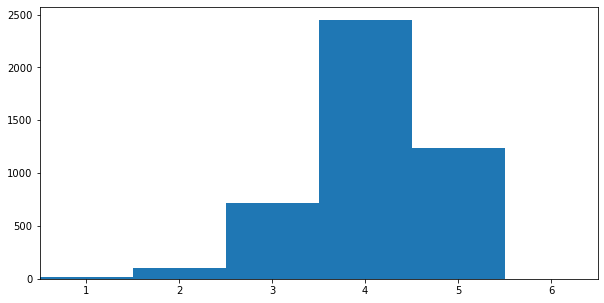

In [105]:
hist_results(T)

In [106]:
T = simulate(G, N, 8, 6)

Result 0: 4    acc: 4.0
Result 1: 4    acc: 4.0
Result 2: 4    acc: 4.0
Result 3: 4    acc: 4.0
Result 4: 5    acc: 4.2
Result 5: 4    acc: 4.166666666666667
Result 6: 4    acc: 4.142857142857143
Result 7: 4    acc: 4.125
Result 8: 4    acc: 4.111111111111111
Result 9: 4    acc: 4.1
Result 10: 4    acc: 4.090909090909091
Result 11: 5    acc: 4.166666666666667
Result 12: 5    acc: 4.230769230769231
Result 13: 5    acc: 4.285714285714286
Result 14: 1    acc: 4.066666666666666
Result 15: 1    acc: 3.875
Result 16: 1    acc: 3.7058823529411766
Result 17: 1    acc: 3.5555555555555554
Result 18: 1    acc: 3.4210526315789473
Result 19: 5    acc: 3.5
Result 20: 5    acc: 3.5714285714285716
Result 21: 5    acc: 3.6363636363636362
Result 22: 5    acc: 3.6956521739130435
Result 23: 5    acc: 3.75
Result 24: 1    acc: 3.64
Result 25: 4    acc: 3.6538461538461537
Result 26: 5    acc: 3.7037037037037037
Result 27: 5    acc: 3.75
Result 28: 5    acc: 3.793103448275862
Result 29: 5    acc: 3.833333333

Result 218: 3    acc: 4.264840182648402
Result 219: 3    acc: 4.259090909090909
Result 220: 4    acc: 4.257918552036199
Result 221: 4    acc: 4.256756756756757
Result 222: 4    acc: 4.255605381165919
Result 223: 4    acc: 4.254464285714286
Result 224: 5    acc: 4.257777777777778
Result 225: 5    acc: 4.261061946902655
Result 226: 5    acc: 4.26431718061674
Result 227: 5    acc: 4.267543859649122
Result 228: 4    acc: 4.2663755458515285
Result 229: 5    acc: 4.269565217391304
Result 230: 5    acc: 4.2727272727272725
Result 231: 5    acc: 4.275862068965517
Result 232: 4    acc: 4.274678111587983
Result 233: 4    acc: 4.273504273504273
Result 234: 4    acc: 4.272340425531915
Result 235: 5    acc: 4.27542372881356
Result 236: 4    acc: 4.274261603375527
Result 237: 4    acc: 4.273109243697479
Result 238: 4    acc: 4.2719665271966525
Result 239: 5    acc: 4.275
Result 240: 4    acc: 4.273858921161826
Result 241: 4    acc: 4.2727272727272725
Result 242: 3    acc: 4.267489711934156
Result 243

Result 425: 4    acc: 4.082159624413146
Result 426: 5    acc: 4.0843091334894615
Result 427: 3    acc: 4.081775700934579
Result 428: 3    acc: 4.0792540792540795
Result 429: 4    acc: 4.079069767441861
Result 430: 4    acc: 4.078886310904872
Result 431: 5    acc: 4.081018518518518
Result 432: 4    acc: 4.080831408775982
Result 433: 4    acc: 4.080645161290323
Result 434: 3    acc: 4.07816091954023
Result 435: 5    acc: 4.080275229357798
Result 436: 4    acc: 4.080091533180778
Result 437: 4    acc: 4.079908675799087
Result 438: 4    acc: 4.079726651480637
Result 439: 4    acc: 4.079545454545454
Result 440: 4    acc: 4.079365079365079
Result 441: 4    acc: 4.079185520361991
Result 442: 4    acc: 4.07900677200903
Result 443: 5    acc: 4.081081081081081
Result 444: 4    acc: 4.080898876404494
Result 445: 4    acc: 4.0807174887892375
Result 446: 5    acc: 4.082774049217003
Result 447: 3    acc: 4.080357142857143
Result 448: 3    acc: 4.077951002227172
Result 449: 3    acc: 4.075555555555556

Result 631: 3    acc: 4.112341772151899
Result 632: 4    acc: 4.1121642969984205
Result 633: 4    acc: 4.11198738170347
Result 634: 4    acc: 4.111811023622047
Result 635: 4    acc: 4.111635220125786
Result 636: 4    acc: 4.1114599686028255
Result 637: 4    acc: 4.11128526645768
Result 638: 4    acc: 4.111111111111111
Result 639: 4    acc: 4.1109375
Result 640: 4    acc: 4.110764430577223
Result 641: 4    acc: 4.110591900311526
Result 642: 4    acc: 4.110419906687403
Result 643: 4    acc: 4.1102484472049685
Result 644: 4    acc: 4.110077519379845
Result 645: 4    acc: 4.109907120743034
Result 646: 4    acc: 4.109737248840804
Result 647: 5    acc: 4.111111111111111
Result 648: 4    acc: 4.110939907550077
Result 649: 4    acc: 4.110769230769231
Result 650: 3    acc: 4.109062980030722
Result 651: 4    acc: 4.108895705521473
Result 652: 4    acc: 4.108728943338438
Result 653: 3    acc: 4.107033639143731
Result 654: 4    acc: 4.106870229007634
Result 655: 3    acc: 4.1051829268292686
Result

Result 837: 4    acc: 4.0250596658711215
Result 838: 4    acc: 4.02502979737783
Result 839: 4    acc: 4.025
Result 840: 4    acc: 4.024970273483948
Result 841: 4    acc: 4.024940617577197
Result 842: 4    acc: 4.02491103202847
Result 843: 4    acc: 4.024881516587678
Result 844: 4    acc: 4.024852071005917
Result 845: 4    acc: 4.024822695035461
Result 846: 4    acc: 4.024793388429752
Result 847: 4    acc: 4.024764150943396
Result 848: 4    acc: 4.024734982332156
Result 849: 4    acc: 4.024705882352941
Result 850: 4    acc: 4.024676850763807
Result 851: 4    acc: 4.024647887323944
Result 852: 4    acc: 4.02461899179367
Result 853: 5    acc: 4.02576112412178
Result 854: 4    acc: 4.025730994152047
Result 855: 4    acc: 4.025700934579439
Result 856: 4    acc: 4.025670945157526
Result 857: 4    acc: 4.0256410256410255
Result 858: 4    acc: 4.025611175785797
Result 859: 4    acc: 4.025581395348837
Result 860: 4    acc: 4.02555168408827
Result 861: 4    acc: 4.025522041763341
Result 862: 4  

Result 1042: 4    acc: 3.99137104506232
Result 1043: 4    acc: 3.9913793103448274
Result 1044: 4    acc: 3.9913875598086124
Result 1045: 4    acc: 3.991395793499044
Result 1046: 4    acc: 3.991404011461318
Result 1047: 4    acc: 3.991412213740458
Result 1048: 4    acc: 3.9914204003813154
Result 1049: 4    acc: 3.9914285714285715
Result 1050: 4    acc: 3.9914367269267363
Result 1051: 4    acc: 3.991444866920152
Result 1052: 4    acc: 3.9914529914529915
Result 1053: 4    acc: 3.99146110056926
Result 1054: 4    acc: 3.991469194312796
Result 1055: 4    acc: 3.991477272727273
Result 1056: 3    acc: 3.9905392620624407
Result 1057: 3    acc: 3.989603024574669
Result 1058: 3    acc: 3.988668555240793
Result 1059: 3    acc: 3.987735849056604
Result 1060: 3    acc: 3.986804901036758
Result 1061: 4    acc: 3.9868173258003767
Result 1062: 6    acc: 3.988711194731891
Result 1063: 4    acc: 3.988721804511278
Result 1064: 3    acc: 3.987793427230047
Result 1065: 5    acc: 3.9887429643527206
Result 10

Result 1241: 5    acc: 3.949275362318841
Result 1242: 5    acc: 3.9501206757843925
Result 1243: 5    acc: 3.9509646302250805
Result 1244: 5    acc: 3.9518072289156625
Result 1245: 5    acc: 3.952648475120385
Result 1246: 5    acc: 3.953488372093023
Result 1247: 4    acc: 3.953525641025641
Result 1248: 4    acc: 3.9535628502802243
Result 1249: 5    acc: 3.9544
Result 1250: 5    acc: 3.9552358113509194
Result 1251: 5    acc: 3.9560702875399363
Result 1252: 5    acc: 3.956903431763767
Result 1253: 5    acc: 3.9577352472089316
Result 1254: 5    acc: 3.958565737051793
Result 1255: 4    acc: 3.9585987261146496
Result 1256: 4    acc: 3.958631662688942
Result 1257: 4    acc: 3.958664546899841
Result 1258: 4    acc: 3.9586973788721207
Result 1259: 4    acc: 3.958730158730159
Result 1260: 4    acc: 3.9587628865979383
Result 1261: 4    acc: 3.958795562599049
Result 1262: 4    acc: 3.9588281868566906
Result 1263: 4    acc: 3.9588607594936707
Result 1264: 4    acc: 3.958893280632411
Result 1265: 4 

Result 1439: 4    acc: 3.9819444444444443
Result 1440: 4    acc: 3.9819569743233867
Result 1441: 4    acc: 3.9819694868238558
Result 1442: 4    acc: 3.981981981981982
Result 1443: 4    acc: 3.981994459833795
Result 1444: 4    acc: 3.982006920415225
Result 1445: 4    acc: 3.9820193637621024
Result 1446: 4    acc: 3.982031789910159
Result 1447: 5    acc: 3.9827348066298343
Result 1448: 5    acc: 3.9834368530020705
Result 1449: 3    acc: 3.9827586206896552
Result 1450: 3    acc: 3.982081323225362
Result 1451: 3    acc: 3.981404958677686
Result 1452: 3    acc: 3.9807295251204406
Result 1453: 3    acc: 3.9800550206327374
Result 1454: 3    acc: 3.979381443298969
Result 1455: 3    acc: 3.978708791208791
Result 1456: 3    acc: 3.9780370624571035
Result 1457: 3    acc: 3.977366255144033
Result 1458: 4    acc: 3.977381768334476
Result 1459: 3    acc: 3.9767123287671233
Result 1460: 4    acc: 3.976728268309377
Result 1461: 4    acc: 3.9767441860465116
Result 1462: 4    acc: 3.97676008202324
Resul

Result 1637: 4    acc: 3.9865689865689866
Result 1638: 4    acc: 3.9865771812080535
Result 1639: 4    acc: 3.9865853658536587
Result 1640: 4    acc: 3.986593540524071
Result 1641: 4    acc: 3.9866017052375153
Result 1642: 4    acc: 3.9866098600121727
Result 1643: 4    acc: 3.98661800486618
Result 1644: 4    acc: 3.9866261398176293
Result 1645: 5    acc: 3.9872417982989066
Result 1646: 5    acc: 3.9878567091681845
Result 1647: 5    acc: 3.9884708737864076
Result 1648: 4    acc: 3.9884778653729533
Result 1649: 5    acc: 3.9890909090909092
Result 1650: 5    acc: 3.989703210175651
Result 1651: 5    acc: 3.990314769975787
Result 1652: 5    acc: 3.9909255898366607
Result 1653: 5    acc: 3.9915356711003627
Result 1654: 5    acc: 3.99214501510574
Result 1655: 5    acc: 3.9927536231884058
Result 1656: 5    acc: 3.9933614966807482
Result 1657: 5    acc: 3.993968636911942
Result 1658: 5    acc: 3.9945750452079567
Result 1659: 5    acc: 3.995180722891566
Result 1660: 5    acc: 3.99578567128236
Res

Result 1839: 4    acc: 4.0125
Result 1840: 4    acc: 4.012493210211842
Result 1841: 4    acc: 4.012486427795874
Result 1842: 4    acc: 4.012479652740097
Result 1843: 5    acc: 4.0130151843817785
Result 1844: 4    acc: 4.0130081300813005
Result 1845: 4    acc: 4.013001083423618
Result 1846: 4    acc: 4.012994044396319
Result 1847: 3    acc: 4.012445887445887
Result 1848: 4    acc: 4.012439156300703
Result 1849: 3    acc: 4.011891891891892
Result 1850: 3    acc: 4.011345218800648
Result 1851: 4    acc: 4.0113390928725705
Result 1852: 4    acc: 4.011332973556395
Result 1853: 3    acc: 4.010787486515642
Result 1854: 5    acc: 4.011320754716981
Result 1855: 5    acc: 4.011853448275862
Result 1856: 4    acc: 4.011847065158858
Result 1857: 4    acc: 4.01184068891281
Result 1858: 4    acc: 4.011834319526627
Result 1859: 4    acc: 4.011827956989247
Result 1860: 4    acc: 4.011821601289629
Result 1861: 4    acc: 4.011815252416756
Result 1862: 5    acc: 4.012345679012346
Result 1863: 5    acc: 4.

Result 2040: 4    acc: 4.023517883390495
Result 2041: 4    acc: 4.023506366307542
Result 2042: 5    acc: 4.023984336759667
Result 2043: 5    acc: 4.024461839530333
Result 2044: 4    acc: 4.0244498777506115
Result 2045: 4    acc: 4.024437927663734
Result 2046: 4    acc: 4.024425989252565
Result 2047: 4    acc: 4.0244140625
Result 2048: 4    acc: 4.024402147388971
Result 2049: 4    acc: 4.024390243902439
Result 2050: 4    acc: 4.024378352023403
Result 2051: 4    acc: 4.024366471734893
Result 2052: 4    acc: 4.024354603019971
Result 2053: 4    acc: 4.024342745861733
Result 2054: 4    acc: 4.024330900243309
Result 2055: 4    acc: 4.02431906614786
Result 2056: 5    acc: 4.024793388429752
Result 2057: 4    acc: 4.024781341107872
Result 2058: 4    acc: 4.024769305488101
Result 2059: 4    acc: 4.024757281553398
Result 2060: 4    acc: 4.024745269286754
Result 2061: 4    acc: 4.024733268671193
Result 2062: 4    acc: 4.024721279689772
Result 2063: 4    acc: 4.024709302325581
Result 2064: 4    acc

Result 2240: 2    acc: 3.9759036144578315
Result 2241: 2    acc: 3.975022301516503
Result 2242: 2    acc: 3.974141774409273
Result 2243: 2    acc: 3.9732620320855614
Result 2244: 2    acc: 3.972383073496659
Result 2245: 2    acc: 3.9715048975957257
Result 2246: 2    acc: 3.970627503337784
Result 2247: 2    acc: 3.969750889679715
Result 2248: 5    acc: 3.9702089817696753
Result 2249: 3    acc: 3.969777777777778
Result 2250: 3    acc: 3.969346956908041
Result 2251: 3    acc: 3.9689165186500888
Result 2252: 3    acc: 3.968486462494452
Result 2253: 3    acc: 3.9680567879325643
Result 2254: 4    acc: 3.9680709534368073
Result 2255: 3    acc: 3.967641843971631
Result 2256: 4    acc: 3.967656180770935
Result 2257: 4    acc: 3.9676705048715677
Result 2258: 4    acc: 3.967684816290394
Result 2259: 4    acc: 3.967699115044248
Result 2260: 4    acc: 3.9677134011499335
Result 2261: 4    acc: 3.9677276746242263
Result 2262: 4    acc: 3.967741935483871
Result 2263: 4    acc: 3.9677561837455833
Resul

Result 2438: 4    acc: 3.952029520295203
Result 2439: 4    acc: 3.952049180327869
Result 2440: 4    acc: 3.9520688242523554
Result 2441: 4    acc: 3.9520884520884523
Result 2442: 4    acc: 3.9521080638559147
Result 2443: 4    acc: 3.952127659574468
Result 2444: 4    acc: 3.9521472392638035
Result 2445: 5    acc: 3.9525756336876534
Result 2446: 4    acc: 3.9525950143032285
Result 2447: 3    acc: 3.952205882352941
Result 2448: 3    acc: 3.9518170681910982
Result 2449: 4    acc: 3.9518367346938774
Result 2450: 3    acc: 3.9514483884128926
Result 2451: 3    acc: 3.9510603588907016
Result 2452: 3    acc: 3.9506726457399104
Result 2453: 3    acc: 3.950285248573757
Result 2454: 4    acc: 3.95030549898167
Result 2455: 3    acc: 3.9499185667752443
Result 2456: 3    acc: 3.9495319495319494
Result 2457: 3    acc: 3.949145646867372
Result 2458: 3    acc: 3.9487596583977225
Result 2459: 3    acc: 3.9483739837398373
Result 2460: 3    acc: 3.947988622511174
Result 2461: 3    acc: 3.947603574329813
Re

Result 2636: 4    acc: 3.906332954114524
Result 2637: 4    acc: 3.906368460955269
Result 2638: 4    acc: 3.9064039408866993
Result 2639: 4    acc: 3.9064393939393938
Result 2640: 4    acc: 3.906474820143885
Result 2641: 4    acc: 3.9065102195306585
Result 2642: 4    acc: 3.906545592130155
Result 2643: 4    acc: 3.9065809379727687
Result 2644: 4    acc: 3.9066162570888467
Result 2645: 4    acc: 3.9066515495086924
Result 2646: 4    acc: 3.9066868152625616
Result 2647: 4    acc: 3.9067220543806647
Result 2648: 4    acc: 3.9067572668931674
Result 2649: 4    acc: 3.9067924528301887
Result 2650: 4    acc: 3.9068276122218033
Result 2651: 4    acc: 3.906862745098039
Result 2652: 4    acc: 3.9068978514888806
Result 2653: 4    acc: 3.906932931424265
Result 2654: 4    acc: 3.9069679849340866
Result 2655: 4    acc: 3.9070030120481927
Result 2656: 4    acc: 3.907038012796387
Result 2657: 4    acc: 3.9070729872084273
Result 2658: 4    acc: 3.907107935314028
Result 2659: 4    acc: 3.907142857142857
R

Result 2834: 4    acc: 3.916049382716049
Result 2835: 4    acc: 3.9160789844851904
Result 2836: 5    acc: 3.9164610504053576
Result 2837: 5    acc: 3.9168428470754053
Result 2838: 4    acc: 3.9168721380767875
Result 2839: 4    acc: 3.916901408450704
Result 2840: 4    acc: 3.916930658218937
Result 2841: 3    acc: 3.9166080225193527
Result 2842: 3    acc: 3.916285613788252
Result 2843: 3    acc: 3.9159634317862166
Result 2844: 3    acc: 3.9156414762741654
Result 2845: 3    acc: 3.9153197470133523
Result 2846: 3    acc: 3.914998243765367
Result 2847: 3    acc: 3.914676966292135
Result 2848: 3    acc: 3.9143559143559146
Result 2849: 4    acc: 3.9143859649122805
Result 2850: 4    acc: 3.914415994387934
Result 2851: 4    acc: 3.914446002805049
Result 2852: 4    acc: 3.9144759901857693
Result 2853: 4    acc: 3.9145059565522073
Result 2854: 4    acc: 3.914535901926445
Result 2855: 4    acc: 3.914565826330532
Result 2856: 4    acc: 3.9145957297864893
Result 2857: 4    acc: 3.9146256123163052
Re

Result 3033: 2    acc: 3.8843111404087014
Result 3034: 2    acc: 3.8836902800658977
Result 3035: 2    acc: 3.8830698287220025
Result 3036: 2    acc: 3.882449785973
Result 3037: 2    acc: 3.881830151415405
Result 3038: 2    acc: 3.881210924646265
Result 3039: 2    acc: 3.880592105263158
Result 3040: 2    acc: 3.8799736928641892
Result 3041: 2    acc: 3.879355687047995
Result 3042: 2    acc: 3.8787380874137365
Result 3043: 2    acc: 3.878120893561104
Result 3044: 2    acc: 3.877504105090312
Result 3045: 2    acc: 3.876887721602101
Result 3046: 2    acc: 3.8762717426977353
Result 3047: 2    acc: 3.8756561679790025
Result 3048: 2    acc: 3.8750409970482127
Result 3049: 2    acc: 3.8744262295081966
Result 3050: 3    acc: 3.8741396263520156
Result 3051: 3    acc: 3.873853211009174
Result 3052: 3    acc: 3.8735669832951194
Result 3053: 3    acc: 3.87328094302554
Result 3054: 2    acc: 3.8726677577741406
Result 3055: 2    acc: 3.8720549738219896
Result 3056: 4    acc: 3.8720968269545306
Result

Result 3233: 4    acc: 3.890228818800247
Result 3234: 4    acc: 3.8902627511591965
Result 3235: 4    acc: 3.8902966625463535
Result 3236: 4    acc: 3.8903305529811556
Result 3237: 3    acc: 3.89005558987029
Result 3238: 4    acc: 3.8900895338067305
Result 3239: 4    acc: 3.8901234567901235
Result 3240: 4    acc: 3.8901573588398644
Result 3241: 4    acc: 3.890191239975324
Result 3242: 4    acc: 3.8902251002158494
Result 3243: 4    acc: 3.8902589395807645
Result 3244: 4    acc: 3.8902927580893683
Result 3245: 4    acc: 3.8903265557609363
Result 3246: 4    acc: 3.8903603326147214
Result 3247: 4    acc: 3.8903940886699506
Result 3248: 4    acc: 3.8904278239458296
Result 3249: 3    acc: 3.8901538461538463
Result 3250: 3    acc: 3.8898800369117197
Result 3251: 3    acc: 3.889606396063961
Result 3252: 3    acc: 3.8893329234552723
Result 3253: 3    acc: 3.889059618930547
Result 3254: 3    acc: 3.8887864823348695
Result 3255: 3    acc: 3.8885135135135136
Result 3256: 3    acc: 3.888240712311943

Result 3431: 4    acc: 3.89481351981352
Result 3432: 5    acc: 3.8951354500436937
Result 3433: 4    acc: 3.895165987186954
Result 3434: 5    acc: 3.8954876273653567
Result 3435: 5    acc: 3.8958090803259604
Result 3436: 4    acc: 3.895839394821065
Result 3437: 4    acc: 3.89586969168121
Result 3438: 4    acc: 3.8958999709217794
Result 3439: 4    acc: 3.8959302325581397
Result 3440: 5    acc: 3.896251089799477
Result 3441: 4    acc: 3.8962812318419524
Result 3442: 4    acc: 3.896311356375254
Result 3443: 4    acc: 3.8963414634146343
Result 3444: 4    acc: 3.8963715529753267
Result 3445: 4    acc: 3.896401625072548
Result 3446: 4    acc: 3.896431679721497
Result 3447: 4    acc: 3.8964617169373548
Result 3448: 4    acc: 3.8964917367352854
Result 3449: 4    acc: 3.896521739130435
Result 3450: 4    acc: 3.896551724137931
Result 3451: 4    acc: 3.8965816917728855
Result 3452: 4    acc: 3.896611642050391
Result 3453: 4    acc: 3.896641574985524
Result 3454: 4    acc: 3.896671490593343
Result 

Result 3629: 4    acc: 3.907162534435262
Result 3630: 4    acc: 3.9071881024511153
Result 3631: 4    acc: 3.907213656387665
Result 3632: 4    acc: 3.9072391962565374
Result 3633: 4    acc: 3.9072647220693453
Result 3634: 4    acc: 3.907290233837689
Result 3635: 4    acc: 3.9073157315731573
Result 3636: 4    acc: 3.9073412152873246
Result 3637: 4    acc: 3.9073666849917537
Result 3638: 4    acc: 3.907392140697994
Result 3639: 3    acc: 3.907142857142857
Result 3640: 3    acc: 3.906893710519088
Result 3641: 3    acc: 3.9066447007138936
Result 3642: 4    acc: 3.9066703266538565
Result 3643: 4    acc: 3.9066959385290887
Result 3644: 4    acc: 3.906721536351166
Result 3645: 4    acc: 3.906747120131651
Result 3646: 4    acc: 3.9067726898820947
Result 3647: 4    acc: 3.906798245614035
Result 3648: 4    acc: 3.906823787338997
Result 3649: 4    acc: 3.9068493150684933
Result 3650: 4    acc: 3.9068748288140234
Result 3651: 4    acc: 3.9069003285870756
Result 3652: 3    acc: 3.9066520667944156
Re

Result 3827: 4    acc: 3.910135841170324
Result 3828: 4    acc: 3.910159310524941
Result 3829: 4    acc: 3.910182767624021
Result 3830: 4    acc: 3.91020621247716
Result 3831: 4    acc: 3.9102296450939455
Result 3832: 4    acc: 3.910253065483955
Result 3833: 4    acc: 3.9102764736567552
Result 3834: 3    acc: 3.910039113428944
Result 3835: 3    acc: 3.9098018769551617
Result 3836: 3    acc: 3.90956476413865
Result 3837: 3    acc: 3.9093277748827515
Result 3838: 3    acc: 3.909090909090909
Result 3839: 3    acc: 3.9088541666666665
Result 3840: 3    acc: 3.908617547513668
Result 3841: 3    acc: 3.9083810515356583
Result 3842: 4    acc: 3.9084048920114496
Result 3843: 3    acc: 3.9081685744016648
Result 3844: 3    acc: 3.9079323797139143
Result 3845: 3    acc: 3.907696307852314
Result 3846: 3    acc: 3.907460358721081
Result 3847: 3    acc: 3.9072245322245323
Result 3848: 3    acc: 3.906988828267082
Result 3849: 3    acc: 3.906753246753247
Result 3850: 4    acc: 3.906777460399896
Result 3

Result 4025: 4    acc: 3.9130650769995032
Result 4026: 5    acc: 3.9133349888254285
Result 4027: 5    acc: 3.913604766633565
Result 4028: 3    acc: 3.9133780094316206
Result 4029: 4    acc: 3.9133995037220846
Result 4030: 4    acc: 3.9134209873480525
Result 4031: 4    acc: 3.9134424603174605
Result 4032: 4    acc: 3.9134639226382344
Result 4033: 4    acc: 3.9134853743182947
Result 4034: 4    acc: 3.9135068153655515
Result 4035: 5    acc: 3.9137760158572843
Result 4036: 4    acc: 3.9137973742878374
Result 4037: 4    acc: 3.913818722139673
Result 4038: 4    acc: 3.913840059420649
Result 4039: 4    acc: 3.913861386138614
Result 4040: 4    acc: 3.9138827023014104
Result 4041: 4    acc: 3.913904007916873
Result 4042: 4    acc: 3.913925302992827
Result 4043: 4    acc: 3.913946587537092
Result 4044: 4    acc: 3.9139678615574782
Result 4045: 4    acc: 3.9139891250617893
Result 4046: 4    acc: 3.914010378057821
Result 4047: 4    acc: 3.91403162055336
Result 4048: 4    acc: 3.914052852556187
Res

Result 4223: 4    acc: 3.9187973484848486
Result 4224: 4    acc: 3.9188165680473372
Result 4225: 4    acc: 3.9188357785139614
Result 4226: 4    acc: 3.918854979891176
Result 4227: 4    acc: 3.9188741721854305
Result 4228: 4    acc: 3.9188933554031684
Result 4229: 4    acc: 3.9189125295508274
Result 4230: 5    acc: 3.919168045379343
Result 4231: 5    acc: 3.919423440453686
Result 4232: 5    acc: 3.9196787148594376
Result 4233: 5    acc: 3.9199338686820973
Result 4234: 4    acc: 3.919952774498229
Result 4235: 4    acc: 3.919971671388102
Result 4236: 4    acc: 3.919990559358036
Result 4237: 4    acc: 3.9200094384143465
Result 4238: 4    acc: 3.9200283085633405
Result 4239: 4    acc: 3.920047169811321
Result 4240: 5    acc: 3.920301815609526
Result 4241: 4    acc: 3.9203206034889204
Result 4242: 4    acc: 3.920339382512373
Result 4243: 4    acc: 3.9203581526861453
Result 4244: 5    acc: 3.9206124852767963
Result 4245: 4    acc: 3.9206311822892133
Result 4246: 4    acc: 3.9206498704968213
R

Result 4421: 4    acc: 3.923563998190864
Result 4422: 4    acc: 3.923581279674429
Result 4423: 5    acc: 3.9238245931283906
Result 4424: 4    acc: 3.9238418079096045
Result 4425: 4    acc: 3.9238590149118844
Result 4426: 4    acc: 3.9238762141405013
Result 4427: 4    acc: 3.923893405600723
Result 4428: 4    acc: 3.92391058929781
Result 4429: 4    acc: 3.9239277652370204
Result 4430: 4    acc: 3.9239449334236065
Result 4431: 4    acc: 3.9239620938628157
Result 4432: 4    acc: 3.9239792465598917
Result 4433: 4    acc: 3.923996391520072
Result 4434: 4    acc: 3.9240135287485907
Result 4435: 4    acc: 3.9240306582506763
Result 4436: 4    acc: 3.924047780031553
Result 4437: 4    acc: 3.92406489409644
Result 4438: 4    acc: 3.924082000450552
Result 4439: 4    acc: 3.924099099099099
Result 4440: 4    acc: 3.9241161900472865
Result 4441: 4    acc: 3.924133273300315
Result 4442: 4    acc: 3.9241503488633804
Result 4443: 4    acc: 3.9241674167416742
Result 4444: 4    acc: 3.9241844769403826
Resu

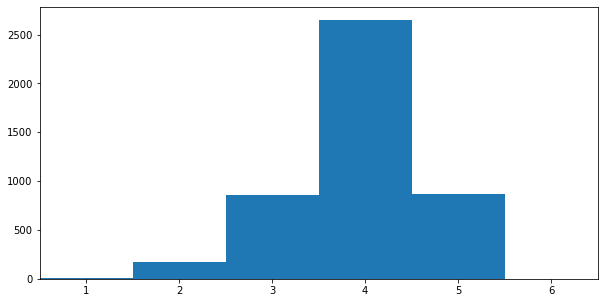

In [107]:
hist_results(T)

In [16]:
def find_order(G, V, sample, s):
    ans = []; Q = deque([]); Q.append(s)
    while Q:
        u = Q.popleft()
        if u in sample:
            ans.append(u)
        for v in G.predecessors(u):
            if not V[v]:
                Q.append(v)
    return ans

In [33]:
def greedyAppWeightReduceDynamic(G, V_, N, K, limit, wlim):
    
    V = V_.copy()
    
    E = {u for u in range(N) if not V[u]}

    ans = []
    count = 0; tot = 0
    while count < K:
        
        S = [0 for u in range(N)]
        for v in E:
            _, S[v] = get_size_weight(G, V, N, v)
        
        maxv = 0; u = -1
        for v in E:
            s = get_size_weight_precalc(G, V, S, N, v)
            if s > maxv and S[v] <= limit:
                u = v
                maxv = s
        if u == -1:
            break

        V, aux = visit(G, V, u)
        ans.append(u); tot += aux
        E.remove(u)
        count += 1

    return ans, tot

In [34]:
low = 0; high = N
while low != high:
    mid = (low + high) // 2
    P, sP = greedyAppWeightReduceDynamic(G, [0] * N, N, 8, mid, 100000000)
    if N - sP < mid:
        high = mid
    else:
        low = mid + 1
init_P, _ = greedyAppWeightReduceDynamic(G, [0] * N, N, 8, low - 1, 100000000)

In [39]:
T = []

for r in range(N):
    CV = [0 for u in range(N)]

    CV[r] = 1
    Q = deque([]); Q.append(r)
    while Q:
        u = Q.popleft()
        for v in G.successors(u):
            if not CV[v]:
                CV[v] = 1
                Q.append(v)
    V = [0] * N

    R = N; s = 743
    for t in range(100):
        
        R = sum([1 - V[u] for u in range(N)]); P = []; sP = 0
        if t == 0:
            P = init_P
        elif R >= 10:
            low = 0; high = R
            while low != high:
                mid = (low + high) // 2
                P, sP = greedyAppWeightReduceDynamic(G, V, N, 5, mid, 100000000)
                if R - sP < mid:
                    high = mid
                else:
                    low = mid + 1
            P, sP = greedyAppWeightReduceDynamic(G, V, N, 5, low, 100000000)
        else:
            P, sP = greedyAppWeightReduceDynamic(G, V, N, 5, 1, 100000000)
            
        if s not in P:
            P.append(s)
        
        P = find_order(G, V, P, s)
        
        for u in P[::-1]:
            if CV[u]:
                I = set(get_ideal(G, V, u)[::-1])
                V = [not (v in I) for v in range(N)]
                s = u; break
            else:
                V, _ = visit(G, V, u)

        size, weight = get_size_weight(G, V, N, s)

        if size == 1 or weight <= 200:
            T.append(t + 1)
            print(f"Result {r}: {T[-1]}    acc: {sum(T) / (r + 1)}")
            break
        if t == 99:
            T.append(100)
            print(f"Result {r}: {T[-1]}    acc: {sum(T) / (r + 1)}")
            
print(sum(T) / len(T), max(T))


Result 0: 2    acc: 2.0
Result 1: 3    acc: 2.5
Result 2: 2    acc: 2.3333333333333335
Result 3: 3    acc: 2.5
Result 4: 3    acc: 2.6
Result 5: 10    acc: 3.8333333333333335
Result 6: 3    acc: 3.7142857142857144
Result 7: 3    acc: 3.625
Result 8: 3    acc: 3.5555555555555554
Result 9: 3    acc: 3.5
Result 10: 3    acc: 3.4545454545454546
Result 11: 4    acc: 3.5
Result 12: 4    acc: 3.5384615384615383
Result 13: 4    acc: 3.5714285714285716
Result 14: 1    acc: 3.4
Result 15: 1    acc: 3.25
Result 16: 1    acc: 3.1176470588235294
Result 17: 1    acc: 3.0
Result 18: 1    acc: 2.8947368421052633
Result 19: 2    acc: 2.85
Result 20: 3    acc: 2.857142857142857
Result 21: 3    acc: 2.8636363636363638
Result 22: 4    acc: 2.9130434782608696
Result 23: 4    acc: 2.9583333333333335
Result 24: 1    acc: 2.88
Result 25: 5    acc: 2.9615384615384617
Result 26: 3    acc: 2.962962962962963
Result 27: 4    acc: 3.0
Result 28: 2    acc: 2.9655172413793105
Result 29: 4    acc: 3.0
Result 30: 4    

Result 218: 7    acc: 6.420091324200913
Result 219: 7    acc: 6.422727272727273
Result 220: 5    acc: 6.416289592760181
Result 221: 8    acc: 6.423423423423423
Result 222: 4    acc: 6.4125560538116595
Result 223: 4    acc: 6.401785714285714
Result 224: 4    acc: 6.391111111111111
Result 225: 4    acc: 6.380530973451328
Result 226: 6    acc: 6.378854625550661
Result 227: 6    acc: 6.37719298245614
Result 228: 6    acc: 6.3755458515283845
Result 229: 10    acc: 6.391304347826087
Result 230: 10    acc: 6.406926406926407
Result 231: 10    acc: 6.422413793103448
Result 232: 3    acc: 6.407725321888412
Result 233: 5    acc: 6.401709401709402
Result 234: 6    acc: 6.4
Result 235: 3    acc: 6.385593220338983
Result 236: 6    acc: 6.383966244725738
Result 237: 10    acc: 6.399159663865547
Result 238: 5    acc: 6.393305439330544
Result 239: 9    acc: 6.404166666666667
Result 240: 6    acc: 6.402489626556017
Result 241: 6    acc: 6.400826446280992
Result 242: 8    acc: 6.407407407407407
Result 24

Result 425: 3    acc: 6.830985915492958
Result 426: 6    acc: 6.82903981264637
Result 427: 8    acc: 6.831775700934579
Result 428: 5    acc: 6.827505827505828
Result 429: 6    acc: 6.825581395348837
Result 430: 9    acc: 6.830626450116009
Result 431: 7    acc: 6.831018518518518
Result 432: 5    acc: 6.826789838337183
Result 433: 5    acc: 6.82258064516129
Result 434: 8    acc: 6.825287356321839
Result 435: 6    acc: 6.823394495412844
Result 436: 9    acc: 6.82837528604119
Result 437: 9    acc: 6.833333333333333
Result 438: 9    acc: 6.838268792710706
Result 439: 10    acc: 6.845454545454546
Result 440: 9    acc: 6.850340136054422
Result 441: 10    acc: 6.857466063348416
Result 442: 9    acc: 6.8623024830699775
Result 443: 3    acc: 6.853603603603603
Result 444: 6    acc: 6.851685393258427
Result 445: 11    acc: 6.860986547085202
Result 446: 6    acc: 6.859060402684563
Result 447: 7    acc: 6.859375
Result 448: 7    acc: 6.859688195991091
Result 449: 7    acc: 6.86
Result 450: 7    acc:

Result 632: 10    acc: 6.668246445497631
Result 633: 10    acc: 6.673501577287066
Result 634: 10    acc: 6.678740157480315
Result 635: 10    acc: 6.683962264150943
Result 636: 10    acc: 6.689167974882261
Result 637: 10    acc: 6.69435736677116
Result 638: 10    acc: 6.699530516431925
Result 639: 9    acc: 6.703125
Result 640: 9    acc: 6.7067082683307335
Result 641: 9    acc: 6.710280373831775
Result 642: 9    acc: 6.713841368584759
Result 643: 9    acc: 6.717391304347826
Result 644: 8    acc: 6.7193798449612405
Result 645: 8    acc: 6.7213622291021675
Result 646: 8    acc: 6.723338485316847
Result 647: 5    acc: 6.720679012345679
Result 648: 9    acc: 6.724191063174114
Result 649: 9    acc: 6.727692307692307
Result 650: 4    acc: 6.723502304147465
Result 651: 8    acc: 6.725460122699387
Result 652: 8    acc: 6.727411944869831
Result 653: 4    acc: 6.723241590214068
Result 654: 4    acc: 6.719083969465649
Result 655: 5    acc: 6.716463414634147
Result 656: 7    acc: 6.71689497716895
R

Result 838: 6    acc: 6.562574493444576
Result 839: 6    acc: 6.561904761904762
Result 840: 6    acc: 6.561236623067776
Result 841: 7    acc: 6.561757719714964
Result 842: 7    acc: 6.562277580071174
Result 843: 7    acc: 6.562796208530806
Result 844: 7    acc: 6.563313609467456
Result 845: 7    acc: 6.5638297872340425
Result 846: 7    acc: 6.564344746162928
Result 847: 9    acc: 6.567216981132075
Result 848: 9    acc: 6.570082449941107
Result 849: 9    acc: 6.5729411764705885
Result 850: 7    acc: 6.573443008225617
Result 851: 7    acc: 6.573943661971831
Result 852: 4    acc: 6.570926143024619
Result 853: 7    acc: 6.571428571428571
Result 854: 6    acc: 6.570760233918128
Result 855: 8    acc: 6.572429906542056
Result 856: 13    acc: 6.579929988331388
Result 857: 13    acc: 6.5874125874125875
Result 858: 12    acc: 6.59371362048894
Result 859: 12    acc: 6.6
Result 860: 12    acc: 6.606271777003484
Result 861: 12    acc: 6.612529002320185
Result 862: 12    acc: 6.618771726535342
Resul

Result 1043: 6    acc: 6.46360153256705
Result 1044: 5    acc: 6.462200956937799
Result 1045: 6    acc: 6.461759082217974
Result 1046: 7    acc: 6.462273161413562
Result 1047: 6    acc: 6.461832061068702
Result 1048: 6    acc: 6.46139180171592
Result 1049: 3    acc: 6.458095238095238
Result 1050: 7    acc: 6.45861084681256
Result 1051: 3    acc: 6.45532319391635
Result 1052: 7    acc: 6.455840455840455
Result 1053: 4    acc: 6.453510436432637
Result 1054: 7    acc: 6.454028436018957
Result 1055: 8    acc: 6.455492424242424
Result 1056: 2    acc: 6.45127719962157
Result 1057: 2    acc: 6.447069943289225
Result 1058: 3    acc: 6.443814919735599
Result 1059: 2    acc: 6.439622641509434
Result 1060: 2    acc: 6.435438265786994
Result 1061: 4    acc: 6.4331450094161955
Result 1062: 6    acc: 6.432737535277517
Result 1063: 8    acc: 6.434210526315789
Result 1064: 3    acc: 6.430985915492958
Result 1065: 4    acc: 6.428705440900563
Result 1066: 8    acc: 6.430178069353327
Result 1067: 5    ac

Result 1243: 4    acc: 6.364951768488746
Result 1244: 2    acc: 6.36144578313253
Result 1245: 4    acc: 6.359550561797753
Result 1246: 4    acc: 6.3576583801122695
Result 1247: 6    acc: 6.357371794871795
Result 1248: 6    acc: 6.357085668534828
Result 1249: 5    acc: 6.356
Result 1250: 5    acc: 6.3549160671462825
Result 1251: 5    acc: 6.353833865814696
Result 1252: 5    acc: 6.352753391859537
Result 1253: 5    acc: 6.351674641148326
Result 1254: 2    acc: 6.348207171314741
Result 1255: 6    acc: 6.347929936305732
Result 1256: 6    acc: 6.347653142402546
Result 1257: 7    acc: 6.348171701112878
Result 1258: 7    acc: 6.348689436060365
Result 1259: 7    acc: 6.349206349206349
Result 1260: 7    acc: 6.349722442505947
Result 1261: 7    acc: 6.350237717908082
Result 1262: 7    acc: 6.350752177355503
Result 1263: 7    acc: 6.35126582278481
Result 1264: 7    acc: 6.351778656126482
Result 1265: 7    acc: 6.352290679304898
Result 1266: 7    acc: 6.352801894238358
Result 1267: 6    acc: 6.352

Result 1443: 8    acc: 6.531855955678671
Result 1444: 8    acc: 6.532871972318339
Result 1445: 8    acc: 6.533886583679115
Result 1446: 8    acc: 6.534899792674499
Result 1447: 4    acc: 6.533149171270718
Result 1448: 4    acc: 6.531400966183575
Result 1449: 4    acc: 6.5296551724137935
Result 1450: 4    acc: 6.5279117849758785
Result 1451: 5    acc: 6.526859504132231
Result 1452: 5    acc: 6.525808671713696
Result 1453: 5    acc: 6.524759284731775
Result 1454: 6    acc: 6.524398625429553
Result 1455: 5    acc: 6.523351648351649
Result 1456: 5    acc: 6.522306108442004
Result 1457: 6    acc: 6.521947873799726
Result 1458: 6    acc: 6.5215901302261825
Result 1459: 6    acc: 6.521232876712329
Result 1460: 6    acc: 6.520876112251882
Result 1461: 7    acc: 6.521203830369357
Result 1462: 6    acc: 6.520847573479152
Result 1463: 6    acc: 6.520491803278689
Result 1464: 6    acc: 6.520136518771331
Result 1465: 6    acc: 6.5197817189631655
Result 1466: 7    acc: 6.520109066121336
Result 1467:

Result 1644: 6    acc: 6.493009118541034
Result 1645: 7    acc: 6.493317132442284
Result 1646: 6    acc: 6.493017607771706
Result 1647: 6    acc: 6.492718446601942
Result 1648: 7    acc: 6.4930260764099454
Result 1649: 6    acc: 6.492727272727273
Result 1650: 7    acc: 6.493034524530588
Result 1651: 6    acc: 6.49273607748184
Result 1652: 6    acc: 6.492437991530551
Result 1653: 7    acc: 6.492744860943168
Result 1654: 6    acc: 6.492447129909365
Result 1655: 6    acc: 6.492149758454106
Result 1656: 6    acc: 6.491852745926373
Result 1657: 5    acc: 6.490952955367913
Result 1658: 5    acc: 6.490054249547921
Result 1659: 5    acc: 6.489156626506024
Result 1660: 6    acc: 6.488862131246237
Result 1661: 6    acc: 6.488567990373045
Result 1662: 7    acc: 6.488875526157547
Result 1663: 4    acc: 6.4873798076923075
Result 1664: 4    acc: 6.485885885885886
Result 1665: 4    acc: 6.4843937575030015
Result 1666: 4    acc: 6.482903419316137
Result 1667: 4    acc: 6.4814148681055155
Result 1668: 

Result 1844: 7    acc: 6.519241192411924
Result 1845: 9    acc: 6.520585048754063
Result 1846: 4    acc: 6.519220357336221
Result 1847: 5    acc: 6.518398268398268
Result 1848: 12    acc: 6.521362898864251
Result 1849: 5    acc: 6.520540540540541
Result 1850: 5    acc: 6.519719070772555
Result 1851: 4    acc: 6.518358531317495
Result 1852: 5    acc: 6.51753912574204
Result 1853: 6    acc: 6.517259978425027
Result 1854: 5    acc: 6.51644204851752
Result 1855: 6    acc: 6.516163793103448
Result 1856: 6    acc: 6.515885837372106
Result 1857: 4    acc: 6.514531754574811
Result 1858: 6    acc: 6.514254975793437
Result 1859: 5    acc: 6.513440860215054
Result 1860: 6    acc: 6.513164965072542
Result 1861: 6    acc: 6.512889366272825
Result 1862: 6    acc: 6.512614063338701
Result 1863: 6    acc: 6.5123390557939915
Result 1864: 3    acc: 6.510455764075067
Result 1865: 6    acc: 6.510182207931404
Result 1866: 4    acc: 6.508837707552223
Result 1867: 4    acc: 6.507494646680942
Result 1868: 4  

Result 2044: 3    acc: 6.536919315403423
Result 2045: 3    acc: 6.535190615835777
Result 2046: 3    acc: 6.5334636052760136
Result 2047: 3    acc: 6.53173828125
Result 2048: 3    acc: 6.5300146412884335
Result 2049: 3    acc: 6.528292682926829
Result 2050: 2    acc: 6.526084836665041
Result 2051: 2    acc: 6.523879142300195
Result 2052: 10    acc: 6.525572333170969
Result 2053: 2    acc: 6.523369036027264
Result 2054: 4    acc: 6.522141119221411
Result 2055: 4    acc: 6.52091439688716
Result 2056: 3    acc: 6.519202722411278
Result 2057: 2    acc: 6.517006802721088
Result 2058: 2    acc: 6.5148130160271975
Result 2059: 2    acc: 6.512621359223301
Result 2060: 3    acc: 6.510917030567685
Result 2061: 3    acc: 6.509214354995151
Result 2062: 3    acc: 6.507513330101793
Result 2063: 3    acc: 6.505813953488372
Result 2064: 3    acc: 6.504116222760291
Result 2065: 3    acc: 6.50242013552759
Result 2066: 4    acc: 6.501209482341558
Result 2067: 4    acc: 6.5
Result 2068: 6    acc: 6.4997583

Result 2245: 3    acc: 6.353517364203028
Result 2246: 3    acc: 6.35202492211838
Result 2247: 3    acc: 6.350533807829182
Result 2248: 4    acc: 6.34948866162739
Result 2249: 7    acc: 6.349777777777778
Result 2250: 6    acc: 6.349622390048867
Result 2251: 5    acc: 6.349023090586146
Result 2252: 8    acc: 6.349755881047492
Result 2253: 8    acc: 6.350488021295475
Result 2254: 6    acc: 6.3503325942350335
Result 2255: 7    acc: 6.350620567375887
Result 2256: 7    acc: 6.350908285334515
Result 2257: 5    acc: 6.350310008857396
Result 2258: 7    acc: 6.350597609561753
Result 2259: 5    acc: 6.35
Result 2260: 5    acc: 6.349402919062362
Result 2261: 7    acc: 6.349690539345712
Result 2262: 7    acc: 6.349977905435263
Result 2263: 12    acc: 6.352473498233215
Result 2264: 12    acc: 6.354966887417219
Result 2265: 8    acc: 6.355692850838482
Result 2266: 8    acc: 6.356418173797971
Result 2267: 8    acc: 6.357142857142857
Result 2268: 6    acc: 6.356985456148083
Result 2269: 8    acc: 6.357

Result 2446: 7    acc: 6.347364119329791
Result 2447: 9    acc: 6.3484477124183005
Result 2448: 9    acc: 6.349530420579828
Result 2449: 6    acc: 6.349387755102041
Result 2450: 9    acc: 6.35046919624643
Result 2451: 9    acc: 6.351549755301795
Result 2452: 9    acc: 6.352629433346922
Result 2453: 9    acc: 6.3537082314588424
Result 2454: 9    acc: 6.354786150712831
Result 2455: 9    acc: 6.355863192182411
Result 2456: 9    acc: 6.356939356939357
Result 2457: 7    acc: 6.35720097640358
Result 2458: 7    acc: 6.357462383082554
Result 2459: 7    acc: 6.357723577235772
Result 2460: 9    acc: 6.358797236895571
Result 2461: 9    acc: 6.359870024370431
Result 2462: 9    acc: 6.360941940722696
Result 2463: 9    acc: 6.362012987012987
Result 2464: 9    acc: 6.363083164300203
Result 2465: 9    acc: 6.364152473641525
Result 2466: 9    acc: 6.36522091609242
Result 2467: 9    acc: 6.366288492706645
Result 2468: 9    acc: 6.367355204536249
Result 2469: 9    acc: 6.368421052631579
Result 2470: 9   

Result 2647: 5    acc: 6.33987915407855
Result 2648: 8    acc: 6.340505851264628
Result 2649: 9    acc: 6.341509433962264
Result 2650: 9    acc: 6.342512259524708
Result 2651: 9    acc: 6.343514328808446
Result 2652: 9    acc: 6.344515642668677
Result 2653: 9    acc: 6.345516201959307
Result 2654: 9    acc: 6.346516007532957
Result 2655: 9    acc: 6.347515060240964
Result 2656: 9    acc: 6.348513360933383
Result 2657: 9    acc: 6.349510910458991
Result 2658: 9    acc: 6.350507709665288
Result 2659: 11    acc: 6.352255639097744
Result 2660: 11    acc: 6.354002254791432
Result 2661: 10    acc: 6.355371900826446
Result 2662: 9    acc: 6.356365001877582
Result 2663: 9    acc: 6.357357357357357
Result 2664: 6    acc: 6.3572232645403375
Result 2665: 6    acc: 6.357089272318079
Result 2666: 6    acc: 6.3569553805774275
Result 2667: 6    acc: 6.356821589205397
Result 2668: 6    acc: 6.356687898089172
Result 2669: 5    acc: 6.356179775280899
Result 2670: 5    acc: 6.355672032946462
Result 2671:

Result 2846: 6    acc: 6.422550052687039
Result 2847: 6    acc: 6.422401685393258
Result 2848: 7    acc: 6.422604422604422
Result 2849: 10    acc: 6.423859649122807
Result 2850: 10    acc: 6.4251139950894425
Result 2851: 10    acc: 6.4263674614305755
Result 2852: 10    acc: 6.4276200490711535
Result 2853: 10    acc: 6.428871758934828
Result 2854: 10    acc: 6.430122591943958
Result 2855: 10    acc: 6.431372549019608
Result 2856: 10    acc: 6.432621631081554
Result 2857: 10    acc: 6.433869839048286
Result 2858: 10    acc: 6.435117173837006
Result 2859: 4    acc: 6.434265734265734
Result 2860: 3    acc: 6.433065361761622
Result 2861: 3    acc: 6.431865828092243
Result 2862: 3    acc: 6.430667132378624
Result 2863: 3    acc: 6.429469273743017
Result 2864: 3    acc: 6.428272251308901
Result 2865: 3    acc: 6.4270760642009765
Result 2866: 5    acc: 6.426578304848274
Result 2867: 3    acc: 6.425383542538354
Result 2868: 13    acc: 6.427675148135239
Result 2869: 13    acc: 6.429965156794425


Result 3046: 3    acc: 6.366261896947818
Result 3047: 3    acc: 6.36515748031496
Result 3048: 3    acc: 6.364053788127255
Result 3049: 3    acc: 6.362950819672131
Result 3050: 5    acc: 6.362504097017371
Result 3051: 5    acc: 6.362057667103539
Result 3052: 5    acc: 6.361611529642974
Result 3053: 3    acc: 6.360510805500982
Result 3054: 3    acc: 6.359410801963993
Result 3055: 3    acc: 6.358311518324608
Result 3056: 7    acc: 6.358521426234871
Result 3057: 8    acc: 6.359058207979071
Result 3058: 8    acc: 6.35959463877084
Result 3059: 8    acc: 6.360130718954248
Result 3060: 3    acc: 6.359032995753022
Result 3061: 3    acc: 6.357935989549314
Result 3062: 4    acc: 6.3571661769507015
Result 3063: 4    acc: 6.356396866840731
Result 3064: 5    acc: 6.355954323001631
Result 3065: 5    acc: 6.355512067840835
Result 3066: 5    acc: 6.35507010107597
Result 3067: 5    acc: 6.354628422425033
Result 3068: 5    acc: 6.354187031606386
Result 3069: 3    acc: 6.353094462540716
Result 3070: 3    

Result 3247: 8    acc: 6.334051724137931
Result 3248: 8    acc: 6.3345644813788855
Result 3249: 5    acc: 6.334153846153846
Result 3250: 5    acc: 6.333743463549677
Result 3251: 5    acc: 6.333333333333333
Result 3252: 5    acc: 6.332923455272057
Result 3253: 7    acc: 6.333128457283344
Result 3254: 7    acc: 6.333333333333333
Result 3255: 2    acc: 6.332002457002457
Result 3256: 2    acc: 6.330672397912189
Result 3257: 7    acc: 6.330877839165132
Result 3258: 7    acc: 6.3310831543418224
Result 3259: 8    acc: 6.33159509202454
Result 3260: 8    acc: 6.332106715731371
Result 3261: 8    acc: 6.332618025751073
Result 3262: 11    acc: 6.334048421697824
Result 3263: 5    acc: 6.333639705882353
Result 3264: 5    acc: 6.33323124042879
Result 3265: 5    acc: 6.332823025107165
Result 3266: 7    acc: 6.333027242118151
Result 3267: 7    acc: 6.3332313341493265
Result 3268: 7    acc: 6.333435301315387
Result 3269: 5    acc: 6.3330275229357795
Result 3270: 5    acc: 6.332619993885662
Result 3271: 

Result 3446: 12    acc: 6.374818682912678
Result 3447: 12    acc: 6.376450116009281
Result 3448: 12    acc: 6.378080603073355
Result 3449: 12    acc: 6.379710144927536
Result 3450: 12    acc: 6.381338742393509
Result 3451: 12    acc: 6.382966396292004
Result 3452: 12    acc: 6.384593107442804
Result 3453: 12    acc: 6.386218876664737
Result 3454: 12    acc: 6.387843704775688
Result 3455: 12    acc: 6.389467592592593
Result 3456: 11    acc: 6.390801272779867
Result 3457: 11    acc: 6.392134181607866
Result 3458: 11    acc: 6.393466319745591
Result 3459: 11    acc: 6.394797687861272
Result 3460: 12    acc: 6.396417220456516
Result 3461: 12    acc: 6.398035817446563
Result 3462: 12    acc: 6.399653479641929
Result 3463: 12    acc: 6.401270207852194
Result 3464: 10    acc: 6.402308802308802
Result 3465: 10    acc: 6.40334679746105
Result 3466: 10    acc: 6.404384193827517
Result 3467: 10    acc: 6.405420991926182
Result 3468: 10    acc: 6.406457192274431
Result 3469: 11    acc: 6.407780979

Result 3644: 9    acc: 6.483401920438958
Result 3645: 9    acc: 6.484092155787164
Result 3646: 9    acc: 6.484782012613107
Result 3647: 9    acc: 6.48547149122807
Result 3648: 9    acc: 6.486160591942998
Result 3649: 6    acc: 6.4860273972602736
Result 3650: 6    acc: 6.485894275540947
Result 3651: 6    acc: 6.485761226725082
Result 3652: 8    acc: 6.486175745962223
Result 3653: 8    acc: 6.486590038314176
Result 3654: 8    acc: 6.487004103967168
Result 3655: 6    acc: 6.486870897155361
Result 3656: 5    acc: 6.486464315012305
Result 3657: 5    acc: 6.486057955166758
Result 3658: 4    acc: 6.485378518720962
Result 3659: 4    acc: 6.4846994535519125
Result 3660: 4    acc: 6.484020759355367
Result 3661: 5    acc: 6.483615510649918
Result 3662: 7    acc: 6.483756483756483
Result 3663: 7    acc: 6.483897379912664
Result 3664: 7    acc: 6.484038199181446
Result 3665: 7    acc: 6.48417894162575
Result 3666: 5    acc: 6.483774202345241
Result 3667: 6    acc: 6.4836423118865865
Result 3668: 6 

Result 3844: 3    acc: 6.497269180754226
Result 3845: 3    acc: 6.496359854394176
Result 3846: 3    acc: 6.495451000779829
Result 3847: 3    acc: 6.49454261954262
Result 3848: 3    acc: 6.4936347103143675
Result 3849: 3    acc: 6.492727272727273
Result 3850: 5    acc: 6.4923396520384316
Result 3851: 5    acc: 6.4919522326064385
Result 3852: 5    acc: 6.491565014274591
Result 3853: 5    acc: 6.491177996886352
Result 3854: 6    acc: 6.491050583657588
Result 3855: 4    acc: 6.4904045643153525
Result 3856: 11    acc: 6.491573761991185
Result 3857: 11    acc: 6.492742353551063
Result 3858: 11    acc: 6.493910339466183
Result 3859: 12    acc: 6.495336787564767
Result 3860: 12    acc: 6.496762496762496
Result 3861: 12    acc: 6.49818746763335
Result 3862: 12    acc: 6.4996117007507115
Result 3863: 12    acc: 6.50103519668737
Result 3864: 12    acc: 6.502457956015524
Result 3865: 12    acc: 6.503879979306777
Result 3866: 11    acc: 6.505042668735454
Result 3867: 11    acc: 6.506204756980352
Re

Result 4043: 8    acc: 6.539564787339268
Result 4044: 7    acc: 6.5396786155747835
Result 4045: 7    acc: 6.539792387543253
Result 4046: 7    acc: 6.539906103286385
Result 4047: 7    acc: 6.54001976284585
Result 4048: 7    acc: 6.540133366263275
Result 4049: 3    acc: 6.539259259259259
Result 4050: 7    acc: 6.53937299432239
Result 4051: 6    acc: 6.53923988153998
Result 4052: 6    acc: 6.539106834443622
Result 4053: 6    acc: 6.538973852984706
Result 4054: 6    acc: 6.538840937114673
Result 4055: 7    acc: 6.538954635108481
Result 4056: 5    acc: 6.538575301947252
Result 4057: 5    acc: 6.538196155741745
Result 4058: 7    acc: 6.538309928553831
Result 4059: 7    acc: 6.538423645320197
Result 4060: 7    acc: 6.538537306082246
Result 4061: 7    acc: 6.538650910881339
Result 4062: 7    acc: 6.538764459758799
Result 4063: 7    acc: 6.5388779527559056
Result 4064: 7    acc: 6.538991389913899
Result 4065: 7    acc: 6.539104771273979
Result 4066: 5    acc: 6.538726333907057
Result 4067: 5   

Result 4243: 5    acc: 6.482563619227144
Result 4244: 6    acc: 6.482449941107185
Result 4245: 6    acc: 6.482336316533208
Result 4246: 7    acc: 6.482458205792324
Result 4247: 7    acc: 6.482580037664784
Result 4248: 4    acc: 6.481995763709108
Result 4249: 8    acc: 6.482352941176471
Result 4250: 6    acc: 6.482239473065161
Result 4251: 7    acc: 6.482361241768579
Result 4252: 6    acc: 6.48224782506466
Result 4253: 6    acc: 6.482134461683121
Result 4254: 6    acc: 6.482021151586369
Result 4255: 6    acc: 6.4819078947368425
Result 4256: 6    acc: 6.481794691097017
Result 4257: 6    acc: 6.4816815406294035
Result 4258: 9    acc: 6.482272833998591
Result 4259: 9    acc: 6.482863849765258
Result 4260: 10    acc: 6.483689274818118
Result 4261: 9    acc: 6.484279680900985
Result 4262: 9    acc: 6.484869809992963
Result 4263: 9    acc: 6.485459662288931
Result 4264: 10    acc: 6.486283704572099
Result 4265: 10    acc: 6.487107360525082
Result 4266: 10    acc: 6.487930630419498
Result 4267

Result 4442: 9    acc: 6.552779653387351
Result 4443: 9    acc: 6.553330333033303
Result 4444: 10    acc: 6.554105736782902
Result 4445: 5    acc: 6.553756185335133
Result 4446: 8    acc: 6.554081403193164
Result 4447: 8    acc: 6.554406474820144
Result 4448: 8    acc: 6.554731400314678
Result 4449: 8    acc: 6.555056179775281
Result 4450: 8    acc: 6.555380813300382
Result 4451: 8    acc: 6.55570530098832
Result 4452: 8    acc: 6.556029642937346
Result 4453: 6    acc: 6.55590480466996
Result 4454: 11    acc: 6.556902356902357
Result 4455: 11    acc: 6.557899461400359
Result 4456: 11    acc: 6.558896118465335
Result 4457: 11    acc: 6.5598923283983845
Result 4458: 11    acc: 6.5608880915003365
Result 4459: 12    acc: 6.5621076233183855
Result 4460: 12    acc: 6.56332660838377
Result 4461: 12    acc: 6.5645450470640965
Result 4462: 12    acc: 6.565762939726642
Result 4463: 11    acc: 6.566756272401434
Result 4464: 5    acc: 6.566405375139977
Result 4465: 9    acc: 6.566950291088222
Resu

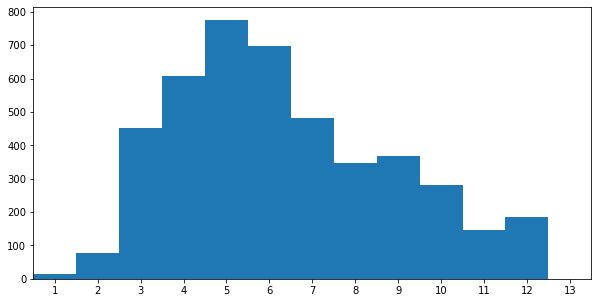

In [44]:
T = [t for t in T if t <= 13]
# T = [t for t in T if t <= 13]
hist_results(T)

In [62]:
def points_coordinates(points, geometry):
    original_points = [_id[i] for i in points]
    coord = []
    for i_d in original_points:
        try:
            filtered = geometry[geometry['self'] == str(i_d)]['geometry'].iloc[0].coords[0]
            x = filtered[0] ; y = filtered[1]
            coord.append(Point(x, y).buffer(75))
        except:
            pass
    return coord

In [63]:
def save_sample_tree(G, N, V_, s, sample, points, geom, name):
    
    geometry = geom.copy()
    
    ideal = get_ideal(G, V_, s)
    V = [0 if u in ideal else 1 for u in range(N)]
    I = []; C = [1 - V[u] for u in range(N)]
    
    i = 0; sizes = []
    c = [j + 1 for j in range(len(sample))]; random.shuffle(c)
    for u in sample[::-1]:
        ideal = get_ideal(G, V, u)
        sizes.append(len(ideal))
        for v in ideal:
            V[v] = 1
            C[v] = c[i]
        i += 1

    # Marcamos los elementos visitados en geometry
    geometry['color'] = 0
    for u in range(N):
        if C[u] != 0:
            geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
            
    coord = points_coordinates(points, geometry)
    for i in range(len(coord)):
        geometry.loc[geometry.shape[0] + i] =  [None] * 5 + [coord[i], 0]
          
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                figsize=(15, 15),
                legend = True,
                legend_kwds={'label': "-1: No considerado \n 0: No cubierto ", 'orientation': "horizontal"},
                cmap = 'nipy_spectral',)
    plt.ylim(5908500, 5917300)

    props = dict(facecolor='white', alpha=0.5)
    ax.text(0.05, 0.05, "Tamaños: " + ", ".join([f"{i + 1} = {sizes[i]}" for i in range(len(sizes))]), transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=props)
    
    plt.savefig(f"{name}.png")

# Sensibilidad

In [2]:
path = 'data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095, 131099}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
        
###################################################################################################

        
path = 'data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

path_pesos = 'data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {15190, 1003206, 16503, 15004, 14062, 13735, 1003167, 1003744, 1003746, 1003950, 13730, 13731, 13732, 13733, 15131, 16094, 16095, 131099}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[origin], id_[dest])
    
N = l

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [3]:
def get_size(G, V_, u):
    
    if V_[u] == 1:
        return 0
    
    V = V_.copy()
    
    ans = 1;  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                ans += 1; V[v] = 1
                Q.append(v)
    
    return ans

def visit(G, V, u):
    
    if V[u] == 1:
        return V, 0
    
    V[u] = 1; ans = 0
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft(); ans += 1
        for v in G.predecessors(u):
            if not V[v]:
                V[v] = 1
                Q.append(v)
    
    return V, ans

def get_ideal(G, V_, u):
    
    if V_[u] == 1:
        return []
    
    V = V_.copy()
    
    s = [u];  V[u] = 1
    Q = deque([]); Q.append(u)
    while Q:
        u = Q.popleft()
        for v in G.predecessors(u):
            if not V[v]:
                s.append(v)
                V[v] = 1; Q.append(v)
    
    return s

In [4]:
def get_dp_table(G, V, N, k, s, mult):

    order = get_ideal(G, V, s)[::-1]
    size = get_size(G, V, s)

    possibilities = {u: [] for u in order}
    next_dicts = {u: {} for u in order}

    for u in order:

        new_possibilities = {}; new_next = {}
        predecessors = [v for v in G.predecessors(u) if not V[v]]

        mul = [1 for v in predecessors]; combs = 1 if predecessors else 0
        for i in range(len(predecessors)):
            now = len(possibilities[predecessors[i]])
            for j in range(i):
                mul[j] *= now
            combs *= now
        
        for i in range(combs):

            indexes = [0 for v in predecessors]
            for j in range(len(predecessors)):
                indexes[j] = (i // mul[j])
                i %= mul[j]

            l = 0; size_left = 1; max_ideal = 0; min_ideal = N
            for j in range(len(predecessors)):
                pos = possibilities[predecessors[j]][indexes[j]]
                l += pos[0]
                size_left += pos[1]
                max_ideal = max(max_ideal, pos[2])
                min_ideal = min(min_ideal, pos[3])

            if l >= k:
                continue

            if new_possibilities.get((l, max_ideal // mult)):
                prev = new_possibilities[(l, max_ideal // mult)]
                if size_left < prev[0] or (size_left == prev[0] and min_ideal > prev[2]):
                    new_possibilities[(l, max_ideal // mult)] = (size_left, max_ideal, min_ideal)
                    new_next[(l, max_ideal // mult)] = indexes
            else:
                new_possibilities[(l, max_ideal // mult)] = (size_left, max_ideal, min_ideal)
                new_next[(l, max_ideal // mult)] = indexes
                
            if l < k:
                if new_possibilities.get((l + 1, max(size_left, max_ideal) // mult)):
                    prev = new_possibilities[(l + 1, max(size_left, max_ideal) // mult)]
                    if 0 < prev[0] or (0 == prev[0] and min(size_left, min_ideal) > prev[2]):
                        new_possibilities[(l + 1, max(size_left, max_ideal) // mult)] = (0, max(size_left, max_ideal), min(size_left, min_ideal))
                        new_next[(l + 1, max(size_left, max_ideal) // mult)] = indexes
                else:
                    new_possibilities[(l + 1, max(size_left, max_ideal) // mult)] = (0, max(size_left, max_ideal), min(size_left, min_ideal))
                    new_next[(l + 1, max(size_left, max_ideal) // mult)] = indexes

        if combs == 0:
            new_possibilities[(0, 0)] = (1, 0, N)
            new_next[(0, 0)] = []
            new_possibilities[(1, 0)] = (0, 1, 1)
            new_next[(1, 0)] = []
        
        final_possibilities = set()
        for item in new_possibilities.items():
            o, b = item;
            a = (o[0], b[0], b[1], b[2])
            final_possibilities.add(a)
            next_dicts[u][a] = new_next[o]

        possibilities[u] = list(final_possibilities)

    return possibilities, next_dicts

def get_sample_from_table(G, possibilities, next_dicts, V, k, s):
    
    mv = 1e10; opt_pos = None
    for pos in possibilities[s]:
        if pos[0] == k and pos[1] == 0:
            now = pos[2]
            if now < mv:
                mv = now
                opt_pos = pos
                
    ans = []
    Q = deque([]); Q.append((s, opt_pos))
    while Q:
        u, pos = Q.popleft()

        if pos[1] == 0:
            ans.append(u)

        i = 0; indexes = next_dicts[u][pos]

        predecessors = [v for v in G.predecessors(u) if not V[v]]
        
        for v in predecessors:
            next_pos_v = possibilities[v][indexes[i]]
            Q.append((v, next_pos_v)); i += 1

    V_ = [0] * N; sizes = []
    for u in ans[::-1]:
        V_, x = visit(G, V_, u)
        sizes.append(x)
    
    return ans, sizes

In [8]:
# Diferencias

diff = [[] for i in range(5)]
diff_p = [[] for i in range(5)]
diff_pf = [[] for i in range(5)]

V1 = [0] * N

s = 743
possibilities, next_dicts = get_dp_table(T, V1, N, 8, s, 50)
P1, _ = get_sample_from_table(T, possibilities, next_dicts, V1, 8, s)

for u1 in P1[::-1]:
        
    d = abs(get_size(G, V1, u1) - get_size(T, V1, u1))
    diff[0].append(d)
    diff_p[0].append(d / get_size(T, V1, u1))
    
    if d <= get_size(T, V1, u1) * 0.5 :
        diff_pf[0].append(d / get_size(T, V1, u1))

    I = set(get_ideal(T, V1, u1))
    V2 = [not (v in I) for v in range(N)]

    possibilities, next_dicts = get_dp_table(T, V2, N, 5, u1, 20)
    P2, _ = get_sample_from_table(T, possibilities, next_dicts, V2, 5, u1)

    for u2 in P2[::-1]:
            
        d = abs(get_size(G, V2, u2) - get_size(T, V2, u2))
        diff[1].append(d)
        diff_p[1].append(d / get_size(T, V2, u2))
                
        if d <= get_size(T, V2, u2) * 0.5 :
            diff_pf[1].append(d / get_size(T, V2, u2))

        I = set(get_ideal(T, V2, u2))
        V3 = [not (v in I) for v in range(N)]

        possibilities, next_dicts = get_dp_table(T, V3, N, 5, u2, 10)
        P3, _ = get_sample_from_table(T, possibilities, next_dicts, V3, 5, u2)
        
        for u3 in P3[::-1]:
            
            d = abs(get_size(G, V3, u3) - get_size(T, V3, u3))
            diff[2].append(d)
            diff_p[2].append(d / get_size(T, V3, u3))

            if d <= get_size(T, V3, u3) * 0.5 :
                diff_pf[2].append(d / get_size(T, V3, u3))

            I = set(get_ideal(T, V3, u3))
            V4 = [not (v in I) for v in range(N)]

            possibilities, next_dicts = get_dp_table(T, V4, N, min(5, N - sum(V4)), u3, 5)
            P4, _ = get_sample_from_table(T, possibilities, next_dicts, V4, min(5, N - sum(V4)), u3)
            
            for u4 in P4[::-1]:
                
                d = abs(get_size(G, V4, u4) - get_size(T, V4, u4))
                diff[3].append(d)
                diff_p[3].append(d / get_size(T, V4, u4))

                if d <= get_size(T, V4, u4) * 0.5 :
                    diff_pf[3].append(d / get_size(T, V4, u4))

                I = set(get_ideal(T, V4, u4))
                V5 = [not (v in I) for v in range(N)]

                possibilities, next_dicts = get_dp_table(T, V5, N, min(5, N - sum(V5)), u4, 1)
                P5, _ = get_sample_from_table(T, possibilities, next_dicts, V5, min(5, N - sum(V5)), u4)
                
                for u5 in P5[::-1]:
                    
                    d = abs(get_size(G, V5, u5) - get_size(T, V5, u5))
                    diff[4].append(d)
                    diff_p[4].append(d / get_size(T, V5, u5))
                    
                    if d <= get_size(T, V5, u5) * 0.5 :
                        diff_pf[4].append(d / get_size(T, V5, u5))
                    
                    V5, _ = visit(T, V5, u5)
                V4, _ = visit(T, V4, u4)
            V3, _ = visit(T, V3, u3)
        V2, _ = visit(T, V2, u2)
    V1, _ = visit(T, V1, u1)
    
print([max(d) for d in diff])
print([sum(d) / len(d) for d in diff])
print([max(d) for d in diff_p])
print([sum(d) / len(d) * 100 for d in diff_p])
print([max(d) for d in diff_pf])
print([sum(d) / len(d) * 100 for d in diff_pf])
print([len(diff_p[i]) - len(diff_pf[i]) for i in range(len(diff_p))])


[599, 115, 50, 8, 3]
[96.0, 13.0, 1.875, 0.15583075335397317, 0.009795689896445563]
[0.9614767255216693, 0.9841269841269841, 1.9090909090909092, 1.0, 1.5]
[17.135028108102, 11.228722791280846, 8.567842463565372, 3.0874981571576, 0.4781229592312715]
[0.3853904282115869, 0.45217391304347826, 0.45454545454545453, 0.5, 0.5]
[5.847507473235581, 7.0526947444446115, 3.772149832470751, 1.6659565580618214, 0.3874883286647992]
[1, 2, 11, 19, 3]
